# Hotel Review Analysis - (EDA and NLP Sentiment Analysis)

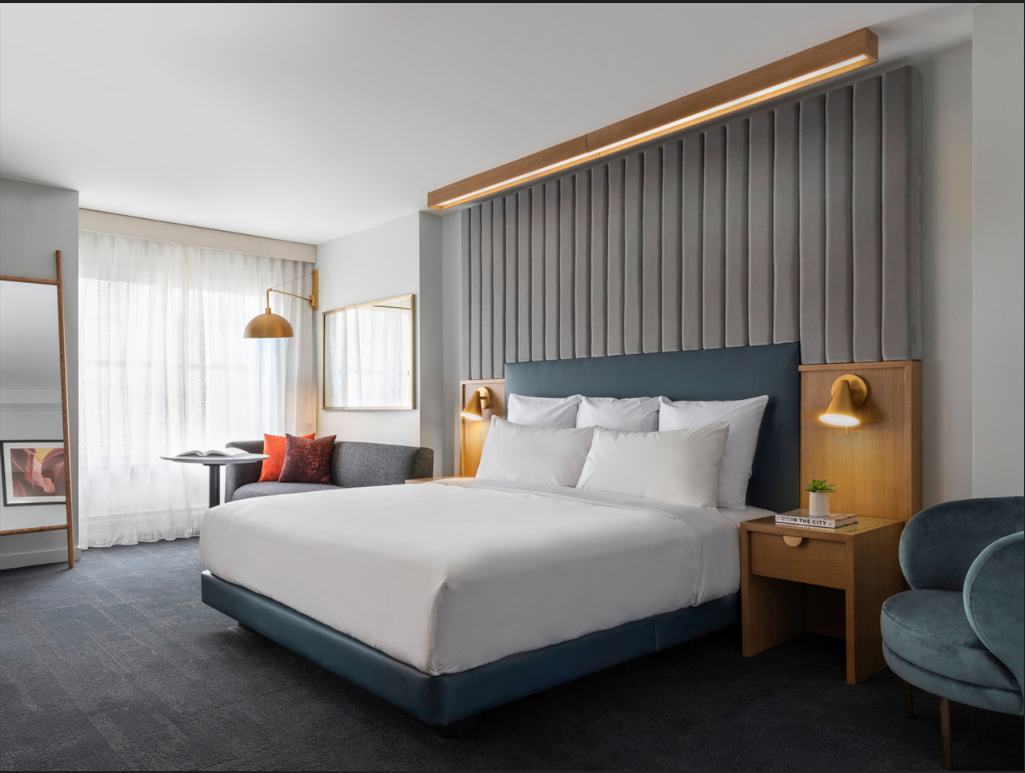

# **Table of Contents**

1. [Scope of Project](#scope)<br>
2. [Dataset Overview](#dataset) <br>
3. [Libraries Used](#libraries)<br>
4. [Preliminary Dataset Preparation & Cleaning](#prelim) <br>
   (Duplicates & Null value handling)
5. [Exploratory Data Analysis](#eda) <br>
   5.1  [Create Recommend column using Review Score](#recommend) <br>
   5.2  [Hotel locations (using Folium)](#folium)<br>
   5.3  [Most Visited Hotels (based on Review Counts)](#mostvisited) <br>
   5.4  [Guests' Geograpical Profiling with Continent as additional Features](#geo) <br>
   5.5  [Guests' Review Score through different Review Periods](#period) <br>
   5.6  [Guests' Review Frequency](#freq) <br>
   5.7  [Feature Engineering from Tags Column](#tags) <br>
   5.8  [Summmary of Business Insights](#summary_business)<br>
6. [Review Text Analysis (10% Sample used from this point onwards)](#reviewtext) <br>
   6.1  [Review_Total_Positive_Word_Counts & Review_Total_Negative_Word_Counts](#counts)<br>
   6.2  [Data Cleaning on Negative & Positive Review Text](#clean_review_col)<br>
   6.3  [Text Cleaning Tasks](#text_cleaner)<br>
   6.4  [Feature Engineering - Character/Word Counts](#fe_counts)<br>
   6.5  [Data Visualisation - Most Used Tokens in Recommend vs Not Recommend Class](#rec_words) <br>
   6.6  [Word Clouds - Token, Bigrams, Trigrams](#wordcloud) <br>
   6.7  [Vader Sentiment Analysis](#vader) <br>
   6.8  [TFIDFVectorizer](#tfidf) <br>
   6.9  [Summmary of Review Text Analysis](#summary_text)<br>
7. [Modelling](#model)<br>
   7.1  [Base Model](#base) <br>
   7.2  [Other Ensemble Models](#ensemble) <br>
   7.3  [Random Search CV on all Models](#randomsearchcv) <br>
   7.4  [Final Model](#final_model) <br>
   7.5  [Precision-Recall-Curves](#pr_curves) <br>
   7.6  [Confusion Matrices at Different Thresholds](#cm_thresholds) <br>
   7.7  [Cross Validations](#cv) <br>
   7.8  [Learning Curves of the Models](#learn) <br>
8. [Recommendations to the Business](#recommendations) <br>
9. [Future Works](#future) <br>
10. [References](#references)<br>   

## 1. **Scope of Project** <a class="anchor" id="scope"></a>

Through this project, we attempt to answer the following questions:
*	How the hotels across Europe were doing as a whole.
*	Which traveller’s nationalities are the reviewers and is there any differences in rating score across different nationalities.
*	Apply text analysis on the review text to assess the sentiments.
*	Is there any common topics/ characteristics in the negative reviews. 
*	Whether the guest is likely to recommend the hotel

# 2. **About the Dataset** <a class="anchor" id="dataset"></a>

This dataset contains **515,738  customer reviews** and scoring of **1493  Luxury Hotels** across Europe.
The csv file contains 17 fields. The description of each field is as below:

* **Hotel_Address**: Address of hotel.
* **Review_Date**: Date when reviewer posted the corresponding review.
* **Average_Score**: Average Score of the hotel, calculated based on the latest comment in the last year.
* **Hotel_Name**: Name of Hotel
* **Reviewer_Nationality**: Nationality of Reviewer
* **Negative_Review**: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
* **Review_Total_Negative_Word_Counts**: Total number of words in the negative review.
* **Positive_Review**: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
* **Review_Total_Positive_Word_Counts**: Total number of words in the positive review.
* **Reviewer_Score**: Score the reviewer has given to the hotel, based on his/her experience
* **Total_Number_of_Reviews_Reviewer_Has_Given**: Number of Reviews the reviewers has given in the past.
* **Total_Number_of_Reviews**: Total number of valid reviews the hotel has.
* **Tags**: Tags reviewer gave the hotel.
* **days_since_review**: Duration between the review date and scrape date.
* **Additional_Number_of_Scoring**: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
* **lat**: Latitude of the hotel
* **lng**: longtitude of the hotel


Meanwhile, the geographical location of hotels are also provided for further analysis.

# 3. **Libraries Used** <a class="anchor" id="libraries"></a>

In [1]:
import numpy as np 
import pandas as pd 
import time
from collections import Counter

# various tools
import re
import folium
import missingno as msno
import random
import string
import itertools
from itertools import chain
from tqdm.notebook import tqdm_notebook

# data visualisation libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

# text processing libraries
import spacy
import nltk
from nltk import tokenize, pos_tag
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud 


# sklearn libraries

from sklearn import model_selection
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

# user workbook options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# 4 **Preliminary Dataset Preparation & Cleaning** <a class="anchor" id="prelim"></a>

Loading Dataset and basic dataset summaries

In [2]:
#loading the dataset from the Hotel_reviews dataset
df = pd.read_csv('Hotel_Reviews.csv', parse_dates=['Review_Date'])

In [3]:
#printing the columns names of the datset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Hotel_Address                               515738 non-null  object        
 1   Additional_Number_of_Scoring                515738 non-null  int64         
 2   Review_Date                                 515738 non-null  datetime64[ns]
 3   Average_Score                               515738 non-null  float64       
 4   Hotel_Name                                  515738 non-null  object        
 5   Reviewer_Nationality                        515738 non-null  object        
 6   Negative_Review                             515738 non-null  object        
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64         
 8   Total_Number_of_Reviews                     515738 non-null  int64        

In [4]:
print ('Number of data points : ', df.shape[0], \
       '\nNumber of features:', df.shape[1])
df.head(1)

Number of data points :  515738 
Number of features: 17


Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194  2017-08-03            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   

   Review_Total_Positive_Word_Counts  \
0                                 11   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   

         lat       lng  
0  52.360576  4.915968

In [5]:
# rename columns
df.rename(columns={"Hotel_Address": "hotel_add", 
                   "Additional_Number_of_Scoring": "addtl_score", 
                   "Review_Date": "review_date", 
                   "Average_Score": "avg_score", 
                   "Hotel_Name": "hotel_name", 
                   "Reviewer_Nationality": "reviewer_nationality", 
                   "Negative_Review": "neg_review", 
                   "Review_Total_Negative_Word_Counts": "tot_neg_words", 
                   "Total_Number_of_Reviews": "total_reviews", 
                   "Positive_Review": "pos_review", 
                   "Review_Total_Positive_Word_Counts": "tot_pos_words", 
                   "Total_Number_of_Reviews_Reviewer_Has_Given": "reviews_given", 
                   "Reviewer_Score": "review_score", 
                   "Tags": "tags", 
                   "days_since_review": "days_passed"}, inplace=True)

Removing unnecessary columns, null value handlings

In [6]:
# Let's drop unnecesary columns, days_passed relates to the dates since webscrapped so not value to us
df = df.drop("days_passed", axis=1)

In [7]:
#Removing duplicates from the dataset
print(sum(df.duplicated()))
df = df.drop_duplicates()

526


In [8]:
df.reset_index(drop=True, inplace=True)
print('After removing Duplicates: {}'.format(df.shape))
df.tail(1)

After removing Duplicates: (515212, 16)


hotel_add  addtl_score  \
515211  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   

       review_date  avg_score             hotel_name reviewer_nationality  \
515211  2015-08-09        8.1  Atlantis Hotel Vienna             Hungary    

                                           neg_review  tot_neg_words  \
515211   I was in 3rd floor It didn t work Free Wife              13   

        total_reviews             pos_review  tot_pos_words  reviews_given  \
515211           2823   staff was very kind               6              1   

        review_score                                               tags  \
515211           8.3  [' Leisure trip ', ' Family with young childre...   

              lat        lng  
515211  48.203745  16.335677

In [9]:
#Check null values
df.isnull().sum()

hotel_add                  0
addtl_score                0
review_date                0
avg_score                  0
hotel_name                 0
reviewer_nationality       0
neg_review                 0
tot_neg_words              0
total_reviews              0
pos_review                 0
tot_pos_words              0
reviews_given              0
review_score               0
tags                       0
lat                     3268
lng                     3268
dtype: int64

In [10]:
# Check missing vlaues in lat and lng
nans = lambda df: df[df.isnull().any(axis=1)]
nans_df = nans(df)
nans_df = nans_df[['hotel_name','lat','lng']]
print('No of missing values in the dataset: {}'.format(len(nans_df)))

No of missing values in the dataset: 3268


In [11]:
nans_df["hotel_name"].describe()

count                                    3268
unique                                     17
top       Fleming s Selection Hotel Wien City
freq                                      658
Name: hotel_name, dtype: object

In [12]:
# let's look at the reviews frequency of the missing Hotels.
nans_df["hotel_name"].value_counts()

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64

In [13]:
#For filling the lat,lng information of Hotel's by using this site [http://latlong.net/]

In [14]:
#latitude information of Hotels
loc_lat = {'Fleming s Selection Hotel Wien City':48.209270,
       'Hotel City Central':48.2136,
       'Hotel Atlanta':48.210033,
       'Maison Albar Hotel Paris Op ra Diamond':48.875343,
       'Hotel Daniel Vienna':48.1888,
       'Hotel Pension Baron am Schottentor':48.216701,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':48.2195,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':48.245998,
      'NH Collection Barcelona Podium':41.3916,
      'City Hotel Deutschmeister':48.22088,
      'Hotel Park Villa':48.233577,
      'Cordial Theaterhotel Wien':48.209488,
      'Holiday Inn Paris Montmartre':48.888920,
      'Roomz Vienna':48.186605,
      'Mercure Paris Gare Montparnasse':48.840012,
      'Renaissance Barcelona Hotel':41.392673,
      'Hotel Advance':41.383308}

In [15]:
#longitude information of Hotels
loc_lng ={'Fleming s Selection Hotel Wien City':16.353479,
       'Hotel City Central':16.3799,
       'Hotel Atlanta':16.363449,
       'Maison Albar Hotel Paris Op ra Diamond':2.323358,
       'Hotel Daniel Vienna':16.3840,
       'Hotel Pension Baron am Schottentor':16.359819,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':16.2856,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':16.341080,
      'NH Collection Barcelona Podium':2.1779,
      'City Hotel Deutschmeister':16.36663,
      'Hotel Park Villa':16.345682,
      'Cordial Theaterhotel Wien':16.351585,
      'Holiday Inn Paris Montmartre':2.333087,
      'Roomz Vienna':16.420643,
      'Mercure Paris Gare Montparnasse':2.323595,
      'Renaissance Barcelona Hotel':2.167494,
      'Hotel Advance':2.162828}

In [16]:
# Fill up the missing latitude and longtitude information
#filling the latitude information
df['lat'] = df['lat'].fillna(df['hotel_name'].apply(lambda x: loc_lat.get(x)))
#filling longitude information
df['lng'] = df['lng'].fillna(df['hotel_name'].apply(lambda x: loc_lng.get(x)))

In [17]:
# confirm if missing values are filled up
df.isnull().sum()

hotel_add               0
addtl_score             0
review_date             0
avg_score               0
hotel_name              0
reviewer_nationality    0
neg_review              0
tot_neg_words           0
total_reviews           0
pos_review              0
tot_pos_words           0
reviews_given           0
review_score            0
tags                    0
lat                     0
lng                     0
dtype: int64

Now the data is full of null values!

# 5. **Exploratory Data Analysis** <a class="anchor" id="eda"></a>

### 5.1 Create Recommend column using Review Score <a class="anchor" id="recommend"></a>

In [18]:
# create the "recommend" column with labels from the reviews.
# if the review scores >= 7.5, the recommendation label is yes (1), else no (0)
# df['recommend'] = np.where(df['review_score'] >= df["avg_score"], "Yes", "No")
df['recommend'] = np.where(df['review_score'] >= 8, "Yes", "No")
df['recommend'].value_counts(dropna=False, normalize=True)

Yes    0.650907
No     0.349093
Name: recommend, dtype: float64

In [19]:
# Group the reviews by review score
review_type_df = df.pivot_table(values = "review_score", 
                      index = "recommend", 
                      aggfunc=["mean","count"])

review_type_df.columns = ["mean_review","review_count"]

In [20]:
review_type_df = review_type_df.sort_values(by="mean_review",ascending = False)
review_type_df = review_type_df.reset_index().head().round(1)
review_type_df

recommend  mean_review  review_count
0       Yes          9.4        335355
1        No          6.5        179857

Text(0.5, 1.0, 'Total Review Counts by Recommend Class')

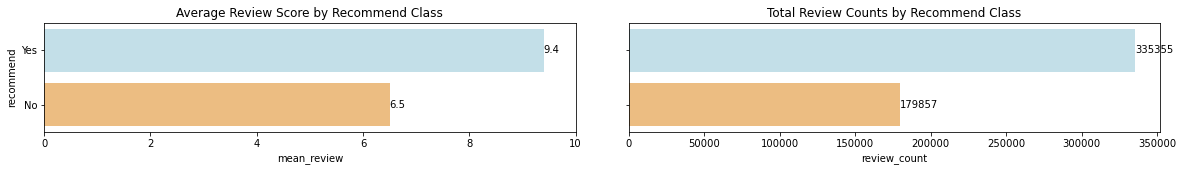

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,2), sharey=True)
fig.subplots_adjust(wspace=0.1)
sns.barplot(x=review_type_df["mean_review"], y=review_type_df["recommend"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=review_type_df["review_count"], y=review_type_df["recommend"], palette="RdYlBu_r", ax=ax2)
ax1.set_xlim([0,10])
ax2.set(ylabel=None)
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax1.set_title("Average Review Score by Recommend Class")
ax2.set_title("Total Review Counts by Recommend Class")

#### Correlation of Recommend with other variables 

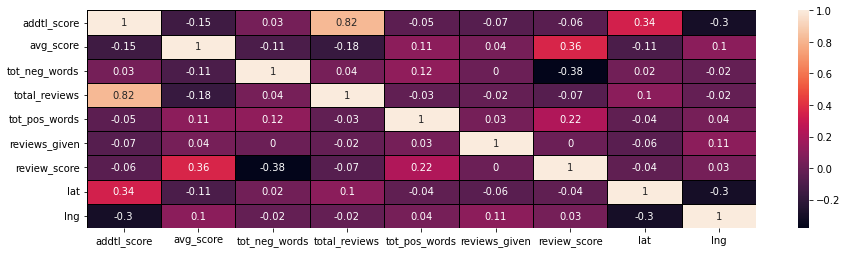

In [22]:
corr = df.corr()
corr_dp = np.round(corr, decimals=2)
corr_dp
plt.figure(figsize=(15,4))
sns.heatmap(data=corr_dp, linewidths=1, linecolor='black',annot=True);

In [23]:
corr = df.corr().iloc[6:7,:].T
corr.reset_index(inplace=True)

In [24]:
corr = corr.sort_values(by="review_score",ascending =False)
corr

index  review_score
6   review_score      1.000000
1      avg_score      0.364175
4  tot_pos_words      0.220709
8            lng      0.031746
5  reviews_given      0.002885
7            lat     -0.036463
0    addtl_score     -0.061755
3  total_reviews     -0.072920
2  tot_neg_words     -0.382552

In [25]:
corr = corr.iloc[2:,:]
corr

index  review_score
4  tot_pos_words      0.220709
8            lng      0.031746
5  reviews_given      0.002885
7            lat     -0.036463
0    addtl_score     -0.061755
3  total_reviews     -0.072920
2  tot_neg_words     -0.382552

Text(0.5, 1.0, 'Correlation of basic features with Review Score')

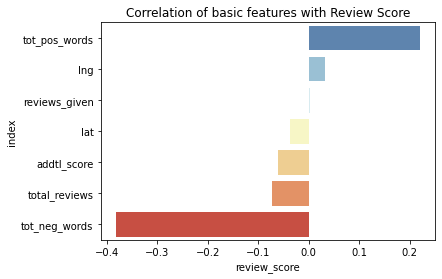

In [26]:
sns.barplot(x=corr["review_score"], y= corr["index"], palette="RdYlBu_r")
plt.title("Correlation of basic features with Review Score")

## 5.2 **Hotel locations (using Folium)** <a class="anchor" id="folium"></a>

In [27]:
df["hotel_name"].describe()

count                                         515212
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: hotel_name, dtype: object

In [28]:
# Extract Country from Hotel Name
def country_ident(st):
    last = st.split()[-1]
    if last == "Kingdom": return "United Kingdom"
    else: 
        return last
    
df["hotel_ctry"] = df["hotel_add"].apply(country_ident)

In [29]:
# Loading the unique Hotel's information to plot them on the map
temp_df = df.drop_duplicates(['hotel_name'])
len(temp_df)

map_osm = folium.Map(location=[47, 6], zoom_start=5, tiles = 'Stamen Toner' )

temp_df.apply(lambda row:folium.Marker(location=[row["lat"], row["lng"]])
                                             .add_to(map_osm), axis=1)

map_osm

## 5.3 **Most Visited Hotels (based on Review Counts)** <a class="anchor" id="mostvisited"></a>

In [30]:
pareto_df = df.pivot_table(values = "review_score", index = "hotel_name",  aggfunc=["count"])

In [31]:
pareto_df.columns = ["review_count"]

In [32]:
# sort by review count
pareto_df = pareto_df.sort_values(by="review_count",ascending = False)
pareto_df = pareto_df.reset_index().round(2)

#add column to display cumulative percentage
pareto_df['cumperc'] = pareto_df['review_count'].cumsum()/pareto_df['review_count'].sum()*100
pareto_df

hotel_name  review_count  \
0            Britannia International Hotel Canary Wharf          4789   
1                                   Strand Palace Hotel          4256   
2                  Park Plaza Westminster Bridge London          4169   
3                Copthorne Tara Hotel London Kensington          3577   
4     DoubleTree by Hilton Hotel London Tower of London          3212   
...                                                 ...           ...   
1487                              Boundary Rooms Suites            12   
1488                       Ibis Styles Milano Palmanova            12   
1489                                       Hotel Wagner            10   
1490                      Mercure Paris Porte d Orleans            10   
1491                                Hotel Gallitzinberg             8   

         cumperc  
0       0.929520  
1       1.755588  
2       2.564769  
3       3.259047  
4       3.882479  
...          ...  
1487   99.992236  
1488   99.994565  
1489   99.996506  
1490   99.998447  
1491  100.000000  

[1492 rows x 3 columns]

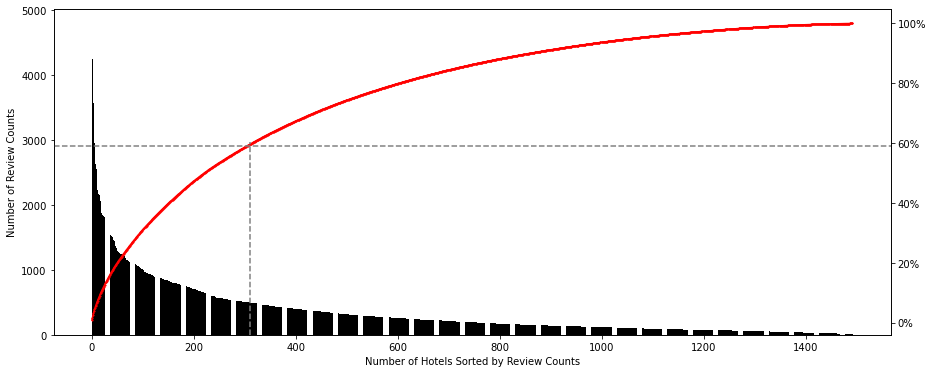

In [33]:
#https://www.statology.org/pareto-chart-python/

#define aesthetics for plot
color1 = 'black'
color2 = 'black'
color3 = 'red'
line_size = 1

#create basic bar plot
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.bar(pareto_df.index, pareto_df['review_count'], color=color1)
ax.set_xlabel("Number of Hotels Sorted by Review Counts")
ax.set_ylabel("Number of Review Counts")

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(pareto_df.index, pareto_df['cumperc'], color=color3, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#plot specific markers as line
#ax1.axvline(8.4, 0, 1, color="black", linestyle="--")

ax2.axvline(310, 0, 0.59, color="grey", linestyle="--")
ax2.axhline(59,0,1, color="grey", linestyle="--")

#display Pareto chart
plt.show()

In [34]:
pareto_df.iloc[:1050,]

hotel_name  review_count  \
0            Britannia International Hotel Canary Wharf          4789   
1                                   Strand Palace Hotel          4256   
2                  Park Plaza Westminster Bridge London          4169   
3                Copthorne Tara Hotel London Kensington          3577   
4     DoubleTree by Hilton Hotel London Tower of London          3212   
...                                                 ...           ...   
1045                          ADI Hotel Poliziano Fiera           107   
1046                              H tel Du Jeu De Paume           106   
1047                          H tel Arvor Saint Georges           106   
1048                                       H tel Vernet           106   
1049                                         Vincci Mae           106   

        cumperc  
0      0.929520  
1      1.755588  
2      2.564769  
3      3.259047  
4      3.882479  
...         ...  
1045  94.710721  
1046  94.731295  
1047  94.751869  
1048  94.772443  
1049  94.793017  

[1050 rows x 3 columns]

In [35]:
# Group the reviews by hotel name
hotel_df = df.pivot_table(values = "review_score", 
                      index = "hotel_name", 
                      aggfunc=["mean","count"])
hotel_df.head(10)

mean        count
                                                   review_score review_score
hotel_name                                                                  
11 Cadogan Gardens                                     8.845283          159
1K Hotel                                               7.861486          148
25hours Hotel beim MuseumsQuartier                     8.983309          689
41                                                     9.711650          103
45 Park Lane Dorchester Collection                     9.603571           28
88 Studios                                             8.489107          459
9Hotel Republique                                      8.743716          183
A La Villa Madame                                      8.853659           41
ABaC Restaurant Hotel Barcelona GL Monumento           8.464516           31
AC Hotel Barcelona Forum a Marriott Lifestyle H...     8.001384          289

In [36]:
# Check if there is a hotel called 41
# Confirmed via google https://41hotel.com/

In [37]:
hotel_df.columns = ["mean_review","review_count"]

In [38]:
# sort by review count
hotel_df = hotel_df.sort_values(by="review_count",ascending = False).reset_index()
hotel_df = hotel_df.round(1)

Text(0.5, 1.0, "Most Rated Hotel's Average Review Score")

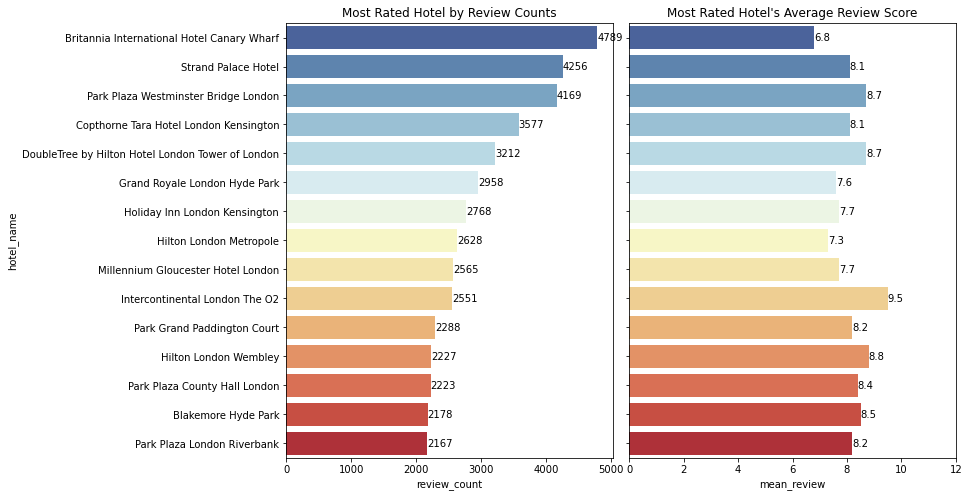

In [39]:
# Top 15 hotel by number of review counts
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8), sharey=True)
fig.subplots_adjust(wspace=0.05)
sns.barplot(x=hotel_df.head(15)["review_count"], y= hotel_df.head(15)["hotel_name"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=hotel_df.head(15)["mean_review"], y= hotel_df.head(15)["hotel_name"], palette="RdYlBu_r", ax=ax2)
#ax1.set_xlim([100,6000])
ax1.bar_label(ax1.containers[0])
ax2.set_xlim([0,12])
ax2.set(ylabel=None)
ax2.bar_label(ax2.containers[0])
ax1.set_title("Most Rated Hotel by Review Counts")
ax2.set_title("Most Rated Hotel's Average Review Score")

# mean_review 8.218 and review_count 2743.150 for these top 20
# ax2.axvline(8.4, 0, 1, color="grey", linestyle="--")

## 5.4 **Guests' Geograpical Profiling with Continent as additional Features** <a class="anchor" id="geo"></a>

In [40]:
#Countries are taken from the link below
# https://gist.github.com/Desperado/3293395#file-countryinfo-py
countries = [
{'timezones': ['Europe/Andorra'], 'code': 'AD', 'continent': 'Europe', 'name': 'Andorra', 'capital': 'Andorra la Vella'},
{'timezones': ['Asia/Kabul'], 'code': 'AF', 'continent': 'Asia', 'name': 'Afghanistan', 'capital': 'Kabul'},
{'timezones': ['America/Antigua'], 'code': 'AG', 'continent': 'North America', 'name': 'Antigua and Barbuda', 'capital': "St. John's"},
{'timezones': ['Europe/Tirane'], 'code': 'AL', 'continent': 'Europe', 'name': 'Albania', 'capital': 'Tirana'},
{'timezones': ['Asia/Yerevan'], 'code': 'AM', 'continent': 'Asia', 'name': 'Armenia', 'capital': 'Yerevan'},
{'timezones': ['Africa/Luanda'], 'code': 'AO', 'continent': 'Africa', 'name': 'Angola', 'capital': 'Luanda'},
{'timezones': ['America/Argentina/Buenos_Aires', 'America/Argentina/Cordoba', 'America/Argentina/Jujuy', 'America/Argentina/Tucuman', 'America/Argentina/Catamarca', 'America/Argentina/La_Rioja', 'America/Argentina/San_Juan', 'America/Argentina/Mendoza', 'America/Argentina/Rio_Gallegos', 'America/Argentina/Ushuaia'], 'code': 'AR', 'continent': 'South America', 'name': 'Argentina', 'capital': 'Buenos Aires'},
{'timezones': ['Europe/Vienna'], 'code': 'AT', 'continent': 'Europe', 'name': 'Austria', 'capital': 'Vienna'},
{'timezones': ['Australia/Lord_Howe', 'Australia/Hobart', 'Australia/Currie', 'Australia/Melbourne', 'Australia/Sydney', 'Australia/Broken_Hill', 'Australia/Brisbane', 'Australia/Lindeman', 'Australia/Adelaide', 'Australia/Darwin', 'Australia/Perth'], 'code': 'AU', 'continent': 'Oceania', 'name': 'Australia', 'capital': 'Canberra'},
{'timezones': ['Asia/Baku'], 'code': 'AZ', 'continent': 'Asia', 'name': 'Azerbaijan', 'capital': 'Baku'},
{'timezones': ['America/Barbados'], 'code': 'BB', 'continent': 'North America', 'name': 'Barbados', 'capital': 'Bridgetown'},
{'timezones': ['Asia/Dhaka'], 'code': 'BD', 'continent': 'Asia', 'name': 'Bangladesh', 'capital': 'Dhaka'},
{'timezones': ['Europe/Brussels'], 'code': 'BE', 'continent': 'Europe', 'name': 'Belgium', 'capital': 'Brussels'},
{'timezones': ['Africa/Ouagadougou'], 'code': 'BF', 'continent': 'Africa', 'name': 'Burkina Faso', 'capital': 'Ouagadougou'},
{'timezones': ['Europe/Sofia'], 'code': 'BG', 'continent': 'Europe', 'name': 'Bulgaria', 'capital': 'Sofia'},
{'timezones': ['Asia/Bahrain'], 'code': 'BH', 'continent': 'Asia', 'name': 'Bahrain', 'capital': 'Manama'},
{'timezones': ['Africa/Bujumbura'], 'code': 'BI', 'continent': 'Africa', 'name': 'Burundi', 'capital': 'Bujumbura'},
{'timezones': ['Africa/Porto-Novo'], 'code': 'BJ', 'continent': 'Africa', 'name': 'Benin', 'capital': 'Porto-Novo'},
{'timezones': ['Asia/Brunei'], 'code': 'BN', 'continent': 'Asia', 'name': 'Brunei Darussalam', 'capital': 'Bandar Seri Begawan'},
{'timezones': ['America/La_Paz'], 'code': 'BO', 'continent': 'South America', 'name': 'Bolivia', 'capital': 'Sucre'},
{'timezones': ['America/Noronha', 'America/Belem', 'America/Fortaleza', 'America/Recife', 'America/Araguaina', 'America/Maceio', 'America/Bahia', 'America/Sao_Paulo', 'America/Campo_Grande', 'America/Cuiaba', 'America/Porto_Velho', 'America/Boa_Vista', 'America/Manaus', 'America/Eirunepe', 'America/Rio_Branco'], 'code': 'BR', 'continent': 'South America', 'name': 'Brazil', 'capital': 'Bras\xc3\xadlia'},
{'timezones': ['America/Nassau'], 'code': 'BS', 'continent': 'North America', 'name': 'Bahamas', 'capital': 'Nassau'},
{'timezones': ['Asia/Thimphu'], 'code': 'BT', 'continent': 'Asia', 'name': 'Bhutan', 'capital': 'Thimphu'},
{'timezones': ['Africa/Gaborone'], 'code': 'BW', 'continent': 'Africa', 'name': 'Botswana', 'capital': 'Gaborone'},
{'timezones': ['Europe/Minsk'], 'code': 'BY', 'continent': 'Europe', 'name': 'Belarus', 'capital': 'Minsk'},
{'timezones': ['America/Belize'], 'code': 'BZ', 'continent': 'North America', 'name': 'Belize', 'capital': 'Belmopan'},
{'timezones': ['America/St_Johns', 'America/Halifax', 'America/Glace_Bay', 'America/Moncton', 'America/Goose_Bay', 'America/Blanc-Sablon', 'America/Montreal', 'America/Toronto', 'America/Nipigon', 'America/Thunder_Bay', 'America/Pangnirtung', 'America/Iqaluit', 'America/Atikokan', 'America/Rankin_Inlet', 'America/Winnipeg', 'America/Rainy_River', 'America/Cambridge_Bay', 'America/Regina', 'America/Swift_Current', 'America/Edmonton', 'America/Yellowknife', 'America/Inuvik', 'America/Dawson_Creek', 'America/Vancouver', 'America/Whitehorse', 'America/Dawson'], 'code': 'CA', 'continent': 'North America', 'name': 'Canada', 'capital': 'Ottawa'},
{'timezones': ['Africa/Kinshasa', 'Africa/Lubumbashi'], 'code': 'CD', 'continent': 'Africa', 'name': 'Democratic Republic of the Congo', 'capital': 'Kinshasa'},
{'timezones': ['Africa/Brazzaville'], 'code': 'CG', 'continent': 'Africa', 'name': 'Republic of the Congo', 'capital': 'Brazzaville'},
{'timezones': ['Africa/Abidjan'], 'code': 'CI', 'continent': 'Africa', 'name': "C\xc3\xb4te d'Ivoire", 'capital': 'Yamoussoukro'},
{'timezones': ['America/Santiago', 'Pacific/Easter'], 'code': 'CL', 'continent': 'South America', 'name': 'Chile', 'capital': 'Santiago'},
{'timezones': ['Africa/Douala'], 'code': 'CM', 'continent': 'Africa', 'name': 'Cameroon', 'capital': 'Yaound\xc3\xa9'},
{'timezones': ['Asia/Shanghai', 'Asia/Harbin', 'Asia/Chongqing', 'Asia/Urumqi', 'Asia/Kashgar'], 'code': 'CN', 'continent': 'Asia', 'name': "People's Republic of China", 'capital': 'Beijing'},
{'timezones': ['America/Bogota'], 'code': 'CO', 'continent': 'South America', 'name': 'Colombia', 'capital': 'Bogot\xc3\xa1'},
{'timezones': ['America/Costa_Rica'], 'code': 'CR', 'continent': 'North America', 'name': 'Costa Rica', 'capital': 'San Jos\xc3\xa9'},
{'timezones': ['America/Havana'], 'code': 'CU', 'continent': 'North America', 'name': 'Cuba', 'capital': 'Havana'},
{'timezones': ['Atlantic/Cape_Verde'], 'code': 'CV', 'continent': 'Africa', 'name': 'Cape Verde', 'capital': 'Praia'},
{'timezones': ['Asia/Nicosia'], 'code': 'CY', 'continent': 'Asia', 'name': 'Cyprus', 'capital': 'Nicosia'},
{'timezones': ['Europe/Prague'], 'code': 'CZ', 'continent': 'Europe', 'name': 'Czech Republic', 'capital': 'Prague'},
{'timezones': ['Europe/Berlin'], 'code': 'DE', 'continent': 'Europe', 'name': 'Germany', 'capital': 'Berlin'},
{'timezones': ['Africa/Djibouti'], 'code': 'DJ', 'continent': 'Africa', 'name': 'Djibouti', 'capital': 'Djibouti City'},
{'timezones': ['Europe/Copenhagen'], 'code': 'DK', 'continent': 'Europe', 'name': 'Denmark', 'capital': 'Copenhagen'},
{'timezones': ['America/Dominica'], 'code': 'DM', 'continent': 'North America', 'name': 'Dominica', 'capital': 'Roseau'},
{'timezones': ['America/Santo_Domingo'], 'code': 'DO', 'continent': 'North America', 'name': 'Dominican Republic', 'capital': 'Santo Domingo'},
{'timezones': ['America/Guayaquil', 'Pacific/Galapagos'], 'code': 'EC', 'continent': 'South America', 'name': 'Ecuador', 'capital': 'Quito'},
{'timezones': ['Europe/Tallinn'], 'code': 'EE', 'continent': 'Europe', 'name': 'Estonia', 'capital': 'Tallinn'},
{'timezones': ['Africa/Cairo'], 'code': 'EG', 'continent': 'Africa', 'name': 'Egypt', 'capital': 'Cairo'},
{'timezones': ['Africa/Asmera'], 'code': 'ER', 'continent': 'Africa', 'name': 'Eritrea', 'capital': 'Asmara'},
{'timezones': ['Africa/Addis_Ababa'], 'code': 'ET', 'continent': 'Africa', 'name': 'Ethiopia', 'capital': 'Addis Ababa'},
{'timezones': ['Europe/Helsinki'], 'code': 'FI', 'continent': 'Europe', 'name': 'Finland', 'capital': 'Helsinki'},
{'timezones': ['Pacific/Fiji'], 'code': 'FJ', 'continent': 'Oceania', 'name': 'Fiji', 'capital': 'Suva'},
{'timezones': ['Europe/Paris'], 'code': 'FR', 'continent': 'Europe', 'name': 'France', 'capital': 'Paris'},
{'timezones': ['Africa/Libreville'], 'code': 'GA', 'continent': 'Africa', 'name': 'Gabon', 'capital': 'Libreville'},
{'timezones': ['Asia/Tbilisi'], 'code': 'GE', 'continent': 'Asia', 'name': 'Georgia', 'capital': 'Tbilisi'},
{'timezones': ['Africa/Accra'], 'code': 'GH', 'continent': 'Africa', 'name': 'Ghana', 'capital': 'Accra'},
{'timezones': ['Africa/Banjul'], 'code': 'GM', 'continent': 'Africa', 'name': 'The Gambia', 'capital': 'Banjul'},
{'timezones': ['Africa/Conakry'], 'code': 'GN', 'continent': 'Africa', 'name': 'Guinea', 'capital': 'Conakry'},
{'timezones': ['Europe/Athens'], 'code': 'GR', 'continent': 'Europe', 'name': 'Greece', 'capital': 'Athens'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'continent': 'North America', 'name': 'Guatemala', 'capital': 'Guatemala City'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'continent': 'North America', 'name': 'Haiti', 'capital': 'Port-au-Prince'},
{'timezones': ['Africa/Bissau'], 'code': 'GW', 'continent': 'Africa', 'name': 'Guinea-Bissau', 'capital': 'Bissau'},
{'timezones': ['America/Guyana'], 'code': 'GY', 'continent': 'South America', 'name': 'Guyana', 'capital': 'Georgetown'},
{'timezones': ['America/Tegucigalpa'], 'code': 'HN', 'continent': 'North America', 'name': 'Honduras', 'capital': 'Tegucigalpa'},
{'timezones': ['Europe/Budapest'], 'code': 'HU', 'continent': 'Europe', 'name': 'Hungary', 'capital': 'Budapest'},
{'timezones': ['Asia/Jakarta', 'Asia/Pontianak', 'Asia/Makassar', 'Asia/Jayapura'], 'code': 'ID', 'continent': 'Asia', 'name': 'Indonesia', 'capital': 'Jakarta'},
{'timezones': ['Europe/Dublin'], 'code': 'IE', 'continent': 'Europe', 'name': 'Republic of Ireland', 'capital': 'Dublin'},
{'timezones': ['Asia/Jerusalem'], 'code': 'IL', 'continent': 'Asia', 'name': 'Israel', 'capital': 'Jerusalem'},
{'timezones': ['Asia/Calcutta'], 'code': 'IN', 'continent': 'Asia', 'name': 'India', 'capital': 'New Delhi'},
{'timezones': ['Asia/Baghdad'], 'code': 'IQ', 'continent': 'Asia', 'name': 'Iraq', 'capital': 'Baghdad'},
{'timezones': ['Asia/Tehran'], 'code': 'IR', 'continent': 'Asia', 'name': 'Iran', 'capital': 'Tehran'},
{'timezones': ['Atlantic/Reykjavik'], 'code': 'IS', 'continent': 'Europe', 'name': 'Iceland', 'capital': 'Reykjav\xc3\xadk'},
{'timezones': ['Europe/Rome'], 'code': 'IT', 'continent': 'Europe', 'name': 'Italy', 'capital': 'Rome'},
{'timezones': ['America/Jamaica'], 'code': 'JM', 'continent': 'North America', 'name': 'Jamaica', 'capital': 'Kingston'},
{'timezones': ['Asia/Amman'], 'code': 'JO', 'continent': 'Asia', 'name': 'Jordan', 'capital': 'Amman'},
{'timezones': ['Asia/Tokyo'], 'code': 'JP', 'continent': 'Asia', 'name': 'Japan', 'capital': 'Tokyo'},
{'timezones': ['Africa/Nairobi'], 'code': 'KE', 'continent': 'Africa', 'name': 'Kenya', 'capital': 'Nairobi'},
{'timezones': ['Asia/Bishkek'], 'code': 'KG', 'continent': 'Asia', 'name': 'Kyrgyzstan', 'capital': 'Bishkek'},
{'timezones': ['Pacific/Tarawa', 'Pacific/Enderbury', 'Pacific/Kiritimati'], 'code': 'KI', 'continent': 'Oceania', 'name': 'Kiribati', 'capital': 'Tarawa'},
{'timezones': ['Asia/Pyongyang'], 'code': 'KP', 'continent': 'Asia', 'name': 'North Korea', 'capital': 'Pyongyang'},
{'timezones': ['Asia/Seoul'], 'code': 'KR', 'continent': 'Asia', 'name': 'South Korea', 'capital': 'Seoul'},
{'timezones': ['Asia/Kuwait'], 'code': 'KW', 'continent': 'Asia', 'name': 'Kuwait', 'capital': 'Kuwait City'},
{'timezones': ['Asia/Beirut'], 'code': 'LB', 'continent': 'Asia', 'name': 'Lebanon', 'capital': 'Beirut'},
{'timezones': ['Europe/Vaduz'], 'code': 'LI', 'continent': 'Europe', 'name': 'Liechtenstein', 'capital': 'Vaduz'},
{'timezones': ['Africa/Monrovia'], 'code': 'LR', 'continent': 'Africa', 'name': 'Liberia', 'capital': 'Monrovia'},
{'timezones': ['Africa/Maseru'], 'code': 'LS', 'continent': 'Africa', 'name': 'Lesotho', 'capital': 'Maseru'},
{'timezones': ['Europe/Vilnius'], 'code': 'LT', 'continent': 'Europe', 'name': 'Lithuania', 'capital': 'Vilnius'},
{'timezones': ['Europe/Luxembourg'], 'code': 'LU', 'continent': 'Europe', 'name': 'Luxembourg', 'capital': 'Luxembourg City'},
{'timezones': ['Europe/Riga'], 'code': 'LV', 'continent': 'Europe', 'name': 'Latvia', 'capital': 'Riga'},
{'timezones': ['Africa/Tripoli'], 'code': 'LY', 'continent': 'Africa', 'name': 'Libya', 'capital': 'Tripoli'},
{'timezones': ['Indian/Antananarivo'], 'code': 'MG', 'continent': 'Africa', 'name': 'Madagascar', 'capital': 'Antananarivo'},
{'timezones': ['Pacific/Majuro', 'Pacific/Kwajalein'], 'code': 'MH', 'continent': 'Oceania', 'name': 'Marshall Islands', 'capital': 'Majuro'},
{'timezones': ['Europe/Skopje'], 'code': 'MK', 'continent': 'Europe', 'name': 'Macedonia', 'capital': 'Skopje'},
{'timezones': ['Africa/Bamako'], 'code': 'ML', 'continent': 'Africa', 'name': 'Mali', 'capital': 'Bamako'},
{'timezones': ['Asia/Rangoon'], 'code': 'MM', 'continent': 'Asia', 'name': 'Myanmar', 'capital': 'Naypyidaw'},
{'timezones': ['Asia/Ulaanbaatar', 'Asia/Hovd', 'Asia/Choibalsan'], 'code': 'MN', 'continent': 'Asia', 'name': 'Mongolia', 'capital': 'Ulaanbaatar'},
{'timezones': ['Africa/Nouakchott'], 'code': 'MR', 'continent': 'Africa', 'name': 'Mauritania', 'capital': 'Nouakchott'},
{'timezones': ['Europe/Malta'], 'code': 'MT', 'continent': 'Europe', 'name': 'Malta', 'capital': 'Valletta'},
{'timezones': ['Indian/Mauritius'], 'code': 'MU', 'continent': 'Africa', 'name': 'Mauritius', 'capital': 'Port Louis'},
{'timezones': ['Indian/Maldives'], 'code': 'MV', 'continent': 'Asia', 'name': 'Maldives', 'capital': 'Mal\xc3\xa9'},
{'timezones': ['Africa/Blantyre'], 'code': 'MW', 'continent': 'Africa', 'name': 'Malawi', 'capital': 'Lilongwe'},
{'timezones': ['America/Mexico_City', 'America/Cancun', 'America/Merida', 'America/Monterrey', 'America/Mazatlan', 'America/Chihuahua', 'America/Hermosillo', 'America/Tijuana'], 'code': 'MX', 'continent': 'North America', 'name': 'Mexico', 'capital': 'Mexico City'},
{'timezones': ['Asia/Kuala_Lumpur', 'Asia/Kuching'], 'code': 'MY', 'continent': 'Asia', 'name': 'Malaysia', 'capital': 'Kuala Lumpur'},
{'timezones': ['Africa/Maputo'], 'code': 'MZ', 'continent': 'Africa', 'name': 'Mozambique', 'capital': 'Maputo'},
{'timezones': ['Africa/Windhoek'], 'code': 'NA', 'continent': 'Africa', 'name': 'Namibia', 'capital': 'Windhoek'},
{'timezones': ['Africa/Niamey'], 'code': 'NE', 'continent': 'Africa', 'name': 'Niger', 'capital': 'Niamey'},
{'timezones': ['Africa/Lagos'], 'code': 'NG', 'continent': 'Africa', 'name': 'Nigeria', 'capital': 'Abuja'},
{'timezones': ['America/Managua'], 'code': 'NI', 'continent': 'North America', 'name': 'Nicaragua', 'capital': 'Managua'},
{'timezones': ['Europe/Amsterdam'], 'code': 'NL', 'continent': 'Europe', 'name': 'Kingdom of the Netherlands', 'capital': 'Amsterdam'},
{'timezones': ['Europe/Oslo'], 'code': 'NO', 'continent': 'Europe', 'name': 'Norway', 'capital': 'Oslo'},
{'timezones': ['Asia/Katmandu'], 'code': 'NP', 'continent': 'Asia', 'name': 'Nepal', 'capital': 'Kathmandu'},
{'timezones': ['Pacific/Nauru'], 'code': 'NR', 'continent': 'Oceania', 'name': 'Nauru', 'capital': 'Yaren'},
{'timezones': ['Pacific/Auckland', 'Pacific/Chatham'], 'code': 'NZ', 'continent': 'Oceania', 'name': 'New Zealand', 'capital': 'Wellington'},
{'timezones': ['Asia/Muscat'], 'code': 'OM', 'continent': 'Asia', 'name': 'Oman', 'capital': 'Muscat'},
{'timezones': ['America/Panama'], 'code': 'PA', 'continent': 'North America', 'name': 'Panama', 'capital': 'Panama City'},
{'timezones': ['America/Lima'], 'code': 'PE', 'continent': 'South America', 'name': 'Peru', 'capital': 'Lima'},
{'timezones': ['Pacific/Port_Moresby'], 'code': 'PG', 'continent': 'Oceania', 'name': 'Papua New Guinea', 'capital': 'Port Moresby'},
{'timezones': ['Asia/Manila'], 'code': 'PH', 'continent': 'Asia', 'name': 'Philippines', 'capital': 'Manila'},
{'timezones': ['Asia/Karachi'], 'code': 'PK', 'continent': 'Asia', 'name': 'Pakistan', 'capital': 'Islamabad'},
{'timezones': ['Europe/Warsaw'], 'code': 'PL', 'continent': 'Europe', 'name': 'Poland', 'capital': 'Warsaw'},
{'timezones': ['Europe/Lisbon', 'Atlantic/Madeira', 'Atlantic/Azores'], 'code': 'PT', 'continent': 'Europe', 'name': 'Portugal', 'capital': 'Lisbon'},
{'timezones': ['Pacific/Palau'], 'code': 'PW', 'continent': 'Oceania', 'name': 'Palau', 'capital': 'Ngerulmud'},
{'timezones': ['America/Asuncion'], 'code': 'PY', 'continent': 'South America', 'name': 'Paraguay', 'capital': 'Asunci\xc3\xb3n'},
{'timezones': ['Asia/Qatar'], 'code': 'QA', 'continent': 'Asia', 'name': 'Qatar', 'capital': 'Doha'},
{'timezones': ['Europe/Bucharest'], 'code': 'RO', 'continent': 'Europe', 'name': 'Romania', 'capital': 'Bucharest'},
{'timezones': ['Europe/Kaliningrad', 'Europe/Moscow', 'Europe/Volgograd', 'Europe/Samara', 'Asia/Yekaterinburg', 'Asia/Omsk', 'Asia/Novosibirsk', 'Asia/Krasnoyarsk', 'Asia/Irkutsk', 'Asia/Yakutsk', 'Asia/Vladivostok', 'Asia/Sakhalin', 'Asia/Magadan', 'Asia/Kamchatka', 'Asia/Anadyr'], 'code': 'RU', 'continent': 'Europe', 'name': 'Russia', 'capital': 'Moscow'},
{'timezones': ['Africa/Kigali'], 'code': 'RW', 'continent': 'Africa', 'name': 'Rwanda', 'capital': 'Kigali'},
{'timezones': ['Asia/Riyadh'], 'code': 'SA', 'continent': 'Asia', 'name': 'Saudi Arabia', 'capital': 'Riyadh'},
{'timezones': ['Pacific/Guadalcanal'], 'code': 'SB', 'continent': 'Oceania', 'name': 'Solomon Islands', 'capital': 'Honiara'},
{'timezones': ['Indian/Mahe'], 'code': 'SC', 'continent': 'Africa', 'name': 'Seychelles', 'capital': 'Victoria'},
{'timezones': ['Africa/Khartoum'], 'code': 'SD', 'continent': 'Africa', 'name': 'Sudan', 'capital': 'Khartoum'},
{'timezones': ['Europe/Stockholm'], 'code': 'SE', 'continent': 'Europe', 'name': 'Sweden', 'capital': 'Stockholm'},
{'timezones': ['Asia/Singapore'], 'code': 'SG', 'continent': 'Asia', 'name': 'Singapore', 'capital': 'Singapore'},
{'timezones': ['Europe/Ljubljana'], 'code': 'SI', 'continent': 'Europe', 'name': 'Slovenia', 'capital': 'Ljubljana'},
{'timezones': ['Europe/Bratislava'], 'code': 'SK', 'continent': 'Europe', 'name': 'Slovakia', 'capital': 'Bratislava'},
{'timezones': ['Africa/Freetown'], 'code': 'SL', 'continent': 'Africa', 'name': 'Sierra Leone', 'capital': 'Freetown'},
{'timezones': ['Europe/San_Marino'], 'code': 'SM', 'continent': 'Europe', 'name': 'San Marino', 'capital': 'San Marino'},
{'timezones': ['Africa/Dakar'], 'code': 'SN', 'continent': 'Africa', 'name': 'Senegal', 'capital': 'Dakar'},
{'timezones': ['Africa/Mogadishu'], 'code': 'SO', 'continent': 'Africa', 'name': 'Somalia', 'capital': 'Mogadishu'},
{'timezones': ['America/Paramaribo'], 'code': 'SR', 'continent': 'South America', 'name': 'Suriname', 'capital': 'Paramaribo'},
{'timezones': ['Africa/Sao_Tome'], 'code': 'ST', 'continent': 'Africa', 'name': 'S\xc3\xa3o Tom\xc3\xa9 and Pr\xc3\xadncipe', 'capital': 'S\xc3\xa3o Tom\xc3\xa9'},
{'timezones': ['Asia/Damascus'], 'code': 'SY', 'continent': 'Asia', 'name': 'Syria', 'capital': 'Damascus'},
{'timezones': ['Africa/Lome'], 'code': 'TG', 'continent': 'Africa', 'name': 'Togo', 'capital': 'Lom\xc3\xa9'},
{'timezones': ['Asia/Bangkok'], 'code': 'TH', 'continent': 'Asia', 'name': 'Thailand', 'capital': 'Bangkok'},
{'timezones': ['Asia/Dushanbe'], 'code': 'TJ', 'continent': 'Asia', 'name': 'Tajikistan', 'capital': 'Dushanbe'},
{'timezones': ['Asia/Ashgabat'], 'code': 'TM', 'continent': 'Asia', 'name': 'Turkmenistan', 'capital': 'Ashgabat'},
{'timezones': ['Africa/Tunis'], 'code': 'TN', 'continent': 'Africa', 'name': 'Tunisia', 'capital': 'Tunis'},
{'timezones': ['Pacific/Tongatapu'], 'code': 'TO', 'continent': 'Oceania', 'name': 'Tonga', 'capital': 'Nuku\xca\xbbalofa'},
{'timezones': ['Europe/Istanbul'], 'code': 'TR', 'continent': 'Asia', 'name': 'Turkey', 'capital': 'Ankara'},
{'timezones': ['America/Port_of_Spain'], 'code': 'TT', 'continent': 'North America', 'name': 'Trinidad and Tobago', 'capital': 'Port of Spain'},
{'timezones': ['Pacific/Funafuti'], 'code': 'TV', 'continent': 'Oceania', 'name': 'Tuvalu', 'capital': 'Funafuti'},
{'timezones': ['Africa/Dar_es_Salaam'], 'code': 'TZ', 'continent': 'Africa', 'name': 'Tanzania', 'capital': 'Dodoma'},
{'timezones': ['Europe/Kiev', 'Europe/Uzhgorod', 'Europe/Zaporozhye', 'Europe/Simferopol'], 'code': 'UA', 'continent': 'Europe', 'name': 'Ukraine', 'capital': 'Kiev'},
{'timezones': ['Africa/Kampala'], 'code': 'UG', 'continent': 'Africa', 'name': 'Uganda', 'capital': 'Kampala'},
{'timezones': ['America/New_York', 'America/Detroit', 'America/Kentucky/Louisville', 'America/Kentucky/Monticello', 'America/Indiana/Indianapolis', 'America/Indiana/Marengo', 'America/Indiana/Knox', 'America/Indiana/Vevay', 'America/Chicago', 'America/Indiana/Vincennes', 'America/Indiana/Petersburg', 'America/Menominee', 'America/North_Dakota/Center', 'America/North_Dakota/New_Salem', 'America/Denver', 'America/Boise', 'America/Shiprock', 'America/Phoenix', 'America/Los_Angeles', 'America/Anchorage', 'America/Juneau', 'America/Yakutat', 'America/Nome', 'America/Adak', 'Pacific/Honolulu'], 'code': 'US', 'continent': 'North America', 'name': 'United States', 'capital': 'Washington, D.C.'},
{'timezones': ['America/Montevideo'], 'code': 'UY', 'continent': 'South America', 'name': 'Uruguay', 'capital': 'Montevideo'},
{'timezones': ['Asia/Samarkand', 'Asia/Tashkent'], 'code': 'UZ', 'continent': 'Asia', 'name': 'Uzbekistan', 'capital': 'Tashkent'},
{'timezones': ['Europe/Vatican'], 'code': 'VA', 'continent': 'Europe', 'name': 'Vatican City', 'capital': 'Vatican City'},
{'timezones': ['America/Caracas'], 'code': 'VE', 'continent': 'South America', 'name': 'Venezuela', 'capital': 'Caracas'},
{'timezones': ['Asia/Saigon'], 'code': 'VN', 'continent': 'Asia', 'name': 'Vietnam', 'capital': 'Hanoi'},
{'timezones': ['Pacific/Efate'], 'code': 'VU', 'continent': 'Oceania', 'name': 'Vanuatu', 'capital': 'Port Vila'},
{'timezones': ['Asia/Aden'], 'code': 'YE', 'continent': 'Asia', 'name': 'Yemen', 'capital': "Sana'a"},
{'timezones': ['Africa/Lusaka'], 'code': 'ZM', 'continent': 'Africa', 'name': 'Zambia', 'capital': 'Lusaka'},
{'timezones': ['Africa/Harare'], 'code': 'ZW', 'continent': 'Africa', 'name': 'Zimbabwe', 'capital': 'Harare'},
{'timezones': ['Africa/Algiers'], 'code': 'DZ', 'continent': 'Africa', 'name': 'Algeria', 'capital': 'Algiers'},
{'timezones': ['Europe/Sarajevo'], 'code': 'BA', 'continent': 'Europe', 'name': 'Bosnia and Herzegovina', 'capital': 'Sarajevo'},
{'timezones': ['Asia/Phnom_Penh'], 'code': 'KH', 'continent': 'Asia', 'name': 'Cambodia', 'capital': 'Phnom Penh'},
{'timezones': ['Africa/Bangui'], 'code': 'CF', 'continent': 'Africa', 'name': 'Central African Republic', 'capital': 'Bangui'},
{'timezones': ['Africa/Ndjamena'], 'code': 'TD', 'continent': 'Africa', 'name': 'Chad', 'capital': "N'Djamena"},
{'timezones': ['Indian/Comoro'], 'code': 'KM', 'continent': 'Africa', 'name': 'Comoros', 'capital': 'Moroni'},
{'timezones': ['Europe/Zagreb'], 'code': 'HR', 'continent': 'Europe', 'name': 'Croatia', 'capital': 'Zagreb'},
{'timezones': ['Asia/Dili'], 'code': 'TL', 'continent': 'Asia', 'name': 'East Timor', 'capital': 'Dili'},
{'timezones': ['America/El_Salvador'], 'code': 'SV', 'continent': 'North America', 'name': 'El Salvador', 'capital': 'San Salvador'},
{'timezones': ['Africa/Malabo'], 'code': 'GQ', 'continent': 'Africa', 'name': 'Equatorial Guinea', 'capital': 'Malabo'},
{'timezones': ['America/Grenada'], 'code': 'GD', 'continent': 'North America', 'name': 'Grenada', 'capital': "St. George's"},
{'timezones': ['Asia/Almaty', 'Asia/Qyzylorda', 'Asia/Aqtobe', 'Asia/Aqtau', 'Asia/Oral'], 'code': 'KZ', 'continent': 'Asia', 'name': 'Kazakhstan', 'capital': 'Astana'},
{'timezones': ['Asia/Vientiane'], 'code': 'LA', 'continent': 'Asia', 'name': 'Laos', 'capital': 'Vientiane'},
{'timezones': ['Pacific/Truk', 'Pacific/Ponape', 'Pacific/Kosrae'], 'code': 'FM', 'continent': 'Oceania', 'name': 'Federated States of Micronesia', 'capital': 'Palikir'},
{'timezones': ['Europe/Chisinau'], 'code': 'MD', 'continent': 'Europe', 'name': 'Moldova', 'capital': 'Chi\xc5\x9fin\xc4\x83u'},
{'timezones': ['Europe/Monaco'], 'code': 'MC', 'continent': 'Europe', 'name': 'Monaco', 'capital': 'Monaco'},
{'timezones': ['Europe/Podgorica'], 'code': 'ME', 'continent': 'Europe', 'name': 'Montenegro', 'capital': 'Podgorica'},
{'timezones': ['Africa/Casablanca'], 'code': 'MA', 'continent': 'Africa', 'name': 'Morocco', 'capital': 'Rabat'},
{'timezones': ['America/St_Kitts'], 'code': 'KN', 'continent': 'North America', 'name': 'Saint Kitts and Nevis', 'capital': 'Basseterre'},
{'timezones': ['America/St_Lucia'], 'code': 'LC', 'continent': 'North America', 'name': 'Saint Lucia', 'capital': 'Castries'},
{'timezones': ['America/St_Vincent'], 'code': 'VC', 'continent': 'North America', 'name': 'Saint Vincent and the Grenadines', 'capital': 'Kingstown'},
{'timezones': ['Pacific/Apia'], 'code': 'WS', 'continent': 'Oceania', 'name': 'Samoa', 'capital': 'Apia'},
{'timezones': ['Europe/Belgrade'], 'code': 'RS', 'continent': 'Europe', 'name': 'Serbia', 'capital': 'Belgrade'},
{'timezones': ['Africa/Johannesburg'], 'code': 'ZA', 'continent': 'Africa', 'name': 'South Africa', 'capital': 'Pretoria'},
{'timezones': ['Europe/Madrid', 'Africa/Ceuta', 'Atlantic/Canary'], 'code': 'ES', 'continent': 'Europe', 'name': 'Spain', 'capital': 'Madrid'},
{'timezones': ['Asia/Colombo'], 'code': 'LK', 'continent': 'Asia', 'name': 'Sri Lanka', 'capital': 'Sri Jayewardenepura Kotte'},
{'timezones': ['Africa/Mbabane'], 'code': 'SZ', 'continent': 'Africa', 'name': 'Swaziland', 'capital': 'Mbabane'},
{'timezones': ['Europe/Zurich'], 'code': 'CH', 'continent': 'Europe', 'name': 'Switzerland', 'capital': 'Bern'},
{'timezones': ['Asia/Dubai'], 'code': 'AE', 'continent': 'Asia', 'name': 'United Arab Emirates', 'capital': 'Abu Dhabi'},
{'timezones': ['Europe/London'], 'code': 'GB', 'continent': 'Europe', 'name': 'United Kingdom', 'capital': 'London'},
]

In [41]:
europe_list = []
for j in range(len(countries)):
    if countries[j]['continent'] == 'Europe':
        europe_list.append(countries[j]['name'])

asia_list = []
for j in range(len(countries)):
    if countries[j]['continent'] == 'Asia':
        asia_list.append(countries[j]['name'])

northamerica_list = []
for j in range(len(countries)):
    if countries[j]['continent'] == 'North America':
        northamerica_list.append(countries[j]['name'])

southamerica_list = []
for j in range(len(countries)):
    if countries[j]['continent'] == 'South America':
        southamerica_list.append(countries[j]['name'])
        
oceania_list = []
for j in range(len(countries)):
    if countries[j]['continent'] == 'Oceania':
        oceania_list.append(countries[j]['name'])

africa_list = []
for j in range(len(countries)):
    if countries[j]['continent'] == 'Africa':
        africa_list.append(countries[j]['name'])

In [42]:
#Changing some of components in the list due to conveinence like United States = United States of America
northamerica_list[17] = 'United States of America'
europe_list[14] = 'Ireland'        
europe_list[23] = 'Netherlands'
asia_list[7] = 'China'  

In [43]:
# There are empty chracters in the beginnig and in the end of Reviewer_Nationality
df['reviewer_nationality'] = df['reviewer_nationality'].map(lambda x: x[1:-1])

In [44]:
#Adding continent column to data
continent = []
for k in range(len(df)):
    if df['reviewer_nationality'][k] in europe_list:
        continent.append("Europe")
    elif df['reviewer_nationality'][k] in asia_list:
        continent.append("Asia")
    elif df['reviewer_nationality'][k] in africa_list:
        continent.append("Africa")
    elif df['reviewer_nationality'][k] in oceania_list:
        continent.append("Oceania")
    elif df['reviewer_nationality'][k] in northamerica_list:
        continent.append("North America")
    elif df['reviewer_nationality'][k] in southamerica_list:
        continent.append("South America")
    else:
        continent.append("Other")

continent = pd.Series(continent)
df['reviewer_continent'] = continent

In [45]:
df.isnull().sum()

hotel_add               0
addtl_score             0
review_date             0
avg_score               0
hotel_name              0
reviewer_nationality    0
neg_review              0
tot_neg_words           0
total_reviews           0
pos_review              0
tot_pos_words           0
reviews_given           0
review_score            0
tags                    0
lat                     0
lng                     0
recommend               0
hotel_ctry              0
reviewer_continent      0
dtype: int64

In [46]:
df["reviewer_continent"].describe()

count     515212
unique         7
top       Europe
freq      356581
Name: reviewer_continent, dtype: object

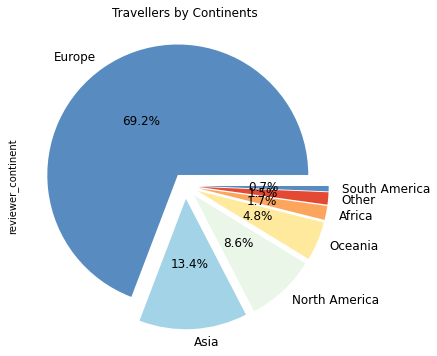

In [47]:
##Reviewer Continent Distribution
#define Seaborn color palette to use
colors = sns.color_palette('RdYlBu_r')[0:7]

plt.figure(figsize=(12,6))
df.reviewer_continent.value_counts().plot(kind='pie',autopct='%1.1f%%', 
                                          colors = colors, fontsize=12, explode=[0.1]*7, pctdistance=0.5)
plt.title('Travellers by Continents')
plt.show()

In [48]:
# Group the reviews by continent
continent_df = df.pivot_table(values = "review_score", 
                      index = "reviewer_continent", 
                      aggfunc=["mean","count"])
continent_df.sample(3)

mean        count
                   review_score review_score
reviewer_continent                          
South America          8.435853         3400
Europe                 8.408091       356581
Other                  8.207272         7811

In [49]:
continent_df.columns = ["mean_review","review_count"]

In [50]:
continent_df = continent_df.sort_values(by="review_count",ascending = False)
continent_df = continent_df.reset_index().round(1)
continent_df

reviewer_continent  mean_review  review_count
0             Europe          8.4        356581
1               Asia          8.1         69014
2      North America          8.7         44561
3            Oceania          8.6         24923
4             Africa          8.2          8922
5              Other          8.2          7811
6      South America          8.4          3400

[Text(0, 0.5, '')]

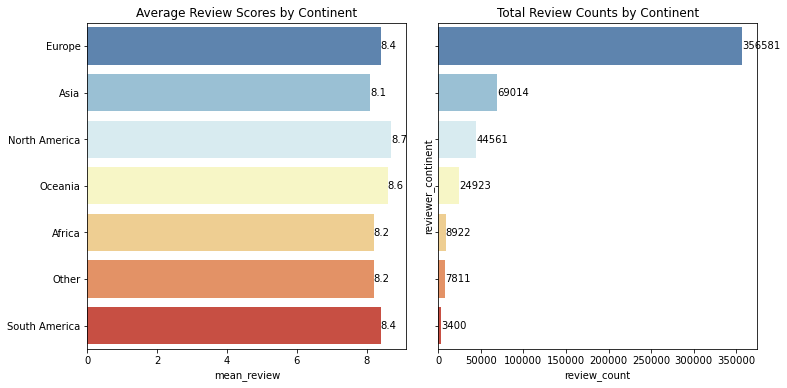

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6), sharey=True)
fig.subplots_adjust(wspace=0.1)
sns.barplot(x=continent_df["mean_review"], y= continent_df["reviewer_continent"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=continent_df["review_count"], y= continent_df["reviewer_continent"], palette="RdYlBu_r", ax=ax2)
#ax1.axvline(8.4, 0, 1, color="grey", linestyle="--")
#ax1.set_xlim([7.5,9])
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax1.set_title("Average Review Scores by Continent")
ax2.set_title("Total Review Counts by Continent")
ax1.set(ylabel=None)


#### Review_Nationality

In [52]:
df["reviewer_nationality"].describe()

count             515212
unique               227
top       United Kingdom
freq              245110
Name: reviewer_nationality, dtype: object

In [53]:
df["reviewer_nationality"].value_counts().head(10)

United Kingdom              245110
United States of America     35349
Australia                    21648
Ireland                      14814
United Arab Emirates         10229
Saudi Arabia                  8940
Netherlands                   8757
Switzerland                   8669
Germany                       7929
Canada                        7883
Name: reviewer_nationality, dtype: int64

In [54]:
# Given the continent loped sided, let's split between European and non European
europe_df = df[df["reviewer_continent"] == "Europe"]
non_europe_df = df[df["reviewer_continent"] != "Europe"]

#### For European Continent 

In [55]:
# Group the reviews by nationality
nationality_eur_df = europe_df.pivot_table(values = "review_score", 
                      index = "reviewer_nationality", 
                      aggfunc=["mean","count"])
nationality_eur_df.sample(3)

mean        count
                     review_score review_score
reviewer_nationality                          
Iceland                  8.463130          933
Finland                  8.290536         1828
Czech Republic           8.289442         2311

In [56]:
nationality_eur_df.columns = ["mean_review","review_count"]

In [57]:
nationality_eur_df = nationality_eur_df.sort_values(by="review_count",ascending = False)
nationality_eur_df = nationality_eur_df.reset_index().round(1)
nationality_eur_df.head(1)

reviewer_nationality  mean_review  review_count
0       United Kingdom          8.5        245110

Text(0.5, 1.0, 'Total Review Counts for European Nationalities')

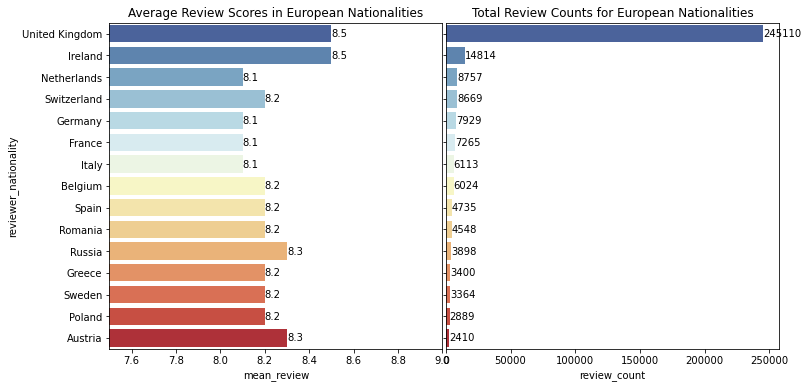

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6), sharey=True)
fig.subplots_adjust(wspace=0.01)
sns.barplot(x=nationality_eur_df.head(15)["mean_review"], y= nationality_eur_df.head(15)["reviewer_nationality"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=nationality_eur_df.head(15)["review_count"], y= nationality_eur_df.head(15)["reviewer_nationality"], palette="RdYlBu_r", ax=ax2)
#ax1.axvline(8.4, 0, 1, color="grey", linestyle="--")
ax1.set_xlim([7.5,9])
ax1.bar_label(ax1.containers[0])
ax2.set(ylabel=None)
ax2.bar_label(ax2.containers[0])
ax1.set_title("Average Review Scores in European Nationalities")
ax2.set_title("Total Review Counts for European Nationalities")

#### For Non European Continent: 

In [59]:
# Group the reviews by nationality
nationality_non_eur_df = non_europe_df.pivot_table(values = "review_score", 
                      index = "reviewer_nationality", 
                      aggfunc=["mean","count"])
nationality_non_eur_df.sample(3)

mean        count
                     review_score review_score
reviewer_nationality                          
New Caledonia            8.590000           10
Bolivia                  8.716667           18
Antigua Barbuda          8.050000           14

In [60]:
nationality_non_eur_df.columns = ["mean_review","review_count"]

In [61]:
nationality_non_eur_df = nationality_non_eur_df.sort_values(by="review_count",ascending = False)
nationality_non_eur_df = nationality_non_eur_df.reset_index().round(1)
nationality_non_eur_df.head(1)

reviewer_nationality  mean_review  review_count
0  United States of America          8.8         35349

Text(0.5, 1.0, 'Total Review Counts for Non European Nationalities')

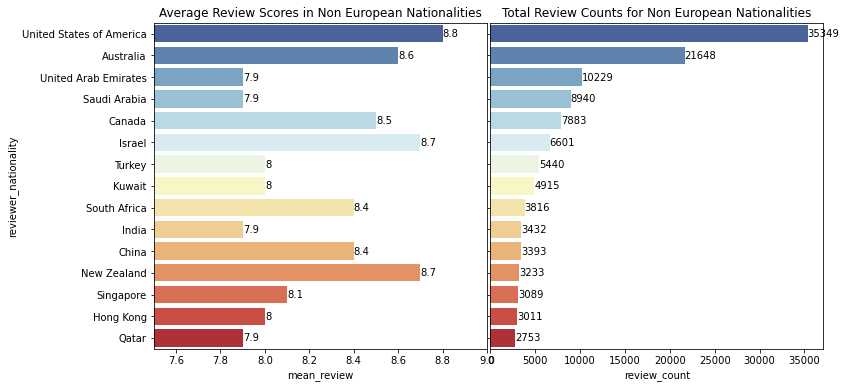

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6), sharey=True)
fig.subplots_adjust(wspace=0.01)
sns.barplot(x=nationality_non_eur_df.head(15)["mean_review"], y= nationality_non_eur_df.head(15)["reviewer_nationality"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=nationality_non_eur_df.head(15)["review_count"], y= nationality_non_eur_df.head(15)["reviewer_nationality"], palette="RdYlBu_r", ax=ax2)
#ax1.axvline(8.4, 0, 1, color="grey", linestyle="--")
ax1.set_xlim([7.5,9])
ax1.bar_label(ax1.containers[0])
ax2.set(ylabel=None)
ax2.bar_label(ax2.containers[0])
ax1.set_title("Average Review Scores in Non European Nationalities")
ax2.set_title("Total Review Counts for Non European Nationalities")

## 5.5 **Guests' Review Score through different Review Periods** <a class="anchor" id="period"></a>

In [63]:
# Feature Extraction
df['month'] = pd.to_datetime(df['review_date']).dt.month.astype(int)
df['year'] = pd.to_datetime(df['review_date']).dt.year.astype(int)
df['day'] = pd.to_datetime(df['review_date']).dt.day.astype(int)

In [64]:
# Group the reviews by Review Month
review_month_df = df.pivot_table(values = "review_score", 
                      index = "month", 
                      aggfunc=["mean","count"])
review_month_df.sample(3)

mean        count
      review_score review_score
month                          
10        8.262253        43773
1         8.485402        42121
4         8.431745        42857

In [65]:
review_month_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 12
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (mean, review_score)   12 non-null     float64
 1   (count, review_score)  12 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 288.0 bytes


In [66]:
review_month_df.columns = ["mean_review","review_count"]

In [67]:
review_month_df = review_month_df.reset_index()

In [68]:
review_month_df["month"] = review_month_df["month"].astype(int)
review_month_df = review_month_df.sort_values(by="month",ascending = True)
review_month_df["month"] = review_month_df["month"].astype(str)
review_month_df = review_month_df.round(1)
review_month_df

month  mean_review  review_count
0      1          8.5         42121
1      2          8.5         38337
2      3          8.5         41075
3      4          8.4         42857
4      5          8.4         46457
5      6          8.4         42856
6      7          8.3         49267
7      8          8.4         50615
8      9          8.3         42341
9     10          8.3         43773
10    11          8.3         35939
11    12          8.4         39574

Text(0.5, 1.0, 'Total Review Counts by Months')

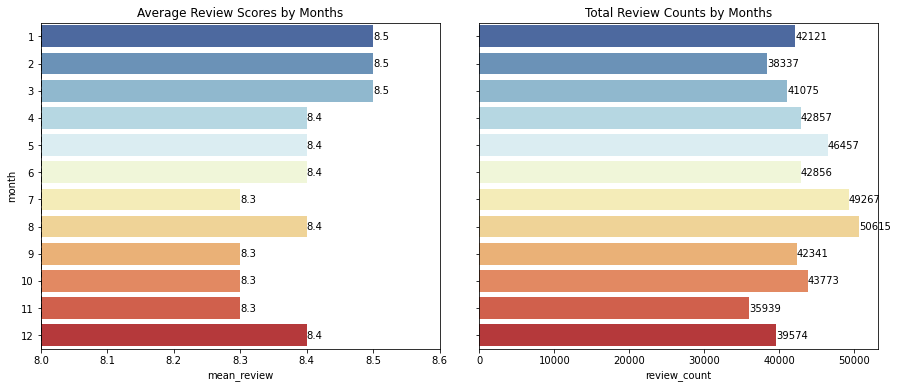

In [69]:
# AVERAGE REVIEW SCORE & REVIEW COUNTS BY MONTH
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6), sharey=True)
fig.subplots_adjust(wspace=0.1)
sns.barplot(x=review_month_df["mean_review"], y= review_month_df["month"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=review_month_df["review_count"], y= review_month_df["month"], palette="RdYlBu_r", ax=ax2)
ax1.axvline(8, 0, 1, color="black", linestyle="--")
ax1.set_xlim([8,8.6])
ax2.set(ylabel=None)
#ax2.set_xlim([0,6000])
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax1.set_title("Average Review Scores by Months")
ax2.set_title("Total Review Counts by Months")

In [70]:
df.head(1)

hotel_add  addtl_score review_date  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194  2017-08-03   

   avg_score   hotel_name reviewer_nationality  \
0        7.7  Hotel Arena               Russia   

                                          neg_review  tot_neg_words  \
0   I am so angry that i made this post available...            397   

   total_reviews                                         pos_review  \
0           1403   Only the park outside of the hotel was beauti...   

   tot_pos_words  reviews_given  review_score  \
0             11              7           2.9   

                                                tags        lat       lng  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...  52.360576  4.915968   

  recommend   hotel_ctry reviewer_continent  month  year  day  
0        No  Netherlands             Europe      8  2017    3

In [71]:
#Top 10 Hotels Based on 'Total Number of Reviews, avg_score Greater than 8.8, and Hotel Names'
df[df["avg_score"] >= 8.8][['hotel_name','avg_score','total_reviews']].drop_duplicates().sort_values(by ='total_reviews',ascending = False)[:10]

hotel_name  avg_score  total_reviews
404208                                Glam Milano        8.8           7371
309326                              Jaz Amsterdam        8.9           7108
327256                        Ayre Hotel Gran V a        8.8           4887
57596   M by Montcalm Shoreditch London Tech City        9.1           4802
449687                             Hotel Esther a        9.1           4687
180170                   citizenM Tower of London        9.1           4672
369796         25hours Hotel beim MuseumsQuartier        8.8           4324
360671                      Hilton London Wembley        8.8           4305
14829              Intercontinental London The O2        9.4           4204
469480                    The Square Milano Duomo        9.0           4192

In [72]:
#Bottom 10 Hotels Based on 'Total Number of Reviews, avg_score Below 7, and Hotel Names'
df[df["avg_score"] < 7][['hotel_name','avg_score','total_reviews']].drop_duplicates().sort_values(by ='total_reviews',ascending = False)[:10]

hotel_name  avg_score  total_reviews
475214                    Idea Hotel Milano San Siro        6.9           5742
130755                       Bloomsbury Palace Hotel        6.8           2751
204234                               Commodore Hotel        6.7           2400
241856                               Hotel Cavendish        6.4           2275
232317                            Gainsborough Hotel        6.9           1884
322785                         Savoy Hotel Amsterdam        6.4            995
375434  Hallmark Hotel London Chigwell Prince Regent        6.9            747
494265                                 Hotel Liberty        5.2            465
157809      Best Western Maitrise Hotel Edgware Road        6.6            461
129747                             The Tophams Hotel        6.6            411

In [73]:
# prepare dataset:
hotel_mask_df = df[["hotel_name", "month", "review_score"]].sort_values("month")
hotel_mask = ['The Square Milano Duomo', 'citizenM Tower of London', 'Intercontinental London The O2', 'Idea Hotel Milano San Siro', 'Bloomsbury Palace Hotel', 'Commodore Hotel']
hotel_mask_df = hotel_mask_df[(hotel_mask_df["hotel_name"].isin(hotel_mask))]  
hotel_mask_df

hotel_name  month  review_score
131903     Bloomsbury Palace Hotel      1           8.3
131904     Bloomsbury Palace Hotel      1           9.6
131578     Bloomsbury Palace Hotel      1           8.8
131579     Bloomsbury Palace Hotel      1           7.5
131580     Bloomsbury Palace Hotel      1           9.2
...                            ...    ...           ...
475560  Idea Hotel Milano San Siro     12           5.0
475561  Idea Hotel Milano San Siro     12           7.1
475562  Idea Hotel Milano San Siro     12           8.8
475563  Idea Hotel Milano San Siro     12           7.9
475564  Idea Hotel Milano San Siro     12           5.4

[7825 rows x 3 columns]

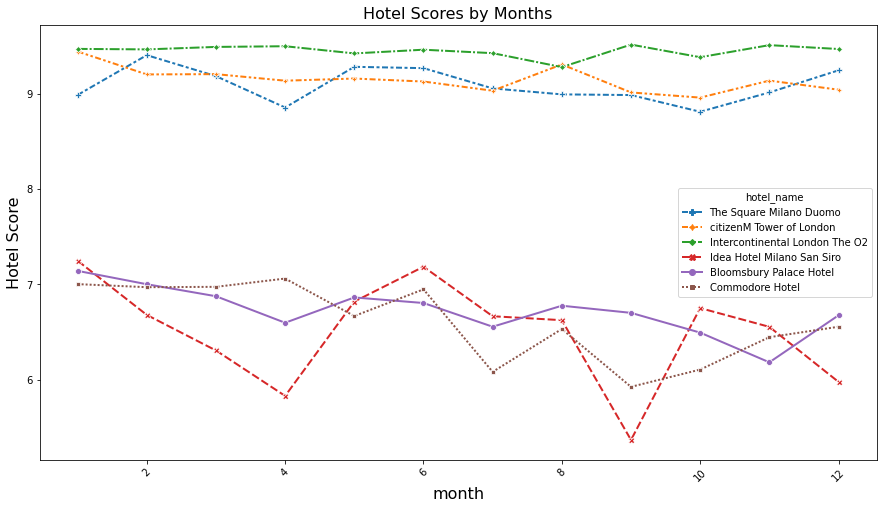

In [74]:
# data visualisation by months
plt.figure(figsize=(15, 8))
sns.lineplot(x = "month", y="review_score", hue="hotel_name", data=hotel_mask_df, 
             hue_order = ['The Square Milano Duomo', 'citizenM Tower of London', 'Intercontinental London The O2', 'Idea Hotel Milano San Siro', 'Bloomsbury Palace Hotel', 'Commodore Hotel'],
             size="hotel_name", ci=None, sizes=(2, 2), style = "hotel_name",markers=True)
plt.title("Hotel Scores by Months", fontsize=16)
plt.xlabel("month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Hotel Score", fontsize=16)
plt.show()

## 5.6 **Guests' Review Frequency** <a class="anchor" id="freq"></a>

In [75]:
reviewers_freq = df.pivot_table(values = "review_score", 
                                index = "reviews_given", 
                                aggfunc=["mean","count"])
reviewers_freq.sample(3)

mean        count
              review_score review_score
reviews_given                          
34                8.461033         1065
23                8.398543         2676
39                8.368194          720

In [76]:
reviewers_freq.columns = ["mean_review","review_count"]

In [77]:
reviewers_freq = reviewers_freq.reset_index()

In [78]:
reviewers_freq = reviewers_freq.sort_values(by="reviews_given",ascending = True)
reviewers_freq = reviewers_freq.round(2)
reviewers_freq

reviews_given  mean_review  review_count
0                1         8.38        154506
1                2         8.42         67011
2                3         8.39         46802
3                4         8.40         34991
4                5         8.41         27604
5                6         8.37         22593
6                7         8.40         18599
7                8         8.39         16126
8                9         8.39         13526
9               10         8.39         11702
10              11         8.39          9980
11              12         8.41          8995
12              13         8.43          7755
13              14         8.39          6752
14              15         8.45          5927
15              16         8.41          5376
16              17         8.43          4860
17              18         8.39          4384
18              19         8.42          3802
19              20         8.38          3427
20              21         8.40          3204
21              22         8.35          2876
22              23         8.40          2676
23              24         8.39          2342
24              25         8.41          2117
25              26         8.45          2013
26              27         8.33          1631
27              28         8.40          1561
28              29         8.44          1434
29              30         8.46          1324
30              31         8.46          1376
31              32         8.34          1188
32              33         8.49          1138
33              34         8.46          1065
34              35         8.34           891
35              36         8.47           834
36              37         8.37           727
37              38         8.43           648
38              39         8.37           720
39              40         8.44           637
40              41         8.42           528
41              42         8.44           556
42              43         8.36           525
43              44         8.37           571
44              45         8.28           421
45              46         8.48           388
46              47         8.36           395
47              48         8.29           354
48              49         8.44           322
49              50         8.56           365
50              51         8.43           259
51              52         8.58           272
52              53         8.29           226
53              54         8.40           260
54              55         8.55           253
55              56         8.31           254
56              57         8.17           172
57              58         8.46           185
58              59         8.45           151
59              60         8.59           191
60              61         8.43           178
61              62         8.42           191
62              63         8.47           140
63              64         8.50           136
64              65         8.41           120
65              66         8.34           116
66              67         8.47           107
67              68         8.23           117
68              69         8.52           103
69              70         8.85            78
70              71         8.41           101
71              72         8.18            68
72              73         7.90            97
73              74         8.48            55
74              75         8.35            82
75              76         8.60            72
76              77         8.05            73
77              78         8.37            56
78              79         8.50            68
79              80         8.51            55
80              81         8.05            39
81              82         8.57            48
82              83         8.45            62
83              84         8.63            65
84              85         8.62            36
85              86         8.63            79
86 

In [79]:
#add column to display cumulative percentage
reviewers_freq['cumperc'] = reviewers_freq['review_count'].cumsum()/reviewers_freq['review_count'].sum()*100
reviewers_freq.round(1)

reviews_given  mean_review  review_count  cumperc
0                1          8.4        154506     30.0
1                2          8.4         67011     43.0
2                3          8.4         46802     52.1
3                4          8.4         34991     58.9
4                5          8.4         27604     64.2
5                6          8.4         22593     68.6
6                7          8.4         18599     72.2
7                8          8.4         16126     75.4
8                9          8.4         13526     78.0
9               10          8.4         11702     80.3
10              11          8.4          9980     82.2
11              12          8.4          8995     83.9
12              13          8.4          7755     85.4
13              14          8.4          6752     86.7
14              15          8.4          5927     87.9
15              16          8.4          5376     88.9
16              17          8.4          4860     89.9
17              18          8.4          4384     90.7
18              19          8.4          3802     91.5
19              20          8.4          3427     92.1
20              21          8.4          3204     92.8
21              22          8.4          2876     93.3
22              23          8.4          2676     93.8
23              24          8.4          2342     94.3
24              25          8.4          2117     94.7
25              26          8.4          2013     95.1
26              27          8.3          1631     95.4
27              28          8.4          1561     95.7
28              29          8.4          1434     96.0
29              30          8.5          1324     96.3
30              31          8.5          1376     96.5
31              32          8.3          1188     96.7
32              33          8.5          1138     97.0
33              34          8.5          1065     97.2
34              35          8.3           891     97.3
35              36          8.5           834     97.5
36              37          8.4           727     97.7
37              38          8.4           648     97.8
38              39          8.4           720     97.9
39              40          8.4           637     98.0
40              41          8.4           528     98.1
41              42          8.4           556     98.3
42              43          8.4           525     98.4
43              44          8.4           571     98.5
44              45          8.3           421     98.5
45              46          8.5           388     98.6
46              47          8.4           395     98.7
47              48          8.3           354     98.8
48              49          8.4           322     98.8
49              50          8.6           365     98.9
50              51          8.4           259     99.0
51              52          8.6           272     99.0
52              53          8.3           226     99.0
53              54          8.4           260     99.1
54              55          8.6           253     99.1
55              56          8.3           254     99.2
56              57          8.2           172     99.2
57              58          8.5           185     99.3
58              59          8.4           151     99.3
59              60          8.6           191     99.3
60              61          8.4           178     99.4
61              62          8.4           191     99.4
62              63          8.5           140     99.4
63              64          8.5           136     99.5
64              65          8.4           120     99.5
65              66          8.3           116     99.5
66              67          8.5           107     99.5
67              68          8.2           117     99.5
68              69          8.5           103     99.6
69              70          8.8            78     99.6
70              71          8.4           101     99.6
71              72          8.2            68

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

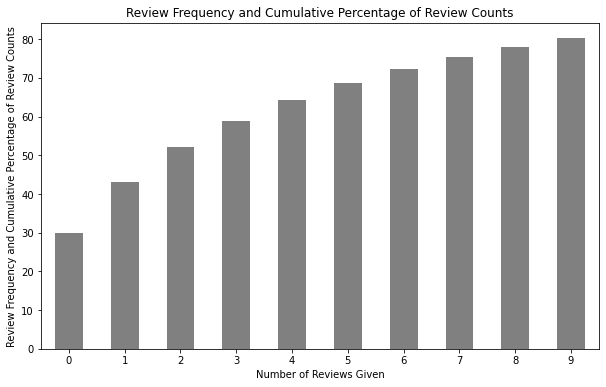

In [80]:
reviewers_freq.head(10)["cumperc"].plot(kind="bar", color="grey", figsize=(10,6)).set_title("Review Frequency and Cumulative Percentage of Review Counts")
plt.xlabel("Number of Reviews Given")
plt.ylabel("Review Frequency and Cumulative Percentage of Review Counts")
plt.xticks(rotation=0)

In [81]:
reviewers_freq.shape

(198, 4)

[Text(0, 0.5, '')]

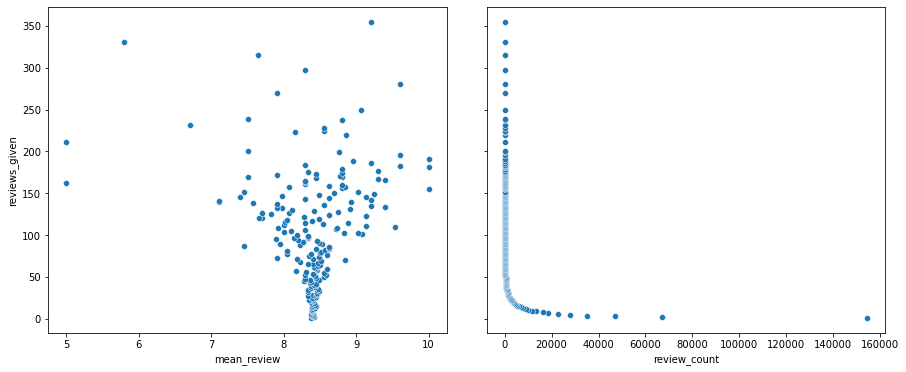

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6), sharey=True)
fig.subplots_adjust(wspace=0.1)
sns.scatterplot(x=reviewers_freq["mean_review"], y= reviewers_freq["reviews_given"], ax=ax1)
sns.scatterplot(x=reviewers_freq["review_count"], y= reviewers_freq["reviews_given"], palette="RdYlBu_r", ax=ax2)
#ax1.axvline(8, 0, 1, color="black", linestyle="--")
#ax1.set_xlim([8,8.8])
ax2.set(ylabel=None)
#ax2.set_xlim([30000,51000])

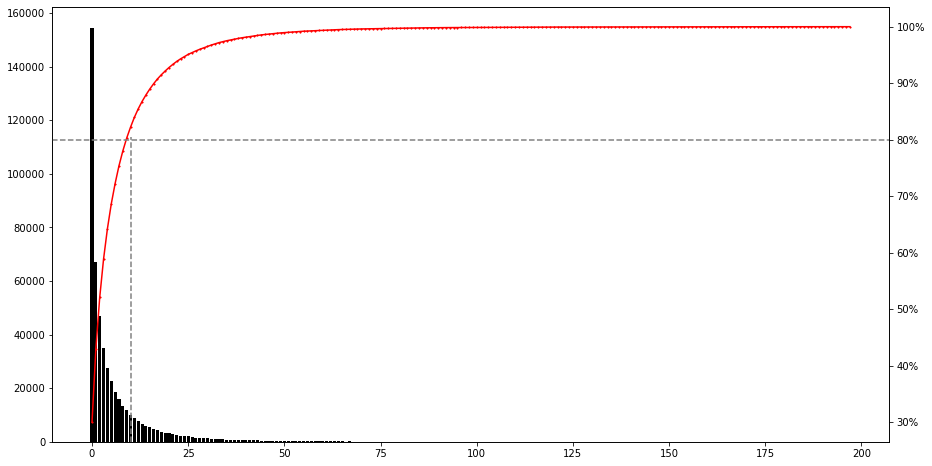

In [83]:
#https://www.statology.org/pareto-chart-python/

#define aesthetics for plot
color1 = 'black'
color2 = 'black'
color3 = 'red'
line_size = 1

#create basic bar plot
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(reviewers_freq.index, reviewers_freq['review_count'], color=color1) #amend data source here

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(reviewers_freq.index, reviewers_freq['cumperc'], color=color3, marker="D", ms=line_size) #amend data source here
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#plot specific markers as line
#ax1.axvline(8.4, 0, 1, color="black", linestyle="--")
ax2.axvline(10, 0, 0.7, color="grey", linestyle="--")
ax2.axhline(80,0,1, color="grey", linestyle="--")

#display Pareto chart
plt.show()

In [84]:
df[df["reviews_given"] > 51].shape

(5408, 22)

In [85]:
# Let's remove records with reviews given > 50 as outliner handling and we can still preserve 99% of the reviews
df = df[df["reviews_given"] < 51]
print(df.shape)
df.tail(1)

(509545, 22)


hotel_add  addtl_score  \
515211  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   

       review_date  avg_score             hotel_name reviewer_nationality  \
515211  2015-08-09        8.1  Atlantis Hotel Vienna              Hungary   

                                           neg_review  tot_neg_words  \
515211   I was in 3rd floor It didn t work Free Wife              13   

        total_reviews             pos_review  tot_pos_words  reviews_given  \
515211           2823   staff was very kind               6              1   

        review_score                                               tags  \
515211           8.3  [' Leisure trip ', ' Family with young childre...   

              lat        lng recommend hotel_ctry reviewer_continent  month  \
515211  48.203745  16.335677       Yes    Austria             Europe      8   

        year  day  
515211  2015    9

## 5.7 **Feature Engineering from Tags Column** <a class="anchor" id="tags"></a>

#### Tags - Overview & Feature Engineering

In [86]:
df["tags"][0]

"[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']"

In [87]:
df["tags"][100]

"[' Leisure trip ', ' Group ', ' Duplex Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

#### Tags - Trip Type

In [88]:
# Extracting Trip type features from tags
df['leisure'] = df['tags'].map(lambda x: 1 if ' Leisure trip ' in x else 0)
df['business'] = df['tags'].map(lambda x: 2 if ' Business trip ' in x else 0)
df['trip_type'] = df['leisure'] + df['business']

In [89]:
df["trip_type"].value_counts()

1    414069
2     80601
0     14875
Name: trip_type, dtype: int64

In [90]:
# There are 15k entries which are not leisure nor business.
# Let's find a way to reallocate the 15k "random" entries back to leisure/business trips
df['trip_type'] = df[df['trip_type'] == 0]['trip_type'].map(lambda x: 1 if random.random() > 0.2 else 2)
df['trip_type'] = df['trip_type'].fillna(0)
df['trip_type'] = df['trip_type'] + df['business'] + df['leisure']
del df['leisure'] , df['business']
df['trip_type'].value_counts()

1.0    426007
2.0     83538
Name: trip_type, dtype: int64

In [91]:
# Let's replace this back with leisure and business for data visualisation
df['trip_type'].replace({1: "leisure", 2: "business"}, inplace=True)
# check final Trip type
df['trip_type'].value_counts()

leisure     426007
business     83538
Name: trip_type, dtype: int64

In [92]:
df.head(1)

hotel_add  addtl_score review_date  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194  2017-08-03   

   avg_score   hotel_name reviewer_nationality  \
0        7.7  Hotel Arena               Russia   

                                          neg_review  tot_neg_words  \
0   I am so angry that i made this post available...            397   

   total_reviews                                         pos_review  \
0           1403   Only the park outside of the hotel was beauti...   

   tot_pos_words  reviews_given  review_score  \
0             11              7           2.9   

                                                tags        lat       lng  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...  52.360576  4.915968   

  recommend   hotel_ctry reviewer_continent  month  year  day trip_type  
0        No  Netherlands             Europe      8  2017    3   leisure

In [93]:
trip_type = df.pivot_table(values = "review_score", 
                                index = ["trip_type", "recommend"], 
                                aggfunc=["mean","count"])
trip_type.sample(3)

mean        count
                    review_score review_score
trip_type recommend                          
leisure   No            6.579545       140095
business  No            6.359587        37854
          Yes           9.307777        45684

In [94]:
trip_type.columns = ["mean_review","review_count"]

In [95]:
trip_type = trip_type.reset_index()

In [96]:
trip_type = trip_type.sort_values(by="mean_review",ascending = False)
trip_type = trip_type.round(1)
trip_type

trip_type recommend  mean_review  review_count
3   leisure       Yes          9.4        285912
1  business       Yes          9.3         45684
2   leisure        No          6.6        140095
0  business        No          6.4         37854

Text(0.5, 1.0, 'Total Review Counts by Trip Type')

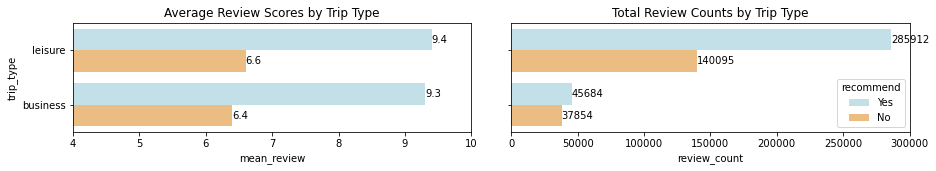

In [97]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,2), sharey=True)
fig.subplots_adjust(wspace=0.1)
sns.barplot(x=trip_type["mean_review"], y= trip_type["trip_type"], hue=trip_type["recommend"], palette="RdYlBu_r", ax=ax1)
sns.barplot(x=trip_type["review_count"], y= trip_type["trip_type"], hue=trip_type["recommend"], palette="RdYlBu_r", ax=ax2)
#ax1.axvline(8.4, 0, 1, color="black", linestyle="--")
ax1.set_xlim([4,10])
ax2.set(ylabel=None)
#ax2.set_xlim([30000,51000])
ax1.legend([],[], frameon=False)
ax1.bar_label(ax1.containers[0])
ax1.bar_label(ax1.containers[1])
ax2.bar_label(ax2.containers[0])
ax2.bar_label(ax2.containers[1])
ax1.set_title("Average Review Scores by Trip Type")
ax2.set_title("Total Review Counts by Trip Type")

#### Tags - Traveller Type

In [98]:
#Couple or Solo or Group or Family_with_older children or Family with younger Children
df['solo'] = df['tags'].map(lambda x: 1 if ' Solo traveler ' in x else 0)
df['couple'] = df['tags'].map(lambda x: 2 if ' Couple ' in x else 0)
df['group'] = df['tags'].map(lambda x: 3 if ' Group ' in x else 0)
df['fam_young_child'] = df['tags'].map(lambda x: 4 if ' Family with young children ' in x else 0)
df['fam_older_child'] = df['tags'].map(lambda x: 5 if ' Family with older children ' in x else 0)
df['whom'] = df['solo'] + df['couple'] + df['group'] + df['fam_young_child'] + df['fam_older_child']
del df['solo'], df['couple'],df['group'], df['fam_young_child'],df['fam_older_child']
df['whom'].value_counts()

2    249824
1    105912
3     64876
4     60647
5     26158
0      2128
Name: whom, dtype: int64

In [99]:
# There is about 224 records without this information.
# Let's impute it to the mode
df['whom'] = df['whom'].map(lambda x: 2 if x == 0 else x)
df['whom'].value_counts()

2    251952
1    105912
3     64876
4     60647
5     26158
Name: whom, dtype: int64

In [100]:
# Let's replace this back with traveller type for data visualisation
df['whom'].replace({1: "Solo", 2: "Couple", 3: "Group", 4: "Fam_with_young_child", 5: "Fam_with_old_child" }, inplace=True)
# check final traveller type
df['whom'].value_counts()

Couple                  251952
Solo                    105912
Group                    64876
Fam_with_young_child     60647
Fam_with_old_child       26158
Name: whom, dtype: int64

In [101]:
good_whom_df = df[df["recommend"] == "Yes"].pivot_table(values = "review_score", 
                                                           index = ["whom", "recommend"], 
                                                           aggfunc=["mean","count"])
good_whom_df.sample(3)

mean        count
                               review_score review_score
whom                 recommend                          
Fam_with_old_child   Yes           9.369012        17271
Group                Yes           9.413687        43084
Fam_with_young_child Yes           9.381967        38368

In [102]:
good_whom_df.columns = ["mean_review","review_count"]
good_whom_df = good_whom_df.reset_index()

In [103]:
good_whom_df = good_whom_df.sort_values(by="review_count",ascending = False)
good_whom_df = good_whom_df.round(1)
good_whom_df.shape
good_whom_df

whom recommend  mean_review  review_count
0                Couple       Yes          9.4        171139
4                  Solo       Yes          9.3         61734
3                 Group       Yes          9.4         43084
2  Fam_with_young_child       Yes          9.4         38368
1    Fam_with_old_child       Yes          9.4         17271

In [104]:
bad_whom_df = df[df["recommend"] == "No"].pivot_table(values = "review_score", 
                                                           index = ["whom", "recommend"], 
                                                           aggfunc=["mean","count"])
bad_whom_df

mean        count
                               review_score review_score
whom                 recommend                          
Couple               No            6.592731        80813
Fam_with_old_child   No            6.620659         8887
Fam_with_young_child No            6.447834        22279
Group                No            6.549757        21792
Solo                 No            6.439796        44178

In [105]:
bad_whom_df.columns = ["mean_review","review_count"]
bad_whom_df = bad_whom_df.reset_index()

In [106]:
bad_whom_df = bad_whom_df.sort_values(by="review_count",ascending = False)
bad_whom_df = bad_whom_df.round(1)
bad_whom_df.shape
bad_whom_df

whom recommend  mean_review  review_count
0                Couple        No          6.6         80813
4                  Solo        No          6.4         44178
2  Fam_with_young_child        No          6.4         22279
3                 Group        No          6.5         21792
1    Fam_with_old_child        No          6.6          8887

C:\Users\lilli\AppData\Local\Temp\ipykernel_13012\1367484495.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2],            #axes object


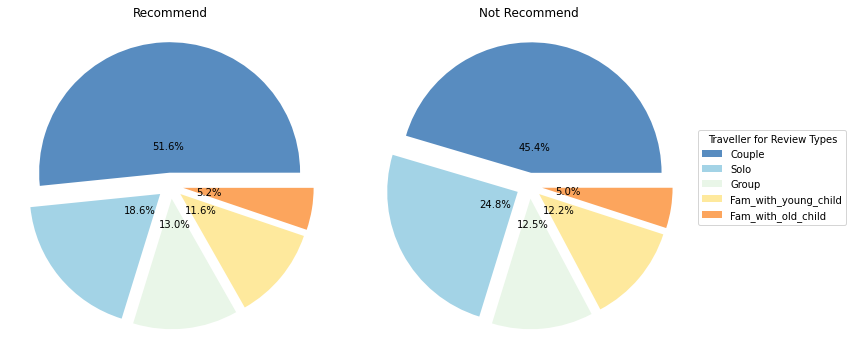

In [107]:
#define Seaborn color palette to use

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
fig.subplots_adjust(wspace=-0.15)

color = sns.color_palette('RdYlBu_r')[0:7]
label=df["whom"].value_counts().index

l1 = ax1.pie(good_whom_df["review_count"].values, autopct='%1.1f%%', labels=None,
              colors = color, explode=[0.1]*5, pctdistance=0.2)

l2 = ax2.pie(bad_whom_df["review_count"].values, autopct='%1.1f%%', labels=None,
              colors = color, explode=[0.1]*5, pctdistance=0.2)

ax1.set_title('Recommend')
ax2.set_title('Not Recommend')

fig.legend([l1, l2],            #axes object
           labels=df["whom"].value_counts().index,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Traveller for Review Types"
           )

plt.show()

#### Tags - Stay Duration

In [108]:
df["tags"][10]

"[' Leisure trip ', ' Group ', ' Duplex Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

In [109]:
#Duration
df['Stayed_1_days'] = df['tags'].map(lambda x: 1 if ' Stayed 1 night ' in x else 0)
df['Stayed_2_days'] = df['tags'].map(lambda x: 2 if ' Stayed 2 nights ' in x else 0)
df['Stayed_3_days'] = df['tags'].map(lambda x: 3 if ' Stayed 3 nights ' in x else 0)
df['Stayed_4_days'] = df['tags'].map(lambda x: 4 if ' Stayed 4 nights ' in x else 0)
df['Stayed_5_days'] = df['tags'].map(lambda x: 5 if ' Stayed 5 nights ' in x else 0)
df['Stayed_6_days'] = df['tags'].map(lambda x: 6 if ' Stayed 6 nights ' in x else 0)
df['Stayed_7_days'] = df['tags'].map(lambda x: 7 if ' Stayed 7 nights ' in x else 0)
df['Stayed_8_days'] = df['tags'].map(lambda x: 8 if ' Stayed 8 nights ' in x else 0)
df['Stayed_9_days'] = df['tags'].map(lambda x: 9 if ' Stayed 9 nights ' in x else 0)
df['Stayed_10_days'] = df['tags'].map(lambda x: 10 if ' Stayed 10 nights ' in x else 0)
df['Stayed_11_days'] = df['tags'].map(lambda x: 11 if ' Stayed 11 nights ' in x else 0)
df['Stayed_12_days'] = df['tags'].map(lambda x: 12 if ' Stayed 12 nights ' in x else 0)
df['Stayed_13_days'] = df['tags'].map(lambda x: 13 if ' Stayed 13 nights ' in x else 0)
df['Stayed_14_days'] = df['tags'].map(lambda x: 14 if ' Stayed 14 nights ' in x else 0)
df['Stayed_15_days'] = df['tags'].map(lambda x: 15 if ' Stayed 15 nights ' in x else 0)
df['Stayed_16_days'] = df['tags'].map(lambda x: 16 if ' Stayed 16 nights ' in x else 0)
df['Stayed_17_days'] = df['tags'].map(lambda x: 17 if ' Stayed 17 nights ' in x else 0)
df['Stayed_18_days'] = df['tags'].map(lambda x: 18 if ' Stayed 18 nights ' in x else 0)
df['Stayed_19_days'] = df['tags'].map(lambda x: 19 if ' Stayed 19 nights ' in x else 0)
df['Stayed_20_days'] = df['tags'].map(lambda x: 20 if ' Stayed 20 nights ' in x else 0)

In [110]:
df['duration'] = df['Stayed_1_days'] + df['Stayed_2_days'] + df['Stayed_3_days'] + df['Stayed_4_days'] + df['Stayed_5_days'] + df['Stayed_6_days'] + df['Stayed_7_days'] + df['Stayed_8_days'] + df['Stayed_9_days'] + df['Stayed_10_days'] + df['Stayed_11_days'] + df['Stayed_12_days'] + df['Stayed_13_days'] + df['Stayed_14_days'] + df['Stayed_15_days'] + df['Stayed_16_days'] + df['Stayed_17_days'] + df['Stayed_18_days'] + df['Stayed_19_days'] + df['Stayed_20_days']
del df['Stayed_1_days'] , df['Stayed_2_days'] , df['Stayed_3_days'] , df['Stayed_4_days'], df['Stayed_5_days'] , df['Stayed_6_days'] , df['Stayed_7_days'] , df['Stayed_8_days'] , df['Stayed_9_days'] , df['Stayed_10_days'] , df['Stayed_11_days'] , df['Stayed_12_days'] , df['Stayed_13_days'] , df['Stayed_14_days'] , df['Stayed_15_days'] , df['Stayed_16_days'] , df['Stayed_17_days'] , df['Stayed_18_days'] , df['Stayed_19_days'] , df['Stayed_20_days']

In [111]:
df["duration"].value_counts(dropna=False)

1     190991
2     132277
3      94804
4      47343
5      20637
6       9693
7       7344
8       2483
9       1287
10       882
11       416
12       315
0        288
14       245
13       244
15       117
16        56
17        42
18        33
19        29
20        19
Name: duration, dtype: int64

In [112]:
#Assgining stayings which are over 20 days as 21
df['duration'] = df['duration'].map(lambda x: 21 if x == 0 else x)

In [113]:
df["duration"].value_counts(dropna=False)

1     190991
2     132277
3      94804
4      47343
5      20637
6       9693
7       7344
8       2483
9       1287
10       882
11       416
12       315
21       288
14       245
13       244
15       117
16        56
17        42
18        33
19        29
20        19
Name: duration, dtype: int64

In [114]:
#To check
len(df[df['duration'] == 0])

0

In [115]:
duration_df = df.pivot_table(values = "review_score", 
                                index = ["duration"], 
                                aggfunc=["mean","count"])
duration_df.sample(3)

mean        count
         review_score review_score
duration                          
8            8.221587         2483
5            8.338518        20637
19           7.924138           29

In [116]:
duration_df.columns = ["mean_review","review_count"]
duration_df = duration_df.reset_index()

In [117]:
duration_df = duration_df.sort_values(by="duration",ascending = True)
duration_df = duration_df.round(1)
duration_df

duration  mean_review  review_count
0          1          8.4        190991
1          2          8.4        132277
2          3          8.4         94804
3          4          8.4         47343
4          5          8.3         20637
5          6          8.3          9693
6          7          8.3          7344
7          8          8.2          2483
8          9          8.1          1287
9         10          8.2           882
10        11          8.1           416
11        12          8.2           315
12        13          7.7           244
13        14          8.0           245
14        15          7.8           117
15        16          7.9            56
16        17          7.8            42
17        18          8.1            33
18        19          7.9            29
19        20          8.8            19
20        21          7.0           288

In [118]:
duration_df.columns

Index(['duration', 'mean_review', 'review_count'], dtype='object')

In [119]:
# set duration as string for visusalisation
duration_df["duration"] = duration_df["duration"].astype(str)
duration_df

duration  mean_review  review_count
0         1          8.4        190991
1         2          8.4        132277
2         3          8.4         94804
3         4          8.4         47343
4         5          8.3         20637
5         6          8.3          9693
6         7          8.3          7344
7         8          8.2          2483
8         9          8.1          1287
9        10          8.2           882
10       11          8.1           416
11       12          8.2           315
12       13          7.7           244
13       14          8.0           245
14       15          7.8           117
15       16          7.9            56
16       17          7.8            42
17       18          8.1            33
18       19          7.9            29
19       20          8.8            19
20       21          7.0           288

In [120]:
#add column to display cumulative percentage
duration_df['cumperc'] = duration_df['review_count'].cumsum()/duration_df['review_count'].sum()*100
duration_df

duration  mean_review  review_count     cumperc
0         1          8.4        190991   37.482656
1         2          8.4        132277   63.442483
2         3          8.4         94804   82.048102
3         4          8.4         47343   91.339332
4         5          8.3         20637   95.389416
5         6          8.3          9693   97.291701
6         7          8.3          7344   98.732987
7         8          8.2          2483   99.220285
8         9          8.1          1287   99.472863
9        10          8.2           882   99.645959
10       11          8.1           416   99.727600
11       12          8.2           315   99.789420
12       13          7.7           244   99.837306
13       14          8.0           245   99.885388
14       15          7.8           117   99.908350
15       16          7.9            56   99.919340
16       17          7.8            42   99.927582
17       18          8.1            33   99.934059
18       19          7.9            29   99.939750
19       20          8.8            19   99.943479
20       21          7.0           288  100.000000

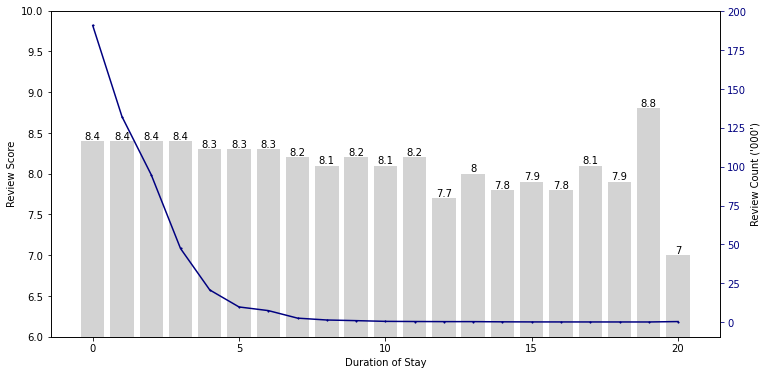

In [121]:
#define aesthetics for plot
color1 = 'grey'
color2 = 'black'
color3 = 'navy'
line_size = 1

#create basic bar plot
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(duration_df.index, duration_df['mean_review'], color="lightgrey") #amend data source here

#add secondary axis for review counts
ax2 = ax.twinx()
ax2.plot(duration_df.index, duration_df['review_count']/1000, color=color3, marker="D", ms=line_size) #amend data source here

#specify axis colors
ax.tick_params(axis='y', colors=color2)
ax.set_ylim([6,10])
ax.bar_label(ax.containers[0])
#ax.set_xlim([0,10])
ax.set_xlabel("Duration of Stay")
ax.set_ylabel("Review Score")
ax2.set_ylabel("Review Count ('000')")
ax2.tick_params(axis='y', colors=color3)

#display Pareto chart
plt.show()

In [122]:
print(df[df["duration"] == 20].shape)
df[df["duration"] == 20]

(19, 25)


hotel_add  addtl_score  \
4510    1 8 Russell Square Camden London WC1B 5BE Unit...          724   
68410   163 Marsh Wall Docklands Tower Hamlets London ...         2682   
70086   17 25 Sloane Street Knightsbridge Kensington a...          759   
77224   18 Lodge Road Near Baker Street And Marylebone...          362   
79942   19 21 Penywern Road Kensington and Chelsea Lon...          249   
80183   19 21 Penywern Road Kensington and Chelsea Lon...          249   
80820   19 25 Granville Place Marble Arch Westminster ...          234   
129380  28 30 Seymour Street Westminster Borough Londo...           45   
135223  3 Kingdom Street Sheldon Square Westminster Bo...          232   
155730  34 Norfolk Place Paddington Westminster Boroug...          634   
171693  39 Coventry Street Westminster Borough London ...          326   
185384  41 Great Cumberland Place Westminster Borough ...          151   
226486    628 Western Avenue London W3 0TA United Kingdom          131   
243830  78 84 Sussex Gardens Westminster Borough Londo...          636   
369861  Lerchenfelder Stra e 1 3 07 Neubau 1070 Vienna...          391   
441406  Scarsdale Place Kensington Kensington and Chel...         1831   
452113  Sloane Square Kensington and Chelsea London SW...          279   
494052  Viale Bianca Maria 4 Milan City Center 20129 M...          231   
510222  Wibautstraat 129 Oost 1091 GL Amsterdam Nether...          975   

       review_date  avg_score  \
4510    2016-07-16        8.0   
68410   2015-10-29        7.1   
70086   2016-09-18        7.5   
77224   2017-05-21        8.1   
79942   2017-04-20        7.7   
80183   2017-05-22        7.7   
80820   2016-10-14        8.0   
129380  2016-08-25        9.3   
135223  2017-01-04        8.5   
155730  2017-06-01        7.9   
171693  2015-09-20        8.8   
185384  2016-08-14        8.1   
226486  2017-05-28        8.9   
243830  2016-07-31        7.7   
369861  2017-01-09        8.8   
441406  2016-04-25        8.1   
452113  2015-08-22        8.2   
494052  2016-07-17        9.0   
510222  2015-09-13        8.7   

                                              hotel_name  \
4510                                The Principal London   
68410         Britannia International Hotel Canary Wharf   
70086              Millennium Hotel London Knightsbridge   
77224                        Danubius Hotel Regents Park   
79942   Best Western The Boltons Hotel London Kensington   
80183   Best Western The Boltons Hotel London Kensington   
80820                      Radisson Blu Edwardian Sussex   
129380                   The Zetter Townhouse Marylebone   
135223                         Novotel London Paddington   
155730                         Norfolk Towers Paddington   
171693                            every hotel Piccadilly   
185384             Shaftesbury Suites London Marble Arch   
226486                      Park Plaza London Park Royal   
243830           Shaftesbury Metropolis London Hyde Park   
369861                25hours Hotel beim MuseumsQuartier   
441406            Copthorne Tara Hotel London Kensington   
452113                               Sloane Square Hotel   
494052                         Bianca Maria Palace Hotel   
510222                  The Student Hotel Amsterdam City   

            reviewer_nationality  \
4510    United States of America   
68410                      India   
70086                     Kuwait   
77224                     Kuwait   
79942                   Colombia   
80183                   Colombia   
80820               Saudi Arabia   
129380              Saudi Arabia   
135223                  Malaysia   
155730                    Russia   
171693                 Australia   
185384              Saudi Arabia   
226486            United Kingdom   
243830              Saudi Arabia   
369861  United States of America   
441406              Saudi Arabia   
452113                     Qatar   
494052                   Romania   
510222  United States

In [123]:
# Outliers in duration 20 days
df[df["duration"] == 20].describe().T

count         mean          std          min          25%  \
addtl_score     19.0   585.315789   653.609385    45.000000   233.000000   
avg_score       19.0     8.215789     0.579524     7.100000     7.800000   
tot_neg_words   19.0    14.842105    12.280351     0.000000     5.000000   
total_reviews   19.0  2890.578947  2540.505359   180.000000  1240.500000   
tot_pos_words   19.0    15.789474    14.687784     2.000000     5.000000   
reviews_given   19.0     5.157895     6.414074     1.000000     1.500000   
review_score    19.0     8.778947     1.340223     4.600000     8.100000   
lat             19.0    51.062430     1.570256    45.463544    51.495889   
lng             19.0     1.465646     4.320727    -0.282992    -0.177351   
month           19.0     6.473684     2.695025     1.000000     5.000000   
year            19.0  2016.157895     0.764719  2015.000000  2016.000000   
day             19.0    18.368421     8.036103     1.000000    14.000000   
duration        19.0    20.000000     0.000000    20.000000    20.000000   

                       50%          75%          max  
addtl_score     326.000000   680.000000  2682.000000  
avg_score         8.100000     8.750000     9.300000  
tot_neg_words    13.000000    21.500000    48.000000  
total_reviews  1685.000000  3607.500000  9086.000000  
tot_pos_words    11.000000    22.000000    59.000000  
reviews_given     2.000000     4.500000    23.000000  
review_score      9.600000     9.600000    10.000000  
lat              51.514438    51.517860    52.354665  
lng              -0.159993    -0.128333    16.354630  
month             7.000000     8.500000    10.000000  
year           2016.000000  2017.000000  2017.000000  
day              20.000000    23.500000    31.000000  
duration         20.000000    20.000000    20.000000

In [124]:
## Let's remove anything less than 10 days duration as outlier handling since we will still keep more than 99% of the records
df = df[df["duration"] < 10]
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.tail(1)

(506859, 25)


hotel_add  addtl_score  \
506858  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   

       review_date  avg_score             hotel_name reviewer_nationality  \
506858  2015-08-09        8.1  Atlantis Hotel Vienna              Hungary   

                                           neg_review  tot_neg_words  \
506858   I was in 3rd floor It didn t work Free Wife              13   

        total_reviews             pos_review  tot_pos_words  reviews_given  \
506858           2823   staff was very kind               6              1   

        review_score                                               tags  \
506858           8.3  [' Leisure trip ', ' Family with young childre...   

              lat        lng recommend hotel_ctry reviewer_continent  month  \
506858  48.203745  16.335677       Yes    Austria             Europe      8   

        year  day trip_type                  whom  duration  
506858  2015    9   leisure  Fam_with_young_child         2

In [125]:
df["duration"].describe().T

count    506859.000000
mean          2.315293
std           1.474277
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           9.000000
Name: duration, dtype: float64

## 5.8 **Summary of Business Insights** <a class="anchor" id="summary_business"></a>

* Most rated hotels do not translate to best rated hotels.
* 70% of the travellers were from Europe but the best reviews came from outside Europe (NA, Oceania)
* Within the travellers in Europe (mostly from UK) , yet those from Netherlands, Italy, Germany, France gave lower score than their counterparts.
* For non-Europe travellers, the lower rating travellers came from Middle East (Saudi Arabia, Qatar, UAE) and India.
* There is more 4x as many leisure vs business travellers who would recommend.
* There is also a higher proportion of solo who had gave bad reviews compared to the segments.
* The review scores drop a little every 3 days and beyond day10 of the hotel stay.
* The lowest scoring review months (where review counts were highest) were Sep & October, possibly after the summer break vacations.
* The hotel with higher review scores were more consistent through the months as compared to the hotels with lower review scores.
* About 30% of the guests was giving the reviews for the first time which might suggest new customer funneling through the booking website.

#### Checking Dataset 

In [126]:
df.shape

(506859, 25)

In [127]:
df.reset_index(drop=True)

hotel_add  addtl_score  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          194   
...                                                   ...          ...   
506854  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   
506855  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   
506856  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   
506857  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   
506858  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   

       review_date  avg_score             hotel_name reviewer_nationality  \
0       2017-08-03        7.7            Hotel Arena               Russia   
1       2017-08-03        7.7            Hotel Arena              Ireland   
2       2017-07-31        7.7            Hotel Arena            Australia   
3       2017-07-31        7.7            Hotel Arena       United Kingdom   
4       2017-07-24        7.7            Hotel Arena          New Zealand   
...            ...        ...                    ...                  ...   
506854  2015-08-30        8.1  Atlantis Hotel Vienna               Kuwait   
506855  2015-08-22        8.1  Atlantis Hotel Vienna              Estonia   
506856  2015-08-19        8.1  Atlantis Hotel Vienna                Egypt   
506857  2015-08-17        8.1  Atlantis Hotel Vienna               Mexico   
506858  2015-08-09        8.1  Atlantis Hotel Vienna              Hungary   

                                               neg_review  tot_neg_words  \
0        I am so angry that i made this post available...            397   
1                                             No Negative              0   
2        Rooms are nice but for elderly a bit difficul...             42   
3        My room was dirty and I was afraid to walk ba...            210   
4        You When I booked with your company on line y...            140   
...                                                   ...            ...   
506854   no trolly or staff to help you take the lugga...             14   
506855           The hotel looks like 3 but surely not 4              11   
506856   The ac was useless It was a hot week in vienn...             19   
506857                                        No Negative              0   
506858       I was in 3rd floor It didn t work Free Wife              13   

        total_reviews                                         pos_review  \
0                1403   Only the park outside of the hotel was beauti...   
1                1403   No real complaints the hotel was great great ...   
2                1403   Location was good and staff were ok It is cut...   
3                1403   Great location in nice surroundings the bar a...   
4                1403    Amazing location and building Romantic setting    
...               ...                                                ...   
506854           2823                                           location   
506855           2823      Breakfast was ok and we got earlier check in    
506856           2823                                        No Positive   
506857           2823   The rooms are enormous and really comfortable...   
506858           2823                               staff was very kind    

        tot_pos_words  reviews_given  review_score  \
0                  11              7           2.9   
1                 105              7           7.5   
2                  21              9           7.1   
3                  26              1           3.8   
4                   8              3           6.7   
...               ...            ...           ...   
506854              2         

In [128]:
# output file for clean data
df.to_csv('df_pre_textclean.csv',index=False)

## 6. **Review Text Analysis (10% Sample used from this point onwards)**  <a class="anchor" id="reviewtext"></a>

#### Complete Review Text Pre Processing

In [129]:
df = pd.read_csv("df_pre_textclean.csv")

In [130]:
print(df.shape)
df.tail(1)

(506859, 25)


hotel_add  addtl_score  \
506858  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...          168   

       review_date  avg_score             hotel_name reviewer_nationality  \
506858  2015-08-09        8.1  Atlantis Hotel Vienna              Hungary   

                                           neg_review  tot_neg_words  \
506858   I was in 3rd floor It didn t work Free Wife              13   

        total_reviews             pos_review  tot_pos_words  reviews_given  \
506858           2823   staff was very kind               6              1   

        review_score                                               tags  \
506858           8.3  [' Leisure trip ', ' Family with young childre...   

              lat        lng recommend hotel_ctry reviewer_continent  month  \
506858  48.203745  16.335677       Yes    Austria             Europe      8   

        year  day trip_type                  whom  duration  
506858  2015    9   leisure  Fam_with_young_child         2

In [131]:
# Let's take a sample of the df
df = df.sample(frac=0.1, random_state=42)

## 6.1 **Review_Total_Positive_Word_Counts & Review_Total_Negative_Word_Counts** <a class="anchor" id="counts"></a>

#### Review_Total_Positive_Word_Counts  

In [132]:
df.columns

Index(['hotel_add', 'addtl_score', 'review_date', 'avg_score', 'hotel_name',
       'reviewer_nationality', 'neg_review', 'tot_neg_words', 'total_reviews',
       'pos_review', 'tot_pos_words', 'reviews_given', 'review_score', 'tags',
       'lat', 'lng', 'recommend', 'hotel_ctry', 'reviewer_continent', 'month',
       'year', 'day', 'trip_type', 'whom', 'duration'],
      dtype='object')

In [133]:
pos_words = df["tot_pos_words"].value_counts()
pos_words[:10]

0     3578
6     2652
5     2626
4     2458
7     2391
8     2305
3     2207
9     2082
10    1985
2     1982
Name: tot_pos_words, dtype: int64

In [134]:
# Checking reviews with 0 positive word counts (which implies negative)
a = df.loc[df["tot_pos_words"] == 0]
print('No of completely Negative reviews in the dataset:',len(a))
b = a[["tot_pos_words",'pos_review','neg_review',"review_score", "recommend"]]
b.sample(5)

No of completely Negative reviews in the dataset: 3578


tot_pos_words   pos_review  \
268516              0  No Positive   
440066              0  No Positive   
505896              0  No Positive   
245878              0  No Positive   
468441              0  No Positive   

                                               neg_review  review_score  \
268516   This hotel is a cheater with terrible staff a...           2.5   
440066   The dreadful stuffed horse in the foyer The l...           6.3   
505896   Staff at reception really struggled with our ...           7.5   
245878   I couldn t fault anything this was the best h...           9.6   
468441   The toilet did not work When we complained we...           5.4   

       recommend  
268516        No  
440066        No  
505896        No  
245878       Yes  
468441        No

#### Review_Total_Negative_Word_Counts 

In [135]:
neg_words = df["tot_neg_words"].value_counts()
neg_words[:10]

0     12609
2      2447
3      1736
5      1713
6      1675
7      1597
4      1425
8      1410
9      1281
10     1248
Name: tot_neg_words, dtype: int64

In [136]:
# Checking reviews with 0 negative word counts (which implies positive)
a = df.loc[df["tot_neg_words"] == 0]
print('No of completely Negative reviews in the dataset:',len(a))
b = a[["tot_neg_words", "pos_review","neg_review","review_score", "recommend"]]
b.sample(5)

No of completely Negative reviews in the dataset: 12609


tot_neg_words                                         pos_review  \
218973              0   Location is excellent a 3 minute walk to Ange...   
242066              0   The hotel it self is a beautiful art Rooms ar...   
425792              0   Everything was excellent Helpful and friendly...   
364720              0   We contacted hotel in advance of stay and the...   
315789              0                              Original architecture   

         neg_review  review_score recommend  
218973  No Negative           9.2       Yes  
242066  No Negative           8.8       Yes  
425792  No Negative          10.0       Yes  
364720  No Negative          10.0       Yes  
315789  No Negative           9.2       Yes

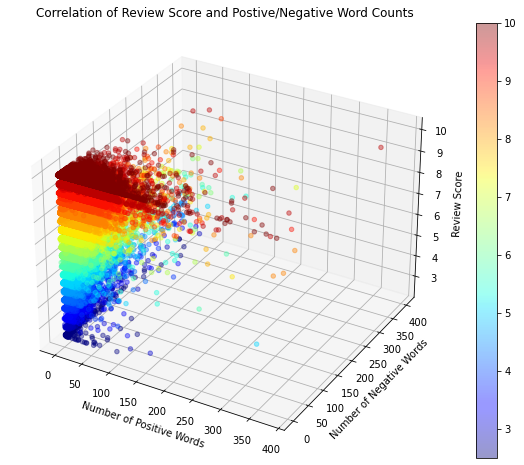

In [137]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')

x = df['tot_pos_words']
y = df['tot_neg_words']
z = df['review_score']
c = df['review_score']
s = df['total_reviews']/100

ax.set_xlabel("Number of Positive Words")
ax.set_ylabel("Number of Negative Words")
ax.set_zlabel("Review Score")

p = ax.scatter(x, y, z, c=c, alpha=0.4, cmap=plt.get_cmap('jet'),)
fig.colorbar(p, ax=ax)
plt.title("Correlation of Review Score and Postive/Negative Word Counts")
plt.show()

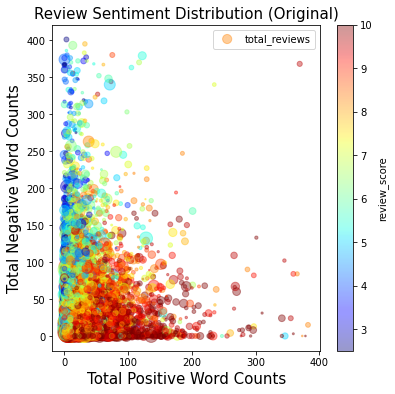

In [138]:
# Let's take a look at how the tot pos words & tot neg words with the reviwer scores
df.plot(kind='scatter', 
                      x='tot_pos_words', 
                      y='tot_neg_words', 
                      label='total_reviews',
             s=df.total_reviews/100,
             c='review_score',
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(6,6),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Sentiment Distribution (Original)",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()

## 6.2 **Data Cleaning on Negative & Positive Review Text** <a class="anchor" id="clean_review_col"></a>

In [139]:
# Let's check for any oddities before combining with positive reviews.
df["neg_review"].value_counts(ascending=False).head(20)

No Negative         12609
 Nothing             1391
 Nothing              424
 nothing              228
 None                 106
 N A                   96
                       91
 N a                   49
 Breakfast             41
 Small room            39
 Location              32
 Everything            31
 none                  30
 Price                 29
 Nil                   28
 All good              28
 nothing               28
 Nothing really        27
 Nothing at all        26
 All good              24
Name: neg_review, dtype: int64

In [140]:
# I noticed that there is phrases like "no negative" in "neg_review" column
# Let's remove these before combining with 
df["neg_review"] = df["neg_review"].replace({"No Negative":"", " Nothing":"", " Nothing ":"", " nothing":"", " None":"", 
                                             " none":"", " none":"", " nothing ":"", " No complaints":"",
                                             " Nothing really ":"", " Nil":""})

In [141]:
# Let's check for any oddities before combining with positive reviews.
df["neg_review"].value_counts(ascending=False).head(20)

                       14890
 N A                      96
                          91
 N a                      49
 Breakfast                41
 Small room               39
 Location                 32
 Everything               31
 Price                    29
 All good                 28
 Nothing really           27
 Nothing at all           26
 All good                 24
 n a                      23
 Nothing at all           21
 Nothing to dislike       18
 None                     17
 Small rooms              16
 No complaints            16
 NA                       16
Name: neg_review, dtype: int64

In [142]:
# Let's check the same for pos review column
df["pos_review"].value_counts(ascending=False).head(20)

No Positive            3578
 Location               876
 Everything             219
 location               146
 Nothing                114
 The location           111
 Location                94
 Great location          84
 Good location           83
 Breakfast               68
 Everything              61
 Friendly staff          48
 Staff                   40
 Excellent location      38
 Location and staff      36
 Every thing             31
 Great location          30
 Good location           26
 everything              25
 Location staff          24
Name: pos_review, dtype: int64

In [143]:
df["pos_review"] = df["pos_review"].replace({"No Positive":"", " Nothing":"", " Nothing ":"", " nothing":"" })

In [144]:
# Let's check the same for pos review column
df["pos_review"].value_counts(ascending=False).head(20)

                       3738
 Location               876
 Everything             219
 location               146
 The location           111
 Location                94
 Great location          84
 Good location           83
 Breakfast               68
 Everything              61
 Friendly staff          48
 Staff                   40
 Excellent location      38
 Location and staff      36
 Every thing             31
 Great location          30
 Good location           26
 everything              25
 Location staff          24
                         23
Name: pos_review, dtype: int64

## 6.3  **Text Cleaning Tasks** <a class="anchor" id="text_cleaner"></a>

In [145]:
%%time
# We will convert the review text both positive and negative 
df["neg_review"] = df["neg_review"].astype(str)
df["pos_review"] = df["pos_review"].astype(str)
df["comb_review"] = df["pos_review"].astype(str) + df["neg_review"].astype(str)

CPU times: total: 62.5 ms
Wall time: 43.5 ms


In [146]:
df = df.reset_index(drop=True)
print(df.shape)
df.tail(1)

(50686, 26)


hotel_add  addtl_score  \
50685  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50685  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50685             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50685           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50685  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50685        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review  
50685  Couple         4   Bed Not enough coffee No milk

In [147]:
# Let's clean up the review text column first 
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["nan"]
stopwords.extend(new_stopwords)
ps = nltk.PorterStemmer()
sid = SentimentIntensityAnalyzer()

In [148]:
# https://www.kaggle.com/code/divyansh22/airline-review-data-preprocessing-pt-2-nlp
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def text_cleaner(text):
    # Transform the text so that all words are lower case.
    text = text.lower()
    # Remove punctuation and tokenize the text into individual words.
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # Remove words that contain numbers.
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # Remove stop words.
    text = [word for word in text if word not in stopwords]
    # Remove words with less than 2 letters
    text = [word for word in text if len(word)>1]
    # POS tagging of the text.
    pos_tags = pos_tag(text)
    # Lemmatize the text.
    text = [WordNetLemmatizer().lemmatize(i_pos_tag[0], get_wordnet_pos(i_pos_tag[1])) for i_pos_tag in pos_tags]
    # Remove words with only one letter.
    text = [word for word in text if len(word)>1]
    # Join the text with space as a word delimiter.
    text = " ".join(text)
    # Remove non-ASCII characters.
    printable = set(string.printable)
    text = ''.join(filter(lambda x: x in printable, text))
    return text

In [149]:
# Example of POS tagging.
# https://www.guru99.com/pos-tagging-chunking-nltk.html#1
# https://towardsdatascience.com/intro-to-nltk-for-nlp-with-python-87da6670dde

sent = "A sample to show POS tagging"
print(word_tokenize(sent))
print(sent_tokenize(sent))

['A', 'sample', 'to', 'show', 'POS', 'tagging']
['A sample to show POS tagging']


In [150]:
nltk.pos_tag(word_tokenize(sent))

[('A', 'DT'),
 ('sample', 'NN'),
 ('to', 'TO'),
 ('show', 'VB'),
 ('POS', 'NNP'),
 ('tagging', 'VBG')]

In [151]:
from tqdm.notebook import tqdm_notebook

In [152]:
%%time
# Apply text cleaner function, it will take a long time. 100k rows took 10min
for i in tqdm_notebook (range(1)):
    df['pos_review_clean'] = df['pos_review'].apply(lambda x: text_cleaner(x))
    df['neg_review_clean'] = df['neg_review'].apply(lambda x: text_cleaner(x))
    df['comb_review_clean'] = df['comb_review'].apply(lambda x: text_cleaner(x))

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 4min 14s
Wall time: 4min 18s


#### Negative Reviews before and after cleaning 

In [153]:
# Sample of review text before cleaning
df["neg_review"][29]

' MINOR stuff Maid disregarded our Do Not Disturb sign each day to clean and was a bit overzealous with disposing of small items Breakfast buffet each day but one was cleared promptly without ANY mention that a clean sweep was coming and one day we seemed to be served by a guy who failed the drug screens at his last gig absent and forgetful No washcloths provided as per standard European hotel practice '

In [154]:
# Sample of review text after cleaning
text_cleaner(df["neg_review"][29])

'minor stuff maid disregard disturb sign day clean bit overzealous dispose small item breakfast buffet day one clear promptly without mention clean sweep come one day seem served guy fail drug screen last gig absent forgetful washcloth provide per standard european hotel practice'

In [155]:
# Let's check the output
df["neg_review_clean"][29]

'minor stuff maid disregard disturb sign day clean bit overzealous dispose small item breakfast buffet day one clear promptly without mention clean sweep come one day seem served guy fail drug screen last gig absent forgetful washcloth provide per standard european hotel practice'

#### Positive Reviews before and after cleaning 

In [156]:
# Sample of review text before cleaning
df["pos_review"][29]

' Incredibly friendly and helpful staff were always there to lend a hand Upgraded to a view of the Sagrada Familia on arrival albeit in a smaller room We took it and weren t disappointed Rooftop terrace lounge has basilica views so good that it attract visitors from outside Friendly interesting ones Clean '

In [157]:
# Sample of review text after cleaning
text_cleaner(df["pos_review"][29])

'incredibly friendly helpful staff always lend hand upgraded view sagrada familia arrival albeit small room take disappointed rooftop terrace lounge basilica view good attract visitor outside friendly interesting one clean'

In [158]:
# Let's check the output
df["pos_review_clean"][29]

'incredibly friendly helpful staff always lend hand upgraded view sagrada familia arrival albeit small room take disappointed rooftop terrace lounge basilica view good attract visitor outside friendly interesting one clean'

#### Combined Reviews before & after cleaning 

In [159]:
# Sample of review text before cleaning
df["comb_review"][29]

' Incredibly friendly and helpful staff were always there to lend a hand Upgraded to a view of the Sagrada Familia on arrival albeit in a smaller room We took it and weren t disappointed Rooftop terrace lounge has basilica views so good that it attract visitors from outside Friendly interesting ones Clean  MINOR stuff Maid disregarded our Do Not Disturb sign each day to clean and was a bit overzealous with disposing of small items Breakfast buffet each day but one was cleared promptly without ANY mention that a clean sweep was coming and one day we seemed to be served by a guy who failed the drug screens at his last gig absent and forgetful No washcloths provided as per standard European hotel practice '

In [160]:
# Sample of review text after cleaning
text_cleaner(df["comb_review"][29])

'incredibly friendly helpful staff always lend hand upgraded view sagrada familia arrival albeit small room take disappointed rooftop terrace lounge basilica view good attract visitor outside friendly interesting one clean minor stuff maid disregard disturb sign day clean bit overzealous dispose small item breakfast buffet day one clear promptly without mention clean sweep come one day seem served guy fail drug screen last gig absent forgetful washcloth provide per standard european hotel practice'

In [161]:
# Let's check the output
df["comb_review_clean"][29]

'incredibly friendly helpful staff always lend hand upgraded view sagrada familia arrival albeit small room take disappointed rooftop terrace lounge basilica view good attract visitor outside friendly interesting one clean minor stuff maid disregard disturb sign day clean bit overzealous dispose small item breakfast buffet day one clear promptly without mention clean sweep come one day seem served guy fail drug screen last gig absent forgetful washcloth provide per standard european hotel practice'

In [162]:
# Let's check if there is any errors in the combined text
df["comb_review_clean"].isnull().sum()

0

In [163]:
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.tail(1)

(50686, 29)


hotel_add  addtl_score  \
50685  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50685  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50685             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50685           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50685  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50685        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review pos_review_clean  \
50685  Couple         4   Bed Not enough coffee No milk              bed   

         neg_review_clean       comb_review_clean  
50685  enough coffee milk  bed enough coffee milk

In [164]:
# output file for cleaned data
df.to_csv('df_post_text_clean.csv',index=False)

## 6.4  **Feature Engineering - Character/Word Counts** <a class="anchor" id="fe_counts"></a>

#### Feature Engineering - Count Columns

In [165]:
# Read back post text cleaning df
df = pd.read_csv("df_post_text_clean.csv")

In [166]:
df["comb_review"] = df["comb_review"].astype(str)

In [167]:
# add number of characters column (of original review text)
df["nb_chars"] = df["comb_review"].apply(lambda x: len(str(x)) - str(x).count(" "))

# add number of words column (of original review text) https://www.delftstack.com/howto/python/python-count-words-in-string/
df["nb_words"] = df["comb_review"].apply(lambda x: len(x.split()))

# compute word density
df['word_density'] = (df['nb_chars'] / df['nb_words']).round(1)

In [168]:
# Let's remove the rows with character length less than 3
df = df[df['nb_chars'] > 2].reset_index(drop=True)

In [169]:
print(df.shape)
df.tail(1)

(50660, 32)


hotel_add  addtl_score  \
50659  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50659  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50659             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50659           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50659  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50659        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review pos_review_clean  \
50659  Couple         4   Bed Not enough coffee No milk              bed   

         neg_review_clean       comb_review_clean  nb_chars  nb_words  \
50659  enough coffee milk  bed enough coffee milk        24         6   

       word_density  
50659           4.0

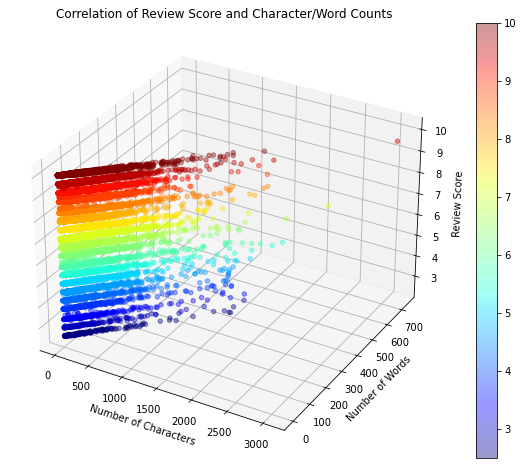

In [170]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')

x = df['nb_chars']
y = df['nb_words']
z = df['review_score']
c = df['review_score']
s = df['total_reviews']/100

ax.set_xlabel("Number of Characters")
ax.set_ylabel("Number of Words")
ax.set_zlabel("Review Score")

p = ax.scatter(x, y, z, c=c, alpha=0.4, cmap=plt.get_cmap('jet'),)
fig.colorbar(p, ax=ax)
plt.title("Correlation of Review Score and Character/Word Counts")
plt.show()

In [171]:
df[["nb_chars", "nb_words"]].describe().T

count        mean         std  min   25%    50%    75%     max
nb_chars  50660.0  150.280576  162.831704  3.0  52.0  102.0  190.0  3070.0
nb_words  50660.0   33.721970   38.708509  1.0  10.0   22.0   43.0   733.0

## 6.5  **Data Visualisation - Most Used Tokens in Recommend vs Not Recommend Class** <a class="anchor" id="rec_words"></a>

#### Deep Dive - Good vs Bad Reviews 

In [172]:
# We divide the dataset into two according to the class: positive and negative
pos_review = df["pos_review_clean"].astype(str)
neg_review = df["neg_review_clean"].astype(str)

In [173]:
# FUNCTION TO CREATE COUNT FREQUENCY FOR WORDS 
def frequency_tokens(list_): 
    # Create empty dictionary
    frequency = {} 
    for item in list_: 
        if (item in frequency): 
            frequency[item] += 1
        else: 
            frequency[item] = 1
    return frequency

In [174]:
# FOR GOOD REVIEW SUBSET
# We extract the tokens from all the texts and put them in a common list:
list_tokens_pos = list()
for i in pos_review:
    # Tokenize each document with word_tokenize()
    tokens_document = word_tokenize(i)
    # We add those tokens as new elements
    # If we use append a list of lists would be created, in this way we add the Elements of the second list
    list_tokens_pos.extend(tokens_document)

# calculate the frequency in good review subset
dict_freq_pos = frequency_tokens(list_tokens_pos)

In [175]:
# FOR BAD REVIEW SUBSET
# We extract the tokens from all the texts and put them in a common list:
list_tokens_neg = list()
for i in neg_review:
    # Tokenize each document with word_tokenize()
    tokens_document = word_tokenize(i)
    # We add those tokens as new elements
    # If we use append a list of lists would be created, in this way we add the Elements of the second list
    list_tokens_neg.extend(tokens_document)

# calculate the frequency in bad review subset
dict_freq_neg = frequency_tokens(list_tokens_neg)

CPU times: total: 203 ms
Wall time: 211 ms


Text(0.5, 1.0, 'Most Used tokens in the Not Recommend Class')

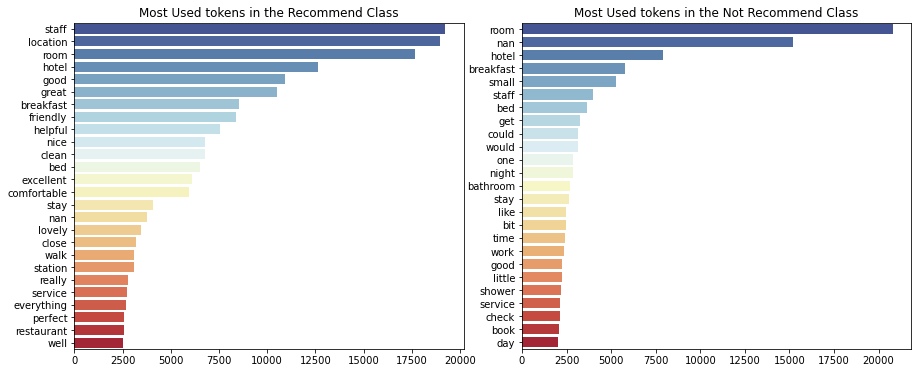

In [176]:
%%time 
# Sort the dictionary by the frequency of its words FOR GOOD REVIEW SUBSET
dict_freq_order_pos = sorted(dict_freq_pos.items(), key=lambda x: x[1], reverse=True)
token_names_pos = list()
token_freqs_pos = list()
for i in dict_freq_order_pos:
    if i[1] > 2500: # to adjust this number accordingly
        token_names_pos.append(i[0])
        token_freqs_pos.append(i[1])

# Sort the dictionary by the frequency of its words FOR BAD REVIEW SUBSET
dict_freq_order_neg = sorted(dict_freq_neg.items(), key=lambda x: x[1], reverse=True)
token_names_neg = list()
token_freqs_neg = list()
for i in dict_freq_order_neg:
    if i[1] > 2000: # to adjust this number accordingly
        token_names_neg.append(i[0])
        token_freqs_neg.append(i[1])
        
# DATA VISUALISATION FOR MOST USED TOKENS IN RECOMMEND VS NOT RECOMMEND SUBSET
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.subplots_adjust(wspace=0.15)

sns.barplot(y=token_names_pos, x=token_freqs_pos, palette="RdYlBu_r",ax=ax1)
sns.barplot(y=token_names_neg, x=token_freqs_neg, palette="RdYlBu_r",ax=ax2)

ax1.set_title("Most Used tokens in the Recommend Class", fontsize=12)
ax2.set_title("Most Used tokens in the Not Recommend Class", fontsize=12)

## 6.6  **Word Clouds - Token, Bigrams, Trigrams** <a class="anchor" id="wordcloud"></a>

#### Creating Bigram & Trigram in Dataset 

In [177]:
# convert to string format
df['pos_review_clean'] = df['pos_review_clean'].astype(str)
df['neg_review_clean'] = df['neg_review_clean'].astype(str)

In [178]:
# Creating bigram and trigram using NLP
df['bigrams_pos'] = df['pos_review_clean'].apply(lambda x: list(nltk.bigrams(word_tokenize(x))))
df['bigrams_neg'] = df['neg_review_clean'].apply(lambda x: list(nltk.bigrams(word_tokenize(x))))
df['trigrams_pos'] = df['pos_review_clean'].apply(lambda x: list(nltk.trigrams(word_tokenize(x))))
df['trigrams_neg'] = df['neg_review_clean'].apply(lambda x: list(nltk.trigrams(word_tokenize(x))))
df.head(1)

hotel_add  addtl_score review_date  \
0  Prinses Irenestraat 30 Zuideramstel 1077 WX Am...          726  2017-03-06   

   avg_score          hotel_name reviewer_nationality  \
0        8.6  citizenM Amsterdam       United Kingdom   

                             neg_review  tot_neg_words  total_reviews  \
0   How far away it was from everything              8           4530   

                            pos_review  tot_pos_words  reviews_given  \
0   The room was lovely and very comfy              8              2   

   review_score                                               tags        lat  \
0           8.3  [' Leisure trip ', ' Couple ', ' Double Room '...  52.341943   

       lng recommend   hotel_ctry reviewer_continent  month  year  day  \
0  4.87596       Yes  Netherlands             Europe      3  2017    6   

  trip_type    whom  duration  \
0   leisure  Couple         3   

                                         comb_review   pos_review_clean  \
0   The room was lovely and very comfy How far aw...  room lovely comfy   

      neg_review_clean                      comb_review_clean  nb_chars  \
0  far away everything  room lovely comfy far away everything        57   

   nb_words  word_density                        bigrams_pos  \
0        14           4.1  [(room, lovely), (lovely, comfy)]   

                         bigrams_neg             trigrams_pos  \
0  [(far, away), (away, everything)]  [(room, lovely, comfy)]   

                trigrams_neg  
0  [(far, away, everything)]

#### Bigram for High & Low Review Scores 

In [179]:
%%time
# Slice of dataset for review score > 8
bigrams_positive = df[df.review_score >8]['bigrams_pos'].tolist()
# Title of bigram Frequency of positive bigrams
bigrams_positive_list = list(chain(bigrams_positive))

#Frequency of positive bigrams
bigram_positive_counts = Counter(list(chain(*bigrams_positive_list)))

# Let's extract the top 10
bigram_positive_counts.most_common(10)

# https://stackoverflow.com/questions/62525780/how-to-create-wordcloud-showing-most-common-bigrams-in-a-text-using-python
# create database for positive bigram
bigram_ngram_pos_list = [" ".join(p[0]) for p in bigram_positive_counts.most_common()]
cnt_list = [p[1] for p in bigram_positive_counts.most_common(50)]
bigram_pos_df = pd.DataFrame(list(zip(bigram_ngram_pos_list, cnt_list)), columns=['bigram', 'cnt'])
bigram_pos_df["bigram"] = bigram_pos_df["bigram"].str.replace(" ", "_")
bigram_pos_list = bigram_pos_df["bigram"]
bigram_pos_list

CPU times: total: 281 ms
Wall time: 282 ms


0          great_location
1          friendly_staff
2          staff_friendly
3        friendly_helpful
4           helpful_staff
5           staff_helpful
6           good_location
7         comfortable_bed
8      excellent_location
9              room_clean
10         location_great
11              comfy_bed
12       comfortable_room
13        bed_comfortable
14            staff_great
15       helpful_friendly
16         good_breakfast
17          walk_distance
18             clean_room
19            minute_walk
20      clean_comfortable
21            value_money
22        staff_excellent
23     location_excellent
24         breakfast_good
25       perfect_location
26       room_comfortable
27       location_perfect
28         location_staff
29            great_staff
30          location_good
31            hotel_staff
32              room_good
33            hotel_great
34             room_great
35             staff_good
36        staff_extremely
37       would_definitely
38          

In [180]:
%%time
# Slice of dataset for recommend no only
bigrams_negative = df[df.review_score < 7]['bigrams_neg'].tolist()

# Title of bigram Frequency of negative bigrams
bigrams_negative_list = list(chain(bigrams_negative))

#Frequency of negative bigrams
bigram_negative_counts = Counter(list(chain(*bigrams_negative_list)))

# Let's extract the top 10
bigram_negative_counts.most_common(50)

# create database for negative bigram
bigram_ngram_neg_list = [" ".join(p[0]) for p in bigram_negative_counts.most_common()]
cnt_list = [p[1] for p in bigram_negative_counts.most_common(50)]
bigram_neg_df = pd.DataFrame(list(zip(bigram_ngram_neg_list, cnt_list)), columns=['bigram', 'cnt'])
bigram_neg_df["bigram"] = bigram_neg_df["bigram"].str.replace(" ", "_")
bigram_neg_list = bigram_neg_df["bigram"]
bigram_neg_list

CPU times: total: 109 ms
Wall time: 119 ms


0            room_small
1            small_room
2            star_hotel
3          room_service
4         air_condition
5              book_com
6            room_clean
7           value_money
8            front_desk
9            double_bed
10           hotel_room
11             get_room
12            room_tiny
13          double_room
14          even_though
15          change_room
16              air_con
17      reception_staff
18           staff_rude
19            hot_water
20             next_day
21            come_back
22          credit_card
23           could_hear
24            room_room
25           tea_coffee
26    bed_uncomfortable
27           room_ready
28           stay_hotel
29            look_like
30            per_night
31            one_night
32            size_room
33       staff_friendly
34            room_book
35       breakfast_poor
36           clean_room
37        work_properly
38         another_room
39           single_bed
40          first_night
41            fo

#### Trigram - Positive & Negative 

In [181]:
%%time
# Slice of dataset for review score >= 8
trigrams_positive = df[df.review_score > 8]['trigrams_pos'].tolist()
# Title of trigrams Frequency of positive trigrams
trigrams_positive_list = list(chain(trigrams_positive))

#Frequency of positive trigrams
trigram_positive_counts = Counter(list(chain(*trigrams_positive_list)))

# Let's extract the top 10
trigram_positive_counts.most_common(50)

# https://stackoverflow.com/questions/62525780/how-to-create-wordcloud-showing-most-common-bigrams-in-a-text-using-python
# create database for positive trigram
trigram_ngram_pos_list = [" ".join(p[0]) for p in trigram_positive_counts.most_common()]
cnt_list = [p[1] for p in trigram_positive_counts.most_common(50)]
trigram_pos_df = pd.DataFrame(list(zip(trigram_ngram_pos_list, cnt_list)), columns=['trigram', 'cnt'])
trigram_pos_df["trigram"] = trigram_pos_df["trigram"].str.replace(" ", "_")
trigram_pos_list = trigram_pos_df["trigram"]
trigram_pos_list

CPU times: total: 312 ms
Wall time: 313 ms


0         staff_friendly_helpful
1         friendly_helpful_staff
2        location_friendly_staff
3         staff_helpful_friendly
4           staff_great_location
5          would_definitely_stay
6           hotel_great_location
7           within_walk_distance
8               good_value_money
9        staff_extremely_helpful
10          nothing_much_trouble
11        helpful_friendly_staff
12        room_clean_comfortable
13       great_location_friendly
14             great_value_money
15          friendly_staff_great
16          room_comfortable_bed
17         friendly_helpful_room
18           friendly_staff_good
19      staff_extremely_friendly
20           helpful_staff_great
21        would_highly_recommend
22          friendly_staff_clean
23          staff_really_helpful
24           staff_friendly_room
25           staff_good_location
26           room_friendly_staff
27          great_location_great
28    would_definitely_recommend
29        clean_comfortable_room
30        

In [182]:
%%time
# Slice of dataset for recommend no only
trigrams_negative = df[df.review_score < 7]['trigrams_neg'].tolist()

# Title of trigram Frequency of negative trigrams
trigrams_negative_list = list(chain(trigrams_negative))

#Frequency of negative bigrams
trigram_negative_counts = Counter(list(chain(*trigrams_negative_list)))

# Let's extract the top 10
trigram_negative_counts.most_common(50)

# create database for negative trigram
trigram_ngram_neg_list = [" ".join(p[0]) for p in trigram_negative_counts.most_common()]
cnt_list = [p[1] for p in trigram_negative_counts.most_common(50)]
trigram_neg_df = pd.DataFrame(list(zip(trigram_ngram_neg_list, cnt_list)), columns=['trigram', 'cnt'])
trigram_neg_df["trigram"] = trigram_neg_df["trigram"].str.replace(" ", "_")
trigram_neg_list = trigram_neg_df["trigram"]
trigram_neg_list

CPU times: total: 125 ms
Wall time: 136 ms


0          air_condition_work
1             four_star_hotel
2        room_extremely_small
3         room_small_bathroom
4              two_single_bed
5              room_small_bed
6          air_condition_unit
7            poor_value_money
8                air_con_work
9            front_desk_staff
10          bed_push_together
11          expect_star_hotel
12         room_air_condition
13           good_value_money
14            room_double_bed
15           small_room_small
16             make_feel_like
17           room_quite_small
18       air_conditioner_work
19              king_size_bed
20          room_really_small
21              book_book_com
22            tea_coffee_room
23        tea_coffee_facility
24              fire_alarm_go
25         air_condition_room
26             room_next_door
27          room_ground_floor
28           book_double_room
29             stay_one_night
30            wall_paper_thin
31      poor_customer_service
32      would_recommend_hotel
33        

### WordCloud Visualisation

In [183]:
%%time
# WORD CLOUD TO VISUALISE
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color,
                      width=800,
                      height=500,
                      max_words=500, 
                      contour_width=0, 
                      contour_color='steelblue', 
                      scale =3).generate(words)
    plt.figure(1, figsize = (5, 4))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


Recommend Review - Tokens


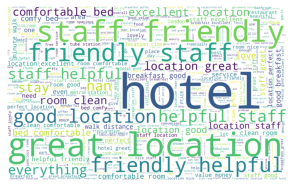

CPU times: total: 5.36 s
Wall time: 5.36 s


In [184]:
%%time
# Print the most common words in recommend subset
print("Recommend Review - Tokens")
wordcloud_draw(pos_review,'white')

Not Recommend Review - Tokens


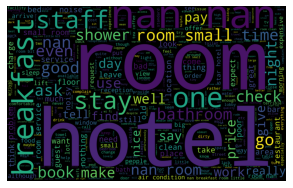

CPU times: total: 4.94 s
Wall time: 4.93 s


In [185]:
%%time
# Print the most common words in not recommend subset
print("Not Recommend Review - Tokens")
wordcloud_draw(neg_review)

Recommend Reviews - Bigrams


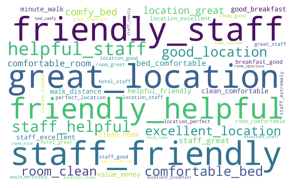

CPU times: total: 1.38 s
Wall time: 1.39 s


In [186]:
%%time
# Print the most common bigram in recommend subset
print("Recommend Reviews - Bigrams")
wordcloud_draw(bigram_pos_list,'white')

Not Recommend Reviews - Bigrams


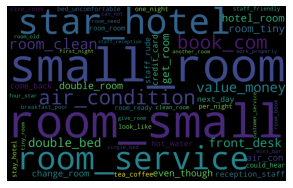

CPU times: total: 1.3 s
Wall time: 1.39 s


In [187]:
%%time
# Print the most common bigram in not recommend subset
print("Not Recommend Reviews - Bigrams")
wordcloud_draw(bigram_neg_list,'black')

Recommend Reviews - Triigrams


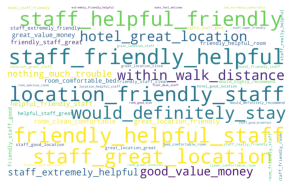

CPU times: total: 1.5 s
Wall time: 1.49 s


In [188]:
%%time
# Print the most common trigram in recommend subset
print("Recommend Reviews - Triigrams")
wordcloud_draw(trigram_pos_list,'white')

Not Recommend Reviews - Triigrams


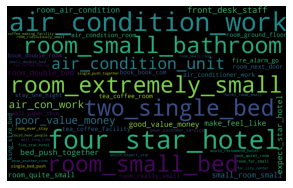

CPU times: total: 1.28 s
Wall time: 1.28 s


In [189]:
%%time
# Print the most common trigram in not recommend subset
print("Not Recommend Reviews - Triigrams")
wordcloud_draw(trigram_neg_list,'black')

#### Checking Dataset 

In [190]:
df.isnull().sum()

hotel_add                   0
addtl_score                 0
review_date                 0
avg_score                   0
hotel_name                  0
reviewer_nationality       55
neg_review              14879
tot_neg_words               0
total_reviews               0
pos_review               3730
tot_pos_words               0
reviews_given               0
review_score                0
tags                        0
lat                         0
lng                         0
recommend                   0
hotel_ctry                  0
reviewer_continent          0
month                       0
year                        0
day                         0
trip_type                   0
whom                        0
duration                    0
comb_review                 0
pos_review_clean            0
neg_review_clean            0
comb_review_clean          57
nb_chars                    0
nb_words                    0
word_density                0
bigrams_pos                 0
bigrams_ne

In [191]:
print(df.shape)
df.tail(1)

(50660, 36)


hotel_add  addtl_score  \
50659  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50659  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50659             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50659           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50659  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50659        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review pos_review_clean  \
50659  Couple         4   Bed Not enough coffee No milk              bed   

         neg_review_clean       comb_review_clean  nb_chars  nb_words  \
50659  enough coffee milk  bed enough coffee milk        24         6   

       word_density bigrams_pos                         bigrams_neg  \
50659           4.0          []  [(enough, coffee), (coffee, milk)]   

      trigrams_pos              trigrams_neg  
50659           []  [(enough, coffee, milk)]

In [192]:
df["recommend"].value_counts(dropna=False, normalize=True)

Yes    0.65
No     0.35
Name: recommend, dtype: float64

In [193]:
# output file for cleaned data
df.to_csv('df_pre_sentiment.csv',index=False)

#### Feature Engineering - Sentiment Analysis 

In [194]:
df = pd.read_csv('df_pre_sentiment.csv')
print(df.shape)
df.tail(1)

(50660, 36)


hotel_add  addtl_score  \
50659  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50659  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50659             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50659           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50659  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50659        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review pos_review_clean  \
50659  Couple         4   Bed Not enough coffee No milk              bed   

         neg_review_clean       comb_review_clean  nb_chars  nb_words  \
50659  enough coffee milk  bed enough coffee milk        24         6   

       word_density bigrams_pos                                 bigrams_neg  \
50659           4.0          []  [('enough', 'coffee'), ('coffee', 'milk')]   

      trigrams_pos                    trigrams_neg  
50659           []  [('enough', 'coffee', 'milk')]

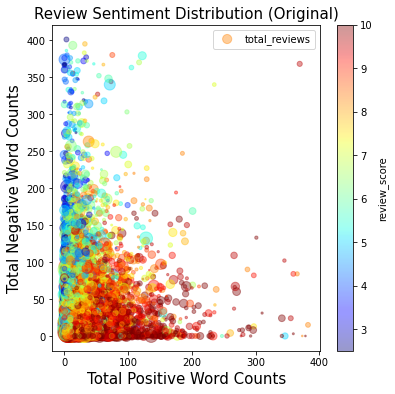

In [195]:
df.plot(kind='scatter', 
                      x='tot_pos_words', 
                      y='tot_neg_words', 
                      label='total_reviews',
             s=df.total_reviews/100,
             c='review_score',
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(6, 6),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Sentiment Distribution (Original)",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()

## 6.7  **Vader Sentiment Analysis** <a class="anchor" id="vader"></a>

We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. 
We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. 
It also takes into accout the context of the sentences to determine the sentiment scores. 
For each text, Vader retuns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [196]:
df["comb_review"] = df["comb_review"].astype(str)

In [197]:
%%time
sid = SentimentIntensityAnalyzer()
df["vader_score"] = df["comb_review"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['vader_score'], axis=1), df['vader_score'].apply(pd.Series)], axis=1)

CPU times: total: 44.2 s
Wall time: 45 s


In [198]:
print(df.shape)
df.tail(1)

(50660, 40)


hotel_add  addtl_score  \
50659  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50659  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50659             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50659           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50659  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50659        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review pos_review_clean  \
50659  Couple         4   Bed Not enough coffee No milk              bed   

         neg_review_clean       comb_review_clean  nb_chars  nb_words  \
50659  enough coffee milk  bed enough coffee milk        24         6   

       word_density bigrams_pos                                 bigrams_neg  \
50659           4.0          []  [('enough', 'coffee'), ('coffee', 'milk')]   

      trigrams_pos                    trigrams_neg  neg    neu    pos  \
50659           []  [('enough', 'coffee', 'milk')]  0.0  0.726  0.274   

       compound  
50659    0.2235

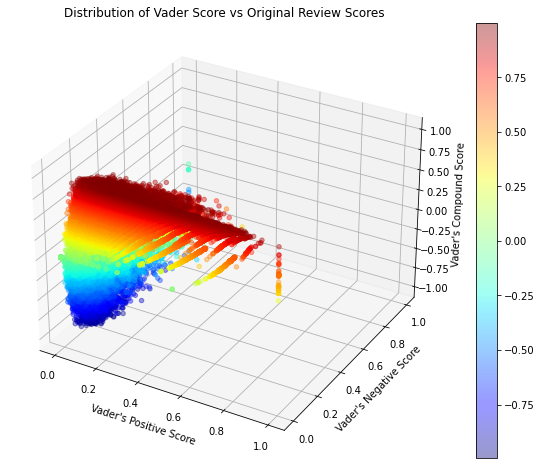

In [199]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')

x = df['pos']
y = df['neg']
z = df['compound']
c = df['compound']
s = df['total_reviews']/100

ax.set_xlabel("Vader's Positive Score")
ax.set_ylabel("Vader's Negative Score")
ax.set_zlabel("Vader's Compound Score")

p = ax.scatter(x, y, z, c=c, alpha=0.4, cmap=plt.get_cmap('jet'),)
fig.colorbar(p, ax=ax)
plt.title("Distribution of Vader Score vs Original Review Scores")
plt.show()

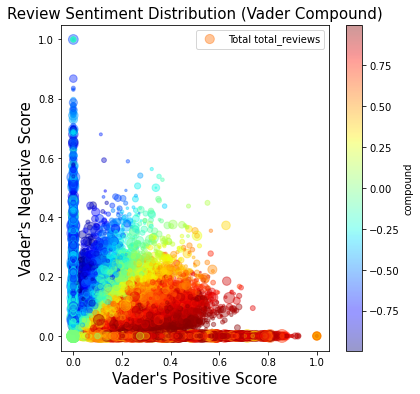

In [200]:
df.plot(kind='scatter', 
                      x='pos', 
                      y='neg', 
                      label='Total total_reviews',
             s=df.total_reviews/100,
             c='compound', # based on vader compound
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(6, 6),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Sentiment Distribution (Vader Compound)",  fontsize=font_size)
plt.xlabel("Vader's Positive Score", fontsize=font_size)
plt.ylabel("Vader's Negative Score",  fontsize=font_size)
plt.legend()
plt.show()

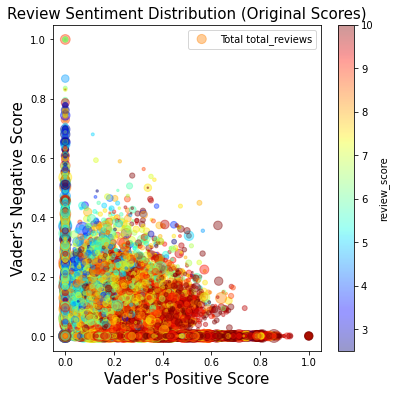

In [201]:
df.plot(kind='scatter', 
                      x='pos', 
                      y='neg', 
                      label='Total total_reviews',
             s=df.total_reviews/100,
             c='review_score', # based on overall review score
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(6,6),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Sentiment Distribution (Original Scores)",  fontsize=font_size)
plt.xlabel("Vader's Positive Score", fontsize=font_size)
plt.ylabel("Vader's Negative Score",  fontsize=font_size)
plt.legend()
plt.show()

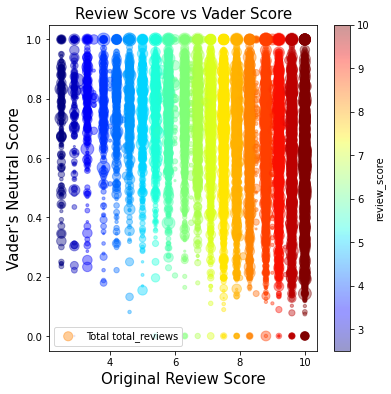

In [202]:
df.plot(kind='scatter', 
                      x='review_score', 
                      y='neu', 
                      label='Total total_reviews',
             s=df.total_reviews/100,
             c='review_score', # based on overall review score
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(6,6),
             sharex=False, # label not showing up 
             # https://stackoverflow.com/a/69661993/11105356 
             )
font_size = 15
plt.title("Review Score vs Vader Score",  fontsize=font_size)
plt.xlabel("Original Review Score", fontsize=font_size)
plt.ylabel("Vader's Neutral Score",  fontsize=font_size)
plt.legend()
plt.show()

In [203]:
# Let's see how vader sentiment analysis is like
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5 ].sort_values("compound", ascending = False)[["comb_review", "pos", "neg", "neu", "compound"]].head(5)

comb_review    pos    neg    neu  \
48568   From booking to checking out is always a grea...  0.320  0.000  0.680   
42691   Superb location just a minute from the metro ...  0.218  0.016  0.765   
4480    The view was superb The room is small but cle...  0.394  0.008  0.598   
19297   The hotel is 5 min walk from last ramblas and...  0.221  0.013  0.765   
63      1 This is an old but well maintained hotel 2 ...  0.202  0.032  0.766   

       compound  
48568    0.9989  
42691    0.9987  
4480     0.9987  
19297    0.9984  
63       0.9982

In [204]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("compound", ascending = True)[["comb_review", "pos", "neg", "neu", "compound"]].head(5)

comb_review    pos    neg    neu  \
12894   NOTHING AT ALL  I strictly advised at my book...  0.031  0.197  0.772   
7523    This hotel is rated as 4 star but should be 2...  0.014  0.146  0.841   
2625    Room decor was so bad Window was tiny and blo...  0.000  0.289  0.711   
20332   Breakfast was OK Stayed 8 nights The bed was ...  0.060  0.240  0.700   
41845   The beds were extremely comfortable and the b...  0.060  0.141  0.799   

       compound  
12894   -0.9940  
7523    -0.9914  
2625    -0.9900  
20332   -0.9890  
41845   -0.9888

In [205]:
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.tail(1)

(50660, 40)


hotel_add  addtl_score  \
50659  21 rue de Dunkerque 10th arr 75010 Paris France          740   

      review_date  avg_score                   hotel_name  \
50659  2015-08-26        7.4  Mercure Paris Terminus Nord   

      reviewer_nationality                  neg_review  tot_neg_words  \
50659             Thailand   Not enough coffee No milk              6   

       total_reviews pos_review  tot_pos_words  reviews_given  review_score  \
50659           5575        Bed              2              2           7.9   

                                                    tags        lat       lng  \
50659  [' Leisure trip ', ' Couple ', ' Standard Room...  48.879484  2.355654   

      recommend hotel_ctry reviewer_continent  month  year  day trip_type  \
50659        No     France               Asia      8  2015   26   leisure   

         whom  duration                     comb_review pos_review_clean  \
50659  Couple         4   Bed Not enough coffee No milk              bed   

         neg_review_clean       comb_review_clean  nb_chars  nb_words  \
50659  enough coffee milk  bed enough coffee milk        24         6   

       word_density bigrams_pos                                 bigrams_neg  \
50659           4.0          []  [('enough', 'coffee'), ('coffee', 'milk')]   

      trigrams_pos                    trigrams_neg  neg    neu    pos  \
50659           []  [('enough', 'coffee', 'milk')]  0.0  0.726  0.274   

       compound  
50659    0.2235

In [206]:
# output file for cleaned data
df.to_csv('df_pre_tfidf.csv',index=False)

## 6.8 **TFIDFVectorizer** <a class="anchor" id="tfidf"></a>

Vectorization

Once we have cleaned and processed the text, we are going to extract characteristics of each word and each document using TFIDFVectorizer (Term Frequency - Inverse Document Frequency) :

- unigrams, bigrams and trigrams
- with a maximum of 300 features
- That the system does not consider the elements that appear in less than 1% of the documents to reduce the size of the final output.

In [207]:
# Load dataset for post clean data
df = pd.read_csv("df_pre_tfidf.csv")
df.shape

(50660, 40)

In [208]:
df.isnull().sum()

hotel_add                   0
addtl_score                 0
review_date                 0
avg_score                   0
hotel_name                  0
reviewer_nationality       55
neg_review              14879
tot_neg_words               0
total_reviews               0
pos_review               3730
tot_pos_words               0
reviews_given               0
review_score                0
tags                        0
lat                         0
lng                         0
recommend                   0
hotel_ctry                  0
reviewer_continent          0
month                       0
year                        0
day                         0
trip_type                   0
whom                        0
duration                    0
comb_review                30
pos_review_clean         3787
neg_review_clean        15183
comb_review_clean          57
nb_chars                    0
nb_words                    0
word_density                0
bigrams_pos                 0
bigrams_ne

In [209]:
df["comb_review_clean"] = df["comb_review_clean"].astype(str)

In [210]:
%%time
# BoW Features
vectorizer = TfidfVectorizer(min_df=0.02, ngram_range=(1,3), max_features=300, lowercase=False)
vector_data = vectorizer.fit_transform(df["comb_review_clean"])
vector_data

CPU times: total: 7.88 s
Wall time: 7.98 s


<50660x166 sparse matrix of type '<class 'numpy.float64'>'
	with 462815 stored elements in Compressed Sparse Row format>

In [211]:
# Let's check the 166 features:
vector_data_voc = vectorizer.fit(df["comb_review_clean"])
vector_data_voc.vocabulary_

{'room': 126,
 'lovely': 89,
 'comfy': 32,
 'far': 52,
 'away': 8,
 'everything': 43,
 'clean': 26,
 'perfect': 112,
 'service': 131,
 'near': 97,
 'minute': 92,
 'walk': 156,
 'reception': 122,
 'extremely': 49,
 'helpful': 71,
 'give': 64,
 'great': 68,
 'restaurant': 124,
 'see': 130,
 'hotel': 75,
 'staff': 137,
 'friendly': 59,
 'bed': 14,
 'small': 135,
 'location': 82,
 'quite': 120,
 'central': 21,
 'staff friendly': 138,
 'good': 66,
 'air': 1,
 'easy': 39,
 'breakfast': 20,
 'outside': 108,
 'like': 80,
 'one': 106,
 'nothing': 104,
 'bathroom': 12,
 'back': 9,
 'park': 109,
 'charge': 22,
 'bar': 11,
 'food': 57,
 'friendly staff': 61,
 'facility': 50,
 'really': 121,
 'noise': 102,
 'night': 101,
 'hot': 74,
 'excellent': 44,
 'price': 116,
 'next': 99,
 'station': 141,
 'nice': 100,
 'day': 34,
 'comfortable': 30,
 'area': 4,
 'quiet': 119,
 'sleep': 134,
 'staff helpful': 139,
 'spacious': 136,
 'size': 133,
 'get': 63,
 'pay': 110,
 'well': 161,
 'water': 158,
 'extra': 

In [212]:
X_tfidf_df = pd.DataFrame(vector_data.toarray()) #name for fit_transform
X_tfidf_df.columns = vectorizer.get_feature_names_out() #name for TfidfVectorizer
X_tfidf_df.shape

(50660, 166)

In [213]:
# Preview tfidf dataset
X_tfidf_df.head(10)

access       air  also  amaze  area  around  arrive  ask      away  \
0     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.490878   
1     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   
2     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   
3     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.389873   
4     0.0  0.224382   0.0    0.0   0.0     0.0     0.0  0.0  0.472137   
5     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   
6     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   
7     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   
8     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   
9     0.0  0.000000   0.0    0.0   0.0     0.0     0.0  0.0  0.000000   

       back  bad       bar  bathroom  beautiful       bed  bed comfortable  \
0  0.000000  0.0  0.000000  0.000000        0.0  0.000000              0.0   
1  0.000000  0.0  0.000000  0.000000        0.0  0.000000              0.0   
2  0.000000  0.0  0.000000  0.000000        0.0  0.000000              0.0   
3  0.000000  0.0  0.000000  0.000000        0.0  0.224892              0.0   
4  0.000000  0.0  0.000000  0.174409        0.0  0.136172              0.0   
5  0.595889  0.0  0.000000  0.000000        0.0  0.000000              0.0   
6  0.000000  0.0  0.000000  0.000000        0.0  0.000000              0.0   
7  0.000000  0.0  0.378866  0.000000        0.0  0.000000              0.0   
8  0.000000  0.0  0.000000  0.000000        0.0  0.000000              0.0   
9  0.000000  0.0  0.000000  0.391190        0.0  0.000000              0.0   

   best  big  bit  book  breakfast   central    charge  check  choice  city  \
0   0.0  0.0  0.0   0.0   0.000000  0.000000  0.000000    0.0     0.0   0.0   
1   0.0  0.0  0.0   0.0   0.000000  0.000000  0.000000    0.0     0.0   0.0   
2   0.0  0.0  0.0   0.0   0.000000  0.000000  0.000000    0.0     0.0   0.0   
3   0.0  0.0  0.0   0.0   0.000000  0.372911  0.000000    0.0     0.0   0.0   
4   0.0  0.0  0.0   0.0   0.238582  0.000000  0.000000    0.0     0.0   0.0   
5   0.0  0.0  0.0   0.0   0.000000  0.000000  0.000000    0.0     0.0   0.0   
6   0.0  0.0  0.0   0.0   0.000000  0.000000  0.734926    0.0     0.0   0.0   
7   0.0  0.0  0.0   0.0   0.249445  0.000000  0.000000    0.0     0.0   0.0   
8   0.0  0.0  0.0   0.0   0.311454  0.000000  0.000000    0.0     0.0   0.0   
9   0.0  0.0  0.0   0.0   0.000000  0.000000  0.000000    0.0     0.0   0.0   

      clean  close  coffee  come  comfortable  comfortable bed     comfy  \
0  0.000000    0.0     0.0   0.0          0.0              0.0  0.426303   
1  0.300630    0.0     0.0   0.0          0.0              0.0  0.000000   
2  0.000000    0.0     0.0   0.0          0.0              0.0  0.000000   
3  0.000000    0.0     0.0   0.0          0.0              0.0  0.338585   
4  0.143481    0.0     0.0   0.0          0.0              0.0  0.000000   
5  0.000000    0.0     0.0   0.0          0.0              0.0  0.000000   
6  0.000000    0.0     0.0   0.0          0.0              0.0  0.000000   
7  0.000000    0.0     0.0   0.0          0.0              0.0  0.000000   
8  0.000000    0.0     0.0   0.0          0.0              0.0  0.000000   
9  0.000000    0.0     0.0   0.0          0.0              0.0  0.000000   

   could  day  definitely  desk  door  drink      easy  enough  even  every  \
0    0.0  0.0         0.0   0.0   0.0    0.0  0.000000     0.0   0.0    0.0   
1    0.0  0.0         0.0   0.0   0.0    0.0  0.000000     0.0   0.0    0.0   
2    0.0  0.0         0.0   0.0   0.0    0.0  0.000000     0.0   0.0    0.0   
3    0.0  0.0         0.0   0.0   0.0    0.0  0.000000     0.0   0.0    0.0   
4    0.0  0.0         0.0   0.0   0.0    0.0  0.224091     0.0   0.0    0.0   
5    0.0  0.0         0.0   0.0   0.0    0.0  0.000000     0.0   0.0    0.0   
6    0.0  0.0         0.0   0.0   0.0    0.0  0.000000     0.0   0.0    0.0   
7

## 6.9 Summmary of Review Text Analysis <a class="anchor" id="summary_text"></a>

* Most reviews averaged 250 words through top reviews can go beyond 450 words.
* Positive reviews tend to be longer than negative reviews.
* From the unigram analysis, it was observed that unigram removes context from the original review especially when they are used along with words like “not, no” which reverse the original intent of the review.
* From bigram, trigram analysis, we discovered several areas which are often mentioned in the reviews: <br>
  - Room size being small <br>
  - Air conditioning <br>
  - Room amentities like mini bar, wifi, bed, room service, bed  <br>
  - Hotel location, walking distance<br>
  - Helpful, friendly staff.<br>
* While Vader Sentiment Analysis is very useful, it might not fully converge to the eventual review score.

## 7. Modelling - Classification Models <a class="anchor" id="model"></a>

#### Helper Functions 

In [214]:
# helper function to show results and charts
# to call function: show_summary_report(y_test, y_pred, y_proba)
# actual refers to y_test
def show_summary_report(actual, prediction, probabilities):
    
    # If actual labels is a Series, extract the array
    if isinstance(actual, pd.Series):
        actual = actual.values
    # If actual and/or prediction labels are strings, convert to integers
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)
        
    # Calculate model evaluation metrics
    accuracy_ = accuracy_score(actual, prediction)*100
    precision_ = precision_score(actual, prediction)*100
    recall_ = recall_score(actual, prediction)*100
    f1_ = f1_score(actual, prediction, zero_division=1)*100
    roc_auc_ = roc_auc_score(actual, probabilities)*100  

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('F1 Score : %.4f                                                                     Best: 1, Worst: 0' % f1_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples') 

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.25)

    """
    # Confusion Matrix     
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, ax = ax[0], annot_kws={"size": 20})
    ax[0].set_title('Confusion Matrix with labels\n\n');
    ax[0].set_xlabel('\nPredicted Values', fontsize=24)
    ax[0].set_ylabel('Actual Values ', fontsize=24);

    ## Ticket labels - List must be in alphabetical order
    ax[0].xaxis.set_ticklabels(['False','True'], fontsize=18)
    ax[0].yaxis.set_ticklabels(['False','True'], fontsize=18)
    """
    
    #https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    
    # Confusion Matrix    
    cm = confusion_matrix(actual, prediction)
    
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    print(cm)
    print("TP", TP, "TN", TN, "FP", FP, "FN", FN)
    
    modified_cm = []
    for index,value in enumerate(cm):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])    

    # Confusion Matrix
    sns.heatmap(cm, square = True, annot = modified_cm, fmt = "", cbar = 'YlGnBu', 
                annot_kws={"size": 18}, linewidths=.5, ax = ax[0])
    
    #labels = ['Positive', 'Negative']
    labels = ['Negative', 'Positive']
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('Actual label')
    ax[0].set_yticklabels(labels, fontsize=12)
    ax[0].set_xticklabels(labels, fontsize=12)
    
    print(classification_report(actual, prediction))
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'g', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'g', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    #ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, f1_, roc_auc_)

In [215]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

####  Prepare Feature and Target Columns

In [216]:
# Update recommend column to integer
df["recommend"] = df["recommend"].replace({"Yes":1, "No":0})
print(df["recommend"].value_counts())
y = df["recommend"]
y.head(1)

1    32929
0    17731
Name: recommend, dtype: int64


0    1
Name: recommend, dtype: int64

#### Which Features to Include? 

In [217]:
print(X_tfidf_df.shape)
X_tfidf_df.tail(1)

(50660, 166)


access  air  also  amaze  area  around  arrive  ask  away  back  bad  \
50659     0.0  0.0   0.0    0.0   0.0     0.0     0.0  0.0   0.0   0.0  0.0   

       bar  bathroom  beautiful       bed  bed comfortable  best  big  bit  \
50659  0.0       0.0        0.0  0.396154              0.0   0.0  0.0  0.0   

       book  breakfast  central  charge  check  choice  city  clean  close  \
50659   0.0        0.0      0.0     0.0    0.0     0.0   0.0    0.0    0.0   

         coffee  come  comfortable  comfortable bed  comfy  could  day  \
50659  0.615065   0.0          0.0              0.0    0.0    0.0  0.0   

       definitely  desk  door  drink  easy    enough  even  every  everything  \
50659         0.0   0.0   0.0    0.0   0.0  0.681731   0.0    0.0         0.0   

       excellent  excellent location  expect  expensive  extra  extremely  \
50659        0.0                 0.0     0.0        0.0    0.0        0.0   

       facility  fantastic  far  feel  find  first  floor  food  free  \
50659       0.0        0.0  0.0   0.0   0.0    0.0    0.0   0.0   0.0   

       friendly  friendly helpful  friendly staff  front  get  give   go  \
50659       0.0               0.0             0.0    0.0  0.0   0.0  0.0   

       good  good location  great  great location  help  helpful  \
50659   0.0            0.0    0.0             0.0   0.0      0.0   

       helpful staff  high  hot  hotel  include  large  leave  light  like  \
50659            0.0   0.0  0.0    0.0      0.0    0.0    0.0    0.0   0.0   

       little  location  location good  location great  london  look  lot  \
50659     0.0       0.0            0.0             0.0     0.0   0.0  0.0   

       love  lovely  make  metro  minute  modern  money  morning  much  near  \
50659   0.0     0.0   0.0    0.0     0.0     0.0    0.0      0.0   0.0   0.0   

       need  next  nice  night  noise  noisy  nothing  old  one  open  \
50659   0.0   0.0   0.0    0.0    0.0    0.0      0.0  0.0  0.0   0.0   

       outside  park  pay  people  perfect  place  pool  poor  price  problem  \
50659      0.0   0.0  0.0     0.0      0.0    0.0   0.0   0.0    0.0      0.0   

       quality  quiet  quite  really  reception  recommend  restaurant  right  \
50659      0.0    0.0    0.0     0.0        0.0        0.0         0.0    0.0   

       room  room clean  room small  say  see  service  shower  size  sleep  \
50659   0.0         0.0         0.0  0.0  0.0      0.0     0.0   0.0    0.0   

       small  spacious  staff  staff friendly  staff helpful  star  station  \
50659    0.0       0.0    0.0             0.0            0.0   0.0      0.0   

       stay  street  take  tea  thing  think  time  train  tube   tv  two  \
50659   0.0     0.0   0.0  0.0    0.0    0.0   0.0    0.0   0.0  0.0  0.0   

       use  value  view  walk  want  water  way  welcome  well  wifi  window  \
50659  0.0    0.0   0.0   0.0   0.0    0.0  0.0      0.0   0.0   0.0     0.0   

       work  would  
50659   0.0    0.0

In [218]:
# Join TFID with the Vader features
vader = df[["neg","neu","pos","compound",]]
vader.head(1)

neg    neu    pos  compound
0  0.0  0.774  0.226    0.5859

In [219]:
X = pd.concat([vader, X_tfidf_df, ], axis=1)
X.tail(1)

neg    neu    pos  compound  access  air  also  amaze  area  around  \
50659  0.0  0.726  0.274    0.2235     0.0  0.0   0.0    0.0   0.0     0.0   

       arrive  ask  away  back  bad  bar  bathroom  beautiful       bed  \
50659     0.0  0.0   0.0   0.0  0.0  0.0       0.0        0.0  0.396154   

       bed comfortable  best  big  bit  book  breakfast  central  charge  \
50659              0.0   0.0  0.0  0.0   0.0        0.0      0.0     0.0   

       check  choice  city  clean  close    coffee  come  comfortable  \
50659    0.0     0.0   0.0    0.0    0.0  0.615065   0.0          0.0   

       comfortable bed  comfy  could  day  definitely  desk  door  drink  \
50659              0.0    0.0    0.0  0.0         0.0   0.0   0.0    0.0   

       easy    enough  even  every  everything  excellent  excellent location  \
50659   0.0  0.681731   0.0    0.0         0.0        0.0                 0.0   

       expect  expensive  extra  extremely  facility  fantastic  far  feel  \
50659     0.0        0.0    0.0        0.0       0.0        0.0  0.0   0.0   

       find  first  floor  food  free  friendly  friendly helpful  \
50659   0.0    0.0    0.0   0.0   0.0       0.0               0.0   

       friendly staff  front  get  give   go  good  good location  great  \
50659             0.0    0.0  0.0   0.0  0.0   0.0            0.0    0.0   

       great location  help  helpful  helpful staff  high  hot  hotel  \
50659             0.0   0.0      0.0            0.0   0.0  0.0    0.0   

       include  large  leave  light  like  little  location  location good  \
50659      0.0    0.0    0.0    0.0   0.0     0.0       0.0            0.0   

       location great  london  look  lot  love  lovely  make  metro  minute  \
50659             0.0     0.0   0.0  0.0   0.0     0.0   0.0    0.0     0.0   

       modern  money  morning  much  near  need  next  nice  night  noise  \
50659     0.0    0.0      0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   

       noisy  nothing  old  one  open  outside  park  pay  people  perfect  \
50659    0.0      0.0  0.0  0.0   0.0      0.0   0.0  0.0     0.0      0.0   

       place  pool  poor  price  problem  quality  quiet  quite  really  \
50659    0.0   0.0   0.0    0.0      0.0      0.0    0.0    0.0     0.0   

       reception  recommend  restaurant  right  room  room clean  room small  \
50659        0.0        0.0         0.0    0.0   0.0         0.0         0.0   

       say  see  service  shower  size  sleep  small  spacious  staff  \
50659  0.0  0.0      0.0     0.0   0.0    0.0    0.0       0.0    0.0   

       staff friendly  staff helpful  star  station  stay  street  take  tea  \
50659             0.0            0.0   0.0      0.0   0.0     0.0   0.0  0.0   

       thing  think  time  train  tube   tv  two  use  value  view  walk  \
50659    0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0    0.0   0.0   0.0   

       want  water  way  welcome  well  wifi  window  work  would  
50659   0.0    0.0  0.0      0.0   0.0   0.0     0.0   0.0    0.0

## 7.1  **Base Model** <a class="anchor" id="base"></a>

In [251]:
# Define base model
# lr = LogisticRegression(C=0.1, penalty="l2", solver = "newton-cg", random_state=42)
lr = LogisticRegression()
#nb = GaussianNB ()

#### Variant 1: Base Model with SMOTE

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Balance any imbalanced dataset 
model = SMOTE(random_state =42)
X_train, y_train = model.fit_resample(X_train, y_train)

# Check values of outcomes before and after to ensure SMOTE is successful
print(y_train.value_counts())
print(len(X_train), len(y_train), len(X_test), len(y_test))

1    24697
0    24697
Name: recommend, dtype: int64
49394 49394 12665 12665


In [253]:
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy : 74.6230 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 84.7122 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 74.3805 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 79.2109                                                                     Best: 1, Worst: 0
ROC AUC  : 82.4187                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[3328 1105]
 [2109 6123]]
TP 6123 TN 3328 FP 1105 FN 2109
              precision    recall  f1-score   support

           0       0.61      0.75      0.67      4433
           1       0.85      0.74      0.79      8232

    accuracy                         

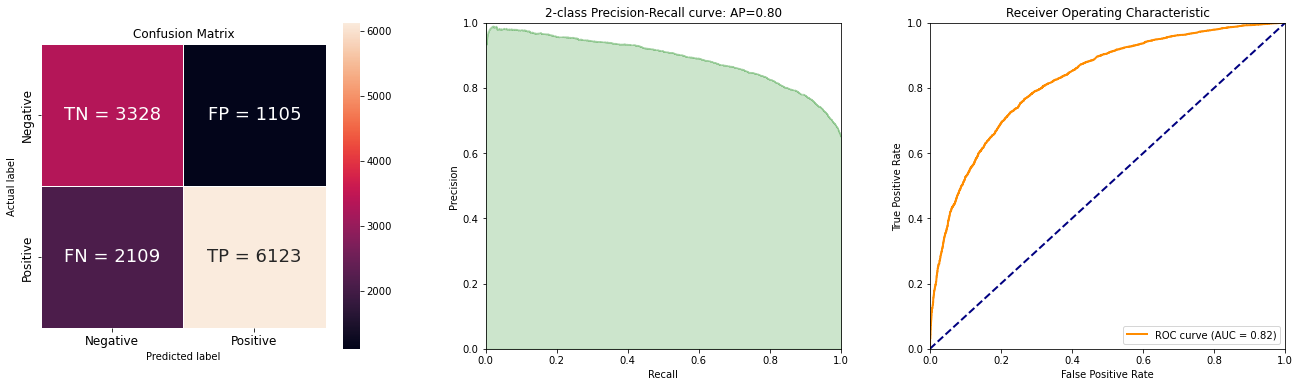

(74.6229767074615,
 84.71223021582733,
 74.38046647230321,
 79.21086675291073,
 82.41867716439802)

In [254]:
# Summary for base model
show_summary_report(y_test, y_pred, y_proba)

In [255]:
# CROSS VALIDATION FOR TFID
for i in tqdm_notebook(range(1)): 
    print("CV 5 fold score for training set")
    print(cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy'))
    train_cv_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy').mean()*100
    print("CV Training average score for base model : {} ".format(train_cv_score))
    print("")
    print("CV 5 fold score for testing set")
    print(cross_val_score(lr, X_test, y_test, cv=5, scoring='accuracy'))
    test_cv_score = cross_val_score(lr, X_test, y_test, cv=5, scoring='accuracy').mean()*100
    print("CV average score for base model : {} ".format(test_cv_score))

  0%|          | 0/1 [00:00<?, ?it/s]

CV 5 fold score for training set


C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[0.74329386 0.73752404 0.75412491 0.75179674 0.74083823]


C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

CV Training average score for base model : 74.55155549797826 

CV 5 fold score for testing set
[0.77852349 0.77339124 0.76036321 0.76707462 0.76628504]
CV average score for base model : 76.91275167785234 


## 7.2  **Other Ensemble Models** <a class="anchor" id="ensemble"></a>

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.30)

# Balance any imbalanced dataset 
#model = SMOTE(random_state =42)
#X_train, y_train = model.fit_resample(X_train, y_train)

# Check values of outcomes before and after to ensure SMOTE is successful
print(y_train.value_counts())
print(len(X_train), len(y_train), len(X_test), len(y_test))

1    23050
0    12412
Name: recommend, dtype: int64
35462 35462 15198 15198


In [226]:
lr = LogisticRegression(penalty="l2", solver = "newton-cg", verbose=0) 
nb = GaussianNB()
rfc = RandomForestClassifier(random_state=42, verbose=0)
xgb = XGBClassifier(random_state=42, verbose=0)
lgb = LGBMClassifier(random_state=42, verbose=0)

  0%|          | 0/1 [00:00<?, ?it/s]

******
* LR *
******
Accuracy : 77.4378 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 79.3235 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 88.3085 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.5752                                                                     Best: 1, Worst: 0
ROC AUC  : 82.8488                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[3045 2274]
 [1155 8724]]
TP 8724 TN 3045 FP 2274 FN 1155
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      5319
           1       0.79      0.88      0.84      9879

    accuracy    

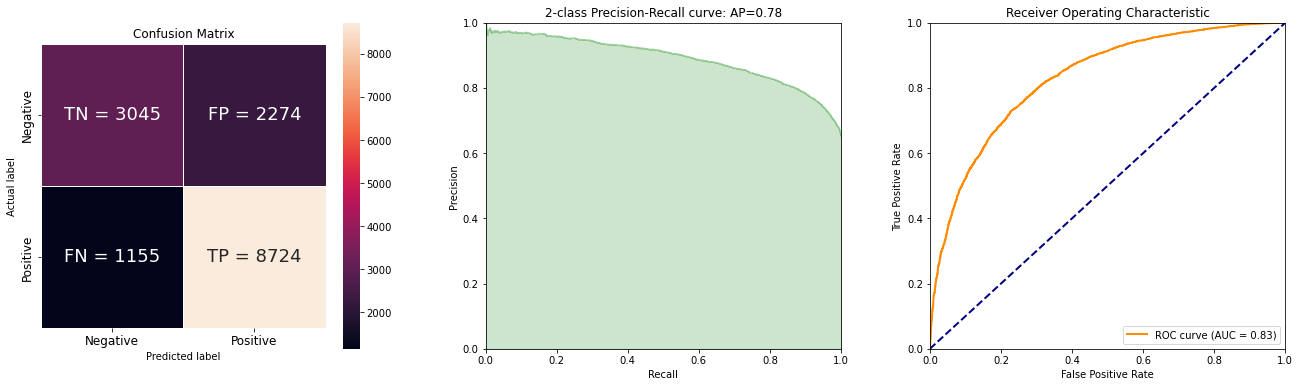

              precision    recall  f1-score   support

           0       0.72      0.57      0.64      5319
           1       0.79      0.88      0.84      9879

    accuracy                           0.77     15198
   macro avg       0.76      0.73      0.74     15198
weighted avg       0.77      0.77      0.77     15198


******
* NB *
******
Accuracy : 71.0093 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 82.2434 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 70.6549 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 76.0100                                                                     Best: 1, Worst: 0
ROC AUC  : 77.6378                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Posit

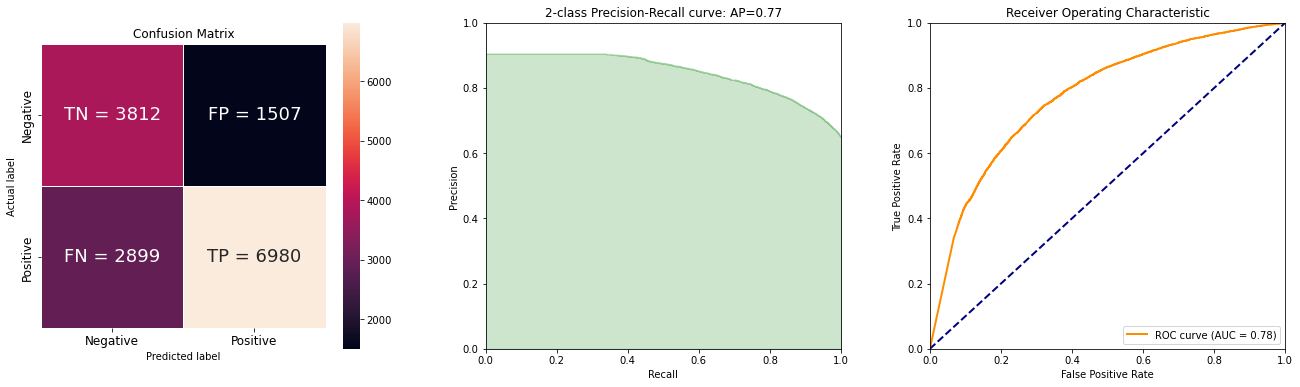

              precision    recall  f1-score   support

           0       0.57      0.72      0.63      5319
           1       0.82      0.71      0.76      9879

    accuracy                           0.71     15198
   macro avg       0.70      0.71      0.70     15198
weighted avg       0.73      0.71      0.72     15198


******
* RF *
******
Accuracy : 76.2074 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.7689 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.7902 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 82.5852                                                                     Best: 1, Worst: 0
ROC AUC  : 81.6206                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Posit

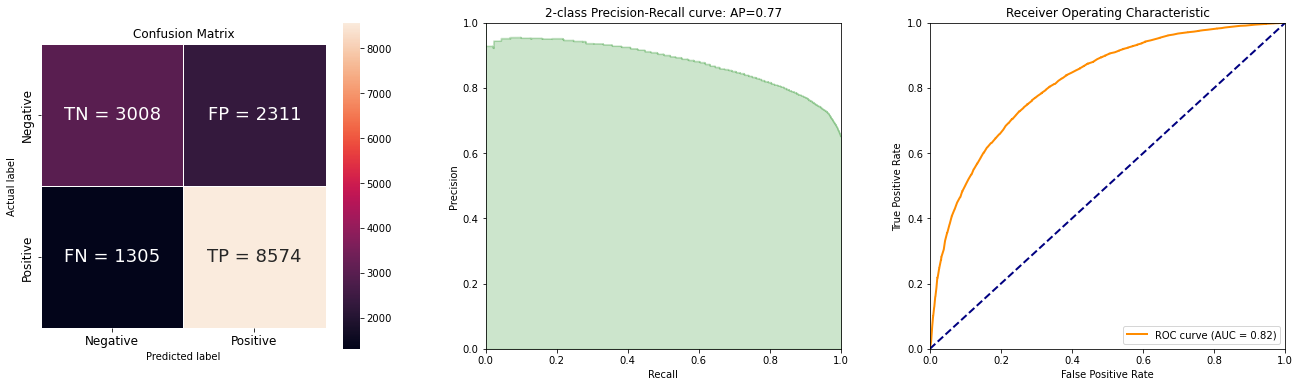

              precision    recall  f1-score   support

           0       0.70      0.57      0.62      5319
           1       0.79      0.87      0.83      9879

    accuracy                           0.76     15198
   macro avg       0.74      0.72      0.73     15198
weighted avg       0.76      0.76      0.76     15198


*******
* XGB *
*******
[21:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy : 76.8851 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 79.5763 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.6889 [TP

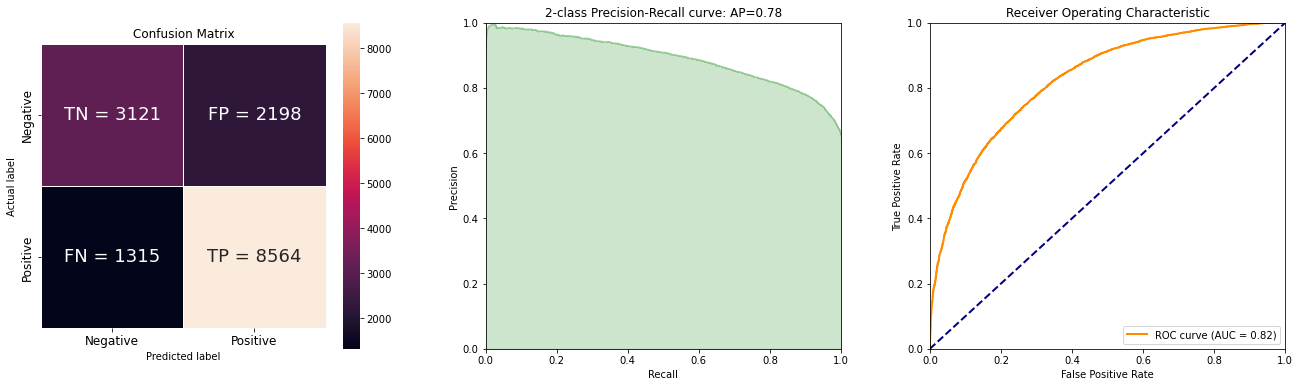

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      5319
           1       0.80      0.87      0.83      9879

    accuracy                           0.77     15198
   macro avg       0.75      0.73      0.73     15198
weighted avg       0.76      0.77      0.76     15198


*******
* LGM *
*******
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023728 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy : 77.2207 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 79.8326 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.9116 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.2219                                                                     B

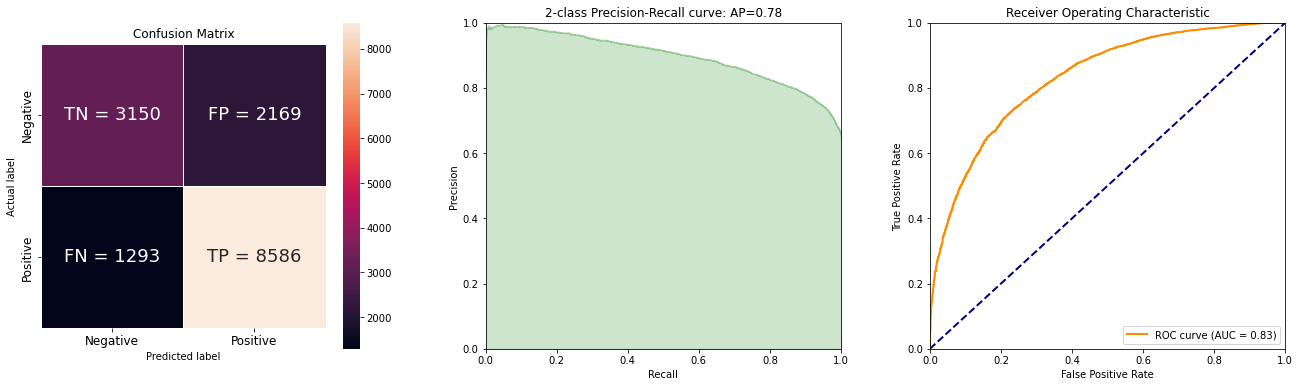

              precision    recall  f1-score   support

           0       0.71      0.59      0.65      5319
           1       0.80      0.87      0.83      9879

    accuracy                           0.77     15198
   macro avg       0.75      0.73      0.74     15198
weighted avg       0.77      0.77      0.77     15198


CPU times: total: 1min 52s
Wall time: 38.2 s


In [227]:
%%time

for i in tqdm_notebook(range(1)):
    # Keep the results in a dataframe
    results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Eval_time'])
       
    models = ["LR", 'NB', 'RF', 'XGB', 'LGM',]
    for i, m in enumerate([lr, nb, rfc, xgb, lgb,]):
        print('*' * (len(models[i]) + 4))
        print('* %s *' % models[i])
        print('*' * (len(models[i]) + 4))
        
        #measure start time of model
        start_time = time.time()
        
        #Fit the model to training data     
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        y_proba = m.predict_proba(X_test)[:, 1]
        
        #measure end time of model
        end_time = time.time()
        
        # show the report
        accuracy_, precision_, recall_, f1_, roc_auc_ = show_summary_report(y_test, y_pred, y_proba)
        
        # print classification report to show the individual class scoring
        print(classification_report(y_test, y_pred))

        # keep the results
        results.loc[i] = {'Model': models[i], 
                          'Accuracy': accuracy_, 
                          'Precision': precision_,
                          'Recall': recall_,
                          'F1': f1_,
                          'ROC_AUC': roc_auc_,
                          'Eval_time': end_time - start_time,}
        results = results.round(1)
        print()

In [228]:
results

Model  Accuracy  Precision  Recall    F1  ROC_AUC  Eval_time
0    LR      77.4       79.3    88.3  83.6     82.8        1.8
1    NB      71.0       82.2    70.7  76.0     77.6        0.2
2    RF      76.2       78.8    86.8  82.6     81.6       18.6
3   XGB      76.9       79.6    86.7  83.0     82.5       12.7
4   LGM      77.2       79.8    86.9  83.2     83.1        1.8

[Text(0, 0, '1.8'),
 Text(0, 0, '0.2'),
 Text(0, 0, '18.6'),
 Text(0, 0, '12.7'),
 Text(0, 0, '1.8')]

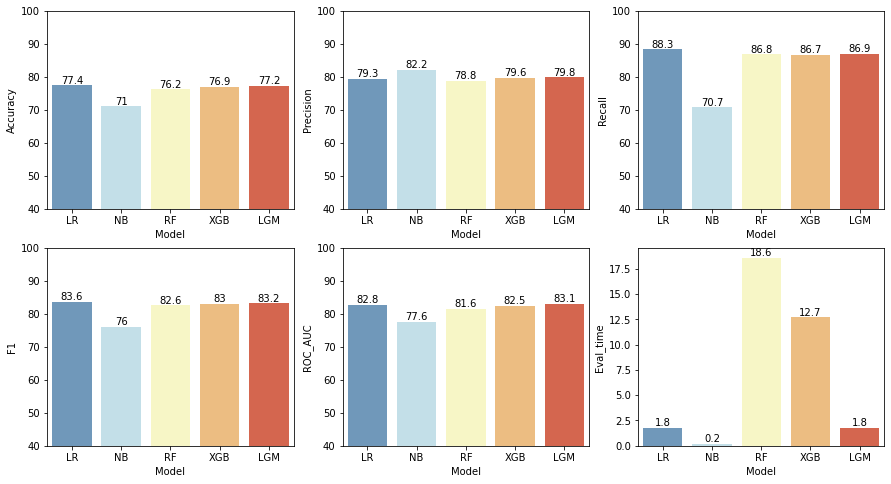

In [229]:
# Evaluation of Classifiers (Base Model)
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(15,8))
fig.subplots_adjust(wspace=0.2)

sns.barplot(data=results, x=results["Model"], y=results["Accuracy"], ax=ax1, palette='RdYlBu_r')
ax1.set_ylim([40,100])
ax1.bar_label(ax1.containers[0])
sns.barplot(data=results, x=results["Model"], y=results["Precision"], ax=ax2, palette='RdYlBu_r')
ax2.set_ylim([40,100])
ax2.bar_label(ax2.containers[0])
sns.barplot(data=results, x=results["Model"], y=results["Recall"], ax=ax3, palette='RdYlBu_r')
ax3.set_ylim([40,100])
ax3.bar_label(ax3.containers[0])
sns.barplot(data=results, x=results["Model"], y=results["F1"], ax=ax4, palette='RdYlBu_r')
ax4.set_ylim([40,100])
ax4.bar_label(ax4.containers[0])
sns.barplot(data=results, x=results["Model"], y=results["ROC_AUC"], ax=ax5, palette='RdYlBu_r')
ax5.set_ylim([40,100])
ax5.bar_label(ax5.containers[0])
sns.barplot(data=results, x=results["Model"], y=results["Eval_time"], ax=ax6, palette='RdYlBu_r')
ax6.bar_label(ax6.containers[0])

## 7.3  **Random Search CV on all Models** <a class="anchor" id="randomsearchcv"></a>

#### Random Search - Logistic Regression 

In [230]:
%%time
lr_params = {'C': [100, 10, 1.0, 0.1, 0.01],}

lr_rs = RandomizedSearchCV(LogisticRegression(solver = "newton-cg", penalty='l2' ), lr_params, cv=5, 
                           verbose=0, error_score ='raise', scoring = ['recall', 'precision'], refit = 'recall',
                           n_iter = 100,)
# scoring = ['recall', 'precision'], refit = 'recall'
lr_rs.fit(X_train, y_train)
best_lr = lr_rs.best_estimator_
print(lr_rs.best_params_)
print(lr_rs.best_score_) 

C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'C': 0.1}
0.8863340563991324
CPU times: total: 1min 45s
Wall time: 32.9 s


Accuracy : 77.1023 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.6053 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 88.9969 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.4789                                                                     Best: 1, Worst: 0
ROC AUC  : 82.7611                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[2926 2393]
 [1087 8792]]
TP 8792 TN 2926 FP 2393 FN 1087
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      5319
           1       0.79      0.89      0.83      9879

    accuracy                         

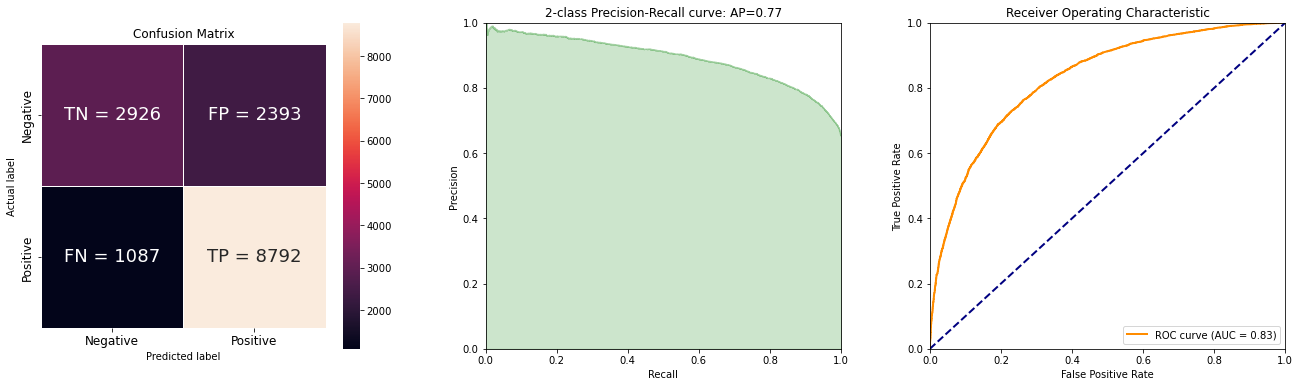

(77.1022502960916,
 78.60527492177023,
 88.9968620305699,
 83.47892138245349,
 82.76112478188564)

In [231]:
best_lr.fit(X_train,y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]
show_summary_report(y_test, y_pred, y_proba)

#### Random Search - Naive Bayes 

In [232]:
%%time
nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_rs = RandomizedSearchCV(GaussianNB(), nb_params, cv=5, error_score ='raise', verbose=0, 
                           scoring = ['recall', 'precision'], refit = 'recall')

nb_rs.fit(X_train, y_train)
best_nb = nb_rs.best_estimator_
print(nb_rs.best_params_)
print(nb_rs.best_score_)

{'var_smoothing': 0.533669923120631}
0.8634707158351411
CPU times: total: 8.14 s
Wall time: 8.2 s


Accuracy : 71.6213 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 74.1370 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.5270 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 79.8543                                                                     Best: 1, Worst: 0
ROC AUC  : 78.2829                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[2337 2982]
 [1331 8548]]
TP 8548 TN 2337 FP 2982 FN 1331
              precision    recall  f1-score   support

           0       0.64      0.44      0.52      5319
           1       0.74      0.87      0.80      9879

    accuracy                         

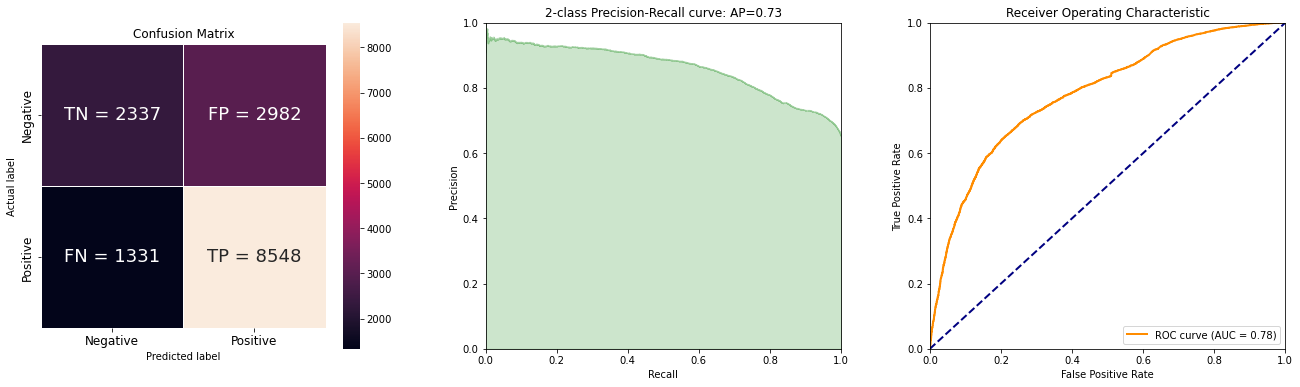

(71.62126595604686,
 74.13703382480486,
 86.52697641461687,
 79.85426689709936,
 78.2828922955161)

In [233]:
best_nb.fit(X_train,y_train)
y_pred = best_nb.predict(X_test)
y_proba = best_nb.predict_proba(X_test)[:, 1]
show_summary_report(y_test, y_pred, y_proba)

#### Random Search - Random Forest 

In [234]:
%%time
rf_params = {'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)],
             'criterion' : ['gini', 'entropy'],}

rf_rs = RandomizedSearchCV(rfc, rf_params, cv=5, n_iter = 100, verbose=0, 
                           error_score ='raise', scoring = ['recall', 'precision'], refit = 'recall')

rf_rs.fit(X_train, y_train)
best_rf = rf_rs.best_estimator_
print(rf_rs.best_params_)
print(rf_rs.best_score_) 

C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 155, 'criterion': 'gini'}
0.8711930585683298
CPU times: total: 12min 2s
Wall time: 12min 7s


Accuracy : 76.2008 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.7882 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.7395 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 82.5729                                                                     Best: 1, Worst: 0
ROC AUC  : 81.7953                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[3012 2307]
 [1310 8569]]
TP 8569 TN 3012 FP 2307 FN 1310
              precision    recall  f1-score   support

           0       0.70      0.57      0.62      5319
           1       0.79      0.87      0.83      9879

    accuracy                         

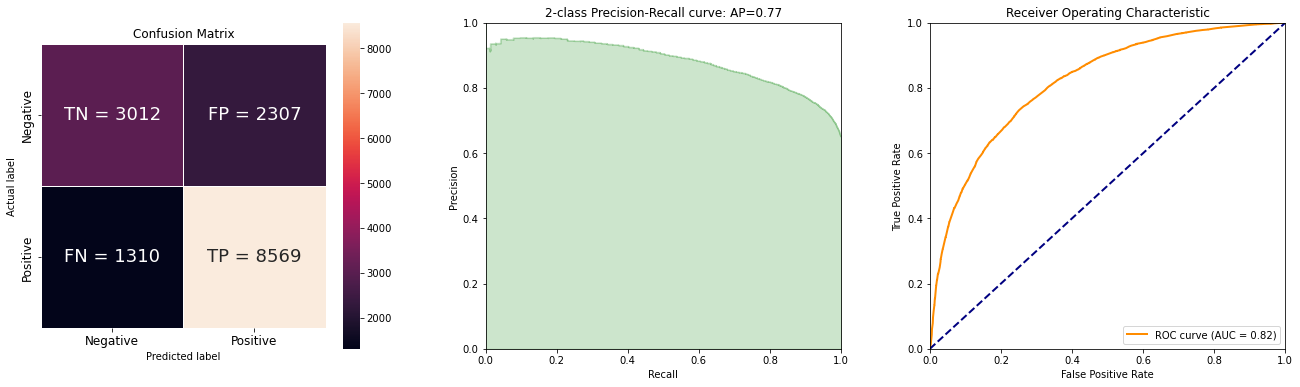

(76.20081589682853,
 78.7881574108128,
 86.73954853730135,
 82.57287400626355,
 81.79531267993025)

In [235]:
best_rf.fit(X_train,y_train)
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
show_summary_report(y_test, y_pred, y_proba)

#### Random Search - XGBoost Classifier 

In [236]:
%%time
xgb_params ={'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)],
            }

xgb_rs = RandomizedSearchCV(xgb, xgb_params, cv=5, error_score ='raise', 
                            scoring = ['recall', 'precision'], refit = 'recall',  n_iter = 100,)

xgb_rs.fit(X_train, y_train)
best_xgb = xgb_rs.best_estimator_
print(xgb_rs.best_params_)
print(xgb_rs.best_score_)

C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[21:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:19:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:19:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a fa

[21:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a fa

[21:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy : 76.7469 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.8488 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 87.7720 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.0715                                                                     Best: 1, Worst: 0
ROC AUC  : 82.3337                                                                     Best: 1, Worst: < 0.5
-------------------------------------------------------

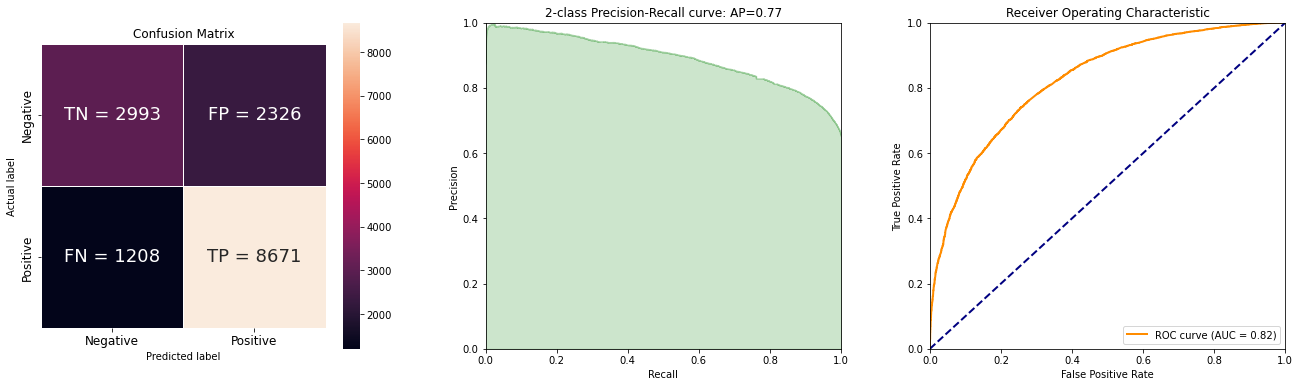

(76.74694038689302,
 78.84877693916522,
 87.77204170462596,
 83.07146963019734,
 82.3337453691643)

In [237]:
best_xgb.fit(X_train,y_train)
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]
show_summary_report(y_test, y_pred, y_proba)

#### Random Search - LightGBM Classifier 

In [238]:
%%time
lgb_params = {'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)],}

lgb_rs = RandomizedSearchCV(lgb, lgb_params, cv=5, n_iter = 100, verbose=0, error_score ='raise', 
                            scoring = ['recall', 'precision'], refit = 'recall',)

lgb_rs.fit(X_train, y_train)
best_lgb = lgb_rs.best_estimator_
print(lgb_rs.best_params_)
print(lgb_rs.best_score_) 

C:\Users\lilli\anaconda3\envs\IOD38\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011663 seconds.
You can set `f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017431 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy : 76.1942 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 77.3621 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 89.5941 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.0300                                                                     Best: 1, Worst: 0
ROC AUC  : 81.6655                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[2729 2590]
 [

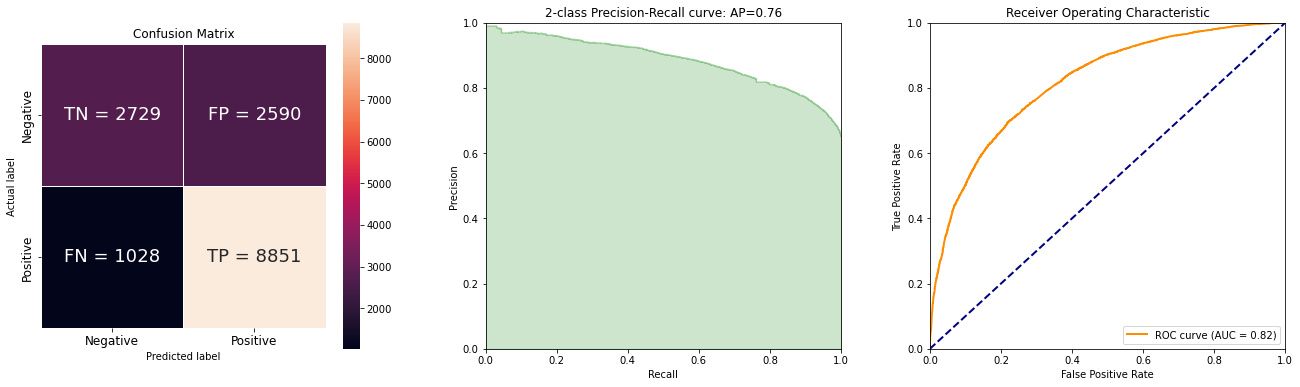

(76.19423608369522,
 77.3621186959182,
 89.59408847049296,
 83.03001876172608,
 81.66547885934186)

In [239]:
best_lgb.fit(X_train,y_train)
y_pred = best_lgb.predict(X_test)
y_proba = best_lgb.predict_proba(X_test)[:, 1]
show_summary_report(y_test, y_pred, y_proba)

#### After Random Search Tuning 

  0%|          | 0/1 [00:00<?, ?it/s]

******
* LR *
******
Accuracy : 77.1023 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.6053 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 88.9969 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.4789                                                                     Best: 1, Worst: 0
ROC AUC  : 82.7611                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
[[2926 2393]
 [1087 8792]]
TP 8792 TN 2926 FP 2393 FN 1087
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      5319
           1       0.79      0.89      0.83      9879

    accuracy    

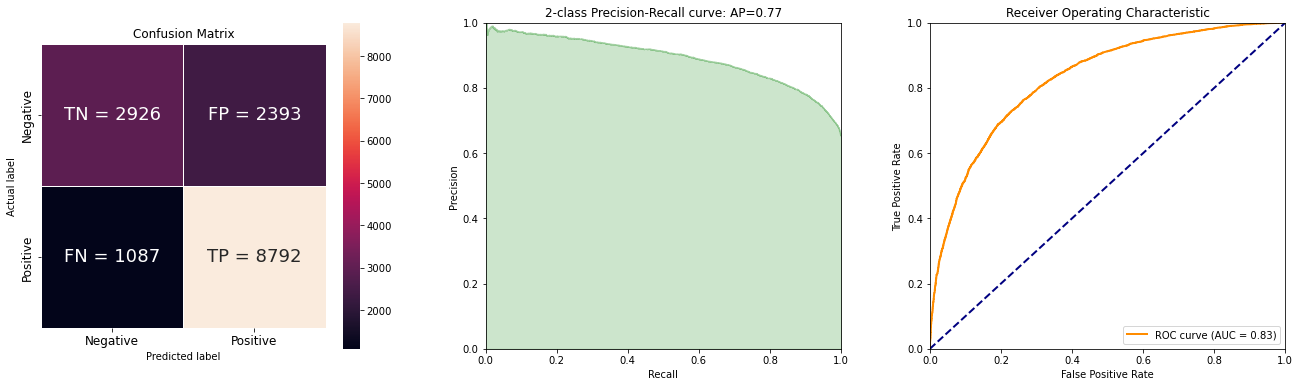

              precision    recall  f1-score   support

           0       0.73      0.55      0.63      5319
           1       0.79      0.89      0.83      9879

    accuracy                           0.77     15198
   macro avg       0.76      0.72      0.73     15198
weighted avg       0.77      0.77      0.76     15198


******
* NB *
******
Accuracy : 71.6213 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 74.1370 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.5270 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 79.8543                                                                     Best: 1, Worst: 0
ROC AUC  : 78.2829                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Posit

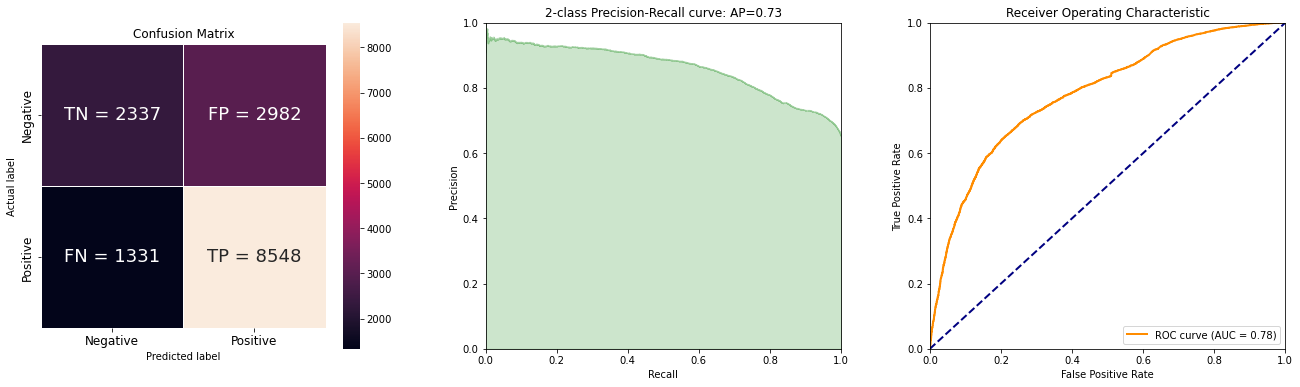

              precision    recall  f1-score   support

           0       0.64      0.44      0.52      5319
           1       0.74      0.87      0.80      9879

    accuracy                           0.72     15198
   macro avg       0.69      0.65      0.66     15198
weighted avg       0.70      0.72      0.70     15198


******
* RF *
******
Accuracy : 76.2008 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.7882 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 86.7395 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 82.5729                                                                     Best: 1, Worst: 0
ROC AUC  : 81.7953                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Posit

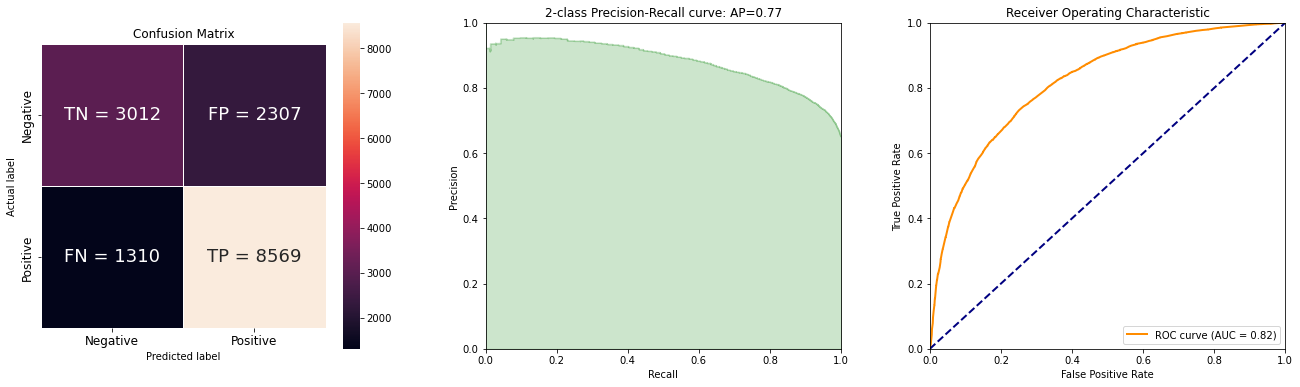

              precision    recall  f1-score   support

           0       0.70      0.57      0.62      5319
           1       0.79      0.87      0.83      9879

    accuracy                           0.76     15198
   macro avg       0.74      0.72      0.73     15198
weighted avg       0.76      0.76      0.76     15198


*******
* XGB *
*******
[21:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy : 76.7469 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 78.8488 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 87.7720 [TP

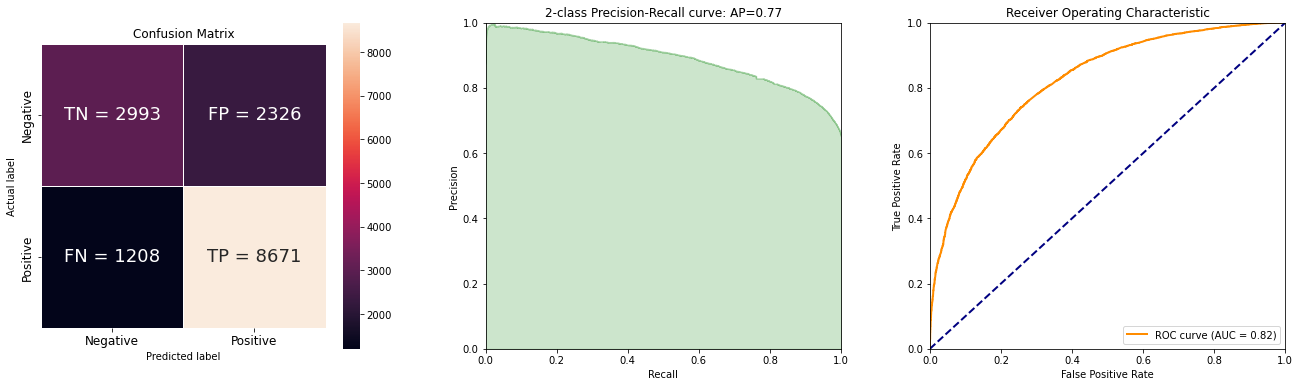

              precision    recall  f1-score   support

           0       0.71      0.56      0.63      5319
           1       0.79      0.88      0.83      9879

    accuracy                           0.77     15198
   macro avg       0.75      0.72      0.73     15198
weighted avg       0.76      0.77      0.76     15198


*******
* LGM *
*******
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Accuracy : 76.1942 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 77.3621 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 89.5941 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
F1 Score : 83.0300      

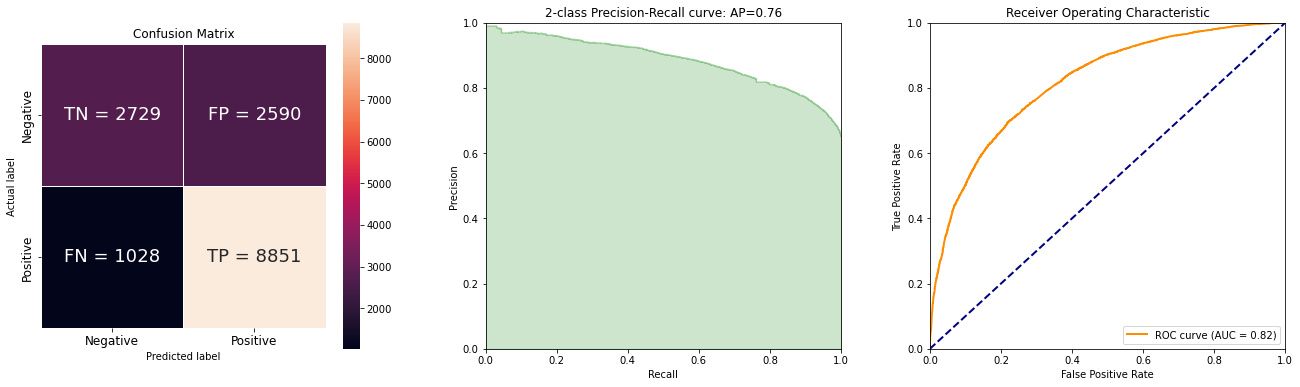

              precision    recall  f1-score   support

           0       0.73      0.51      0.60      5319
           1       0.77      0.90      0.83      9879

    accuracy                           0.76     15198
   macro avg       0.75      0.70      0.72     15198
weighted avg       0.76      0.76      0.75     15198


CPU times: total: 51.5 s
Wall time: 30.5 s


In [240]:
%%time

for i in tqdm_notebook(range(1)):
    # Keep the results in a dataframe
    tuned_results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Eval_time'])

    models = ["LR", 'NB', 'RF', 'XGB', 'LGM',]
    for i, m in enumerate([best_lr, best_nb, best_rf, best_xgb, best_lgb,]):
        print('*' * (len(models[i]) + 4))
        print('* %s *' % models[i])
        print('*' * (len(models[i]) + 4))

        #measure start time of model
        start_time = time.time()
        
        #Fit the model to training data     
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        y_proba = m.predict_proba(X_test)[:, 1]
        
        #measure end time of model
        end_time = time.time()
        
        # show the report
        accuracy_, precision_, recall_, f1_, roc_auc_ = show_summary_report(y_test, y_pred, y_proba)
        
        # print classification report to show the individual class scoring
        print(classification_report(y_test, y_pred))

        # keep the results
        tuned_results.loc[i] = {'Model': models[i], 
                          'Accuracy': accuracy_, 
                          'Precision': precision_,
                          'Recall': recall_,
                          'F1': f1_,
                          'ROC_AUC': roc_auc_,
                          'Eval_time': end_time - start_time,}
        tuned_results = tuned_results.round(1)
        print()

In [241]:
tuned_results

Model  Accuracy  Precision  Recall    F1  ROC_AUC  Eval_time
0    LR      77.1       78.6    89.0  83.5     82.8        1.1
1    NB      71.6       74.1    86.5  79.9     78.3        0.2
2    RF      76.2       78.8    86.7  82.6     81.8       23.4
3   XGB      76.7       78.8    87.8  83.1     82.3        2.7
4   LGM      76.2       77.4    89.6  83.0     81.7        0.5

In [242]:
results

Model  Accuracy  Precision  Recall    F1  ROC_AUC  Eval_time
0    LR      77.4       79.3    88.3  83.6     82.8        1.8
1    NB      71.0       82.2    70.7  76.0     77.6        0.2
2    RF      76.2       78.8    86.8  82.6     81.6       18.6
3   XGB      76.9       79.6    86.7  83.0     82.5       12.7
4   LGM      77.2       79.8    86.9  83.2     83.1        1.8

[Text(0, 0, '1.1'),
 Text(0, 0, '0.2'),
 Text(0, 0, '23.4'),
 Text(0, 0, '2.7'),
 Text(0, 0, '0.5')]

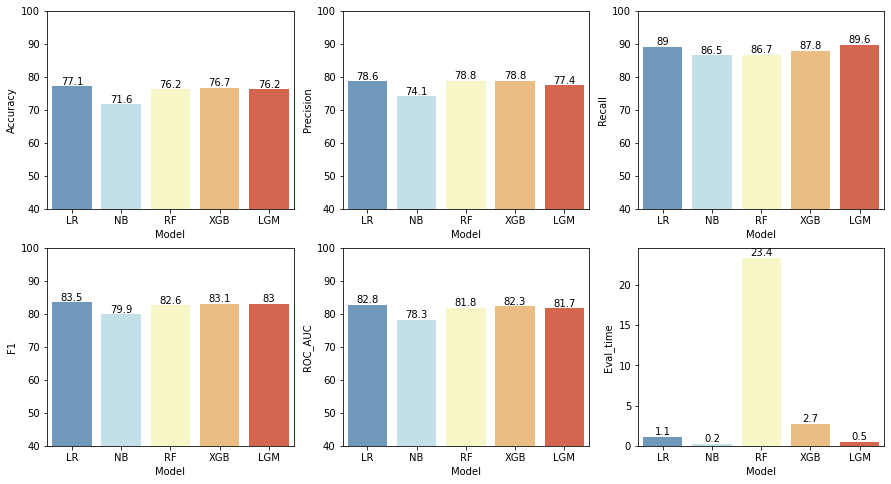

In [243]:
# Evaluation of Classifiers (tUNED Model)
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(15,8))
fig.subplots_adjust(wspace=0.2)

sns.barplot(data=tuned_results, x=tuned_results["Model"], y=tuned_results["Accuracy"], ax=ax1, palette='RdYlBu_r')
ax1.set_ylim([40,100])
ax1.bar_label(ax1.containers[0])
sns.barplot(data=tuned_results, x=tuned_results["Model"], y=tuned_results["Precision"], ax=ax2, palette='RdYlBu_r')
ax2.set_ylim([40,100])
ax2.bar_label(ax2.containers[0])
sns.barplot(data=tuned_results, x=tuned_results["Model"], y=tuned_results["Recall"], ax=ax3, palette='RdYlBu_r')
ax3.set_ylim([40,100])
ax3.bar_label(ax3.containers[0])
sns.barplot(data=tuned_results, x=tuned_results["Model"], y=tuned_results["F1"], ax=ax4, palette='RdYlBu_r')
ax4.set_ylim([40,100])
ax4.bar_label(ax4.containers[0])
sns.barplot(data=tuned_results, x=tuned_results["Model"], y=tuned_results["ROC_AUC"], ax=ax5, palette='RdYlBu_r')
ax5.set_ylim([40,100])
ax5.bar_label(ax5.containers[0])
sns.barplot(data=tuned_results, x=tuned_results["Model"], y=tuned_results["Eval_time"], ax=ax6, palette='RdYlBu_r')
ax6.bar_label(ax6.containers[0])

## 7.4  **Final Model - Feature Importance** <a class="anchor" id="final_model"></a>

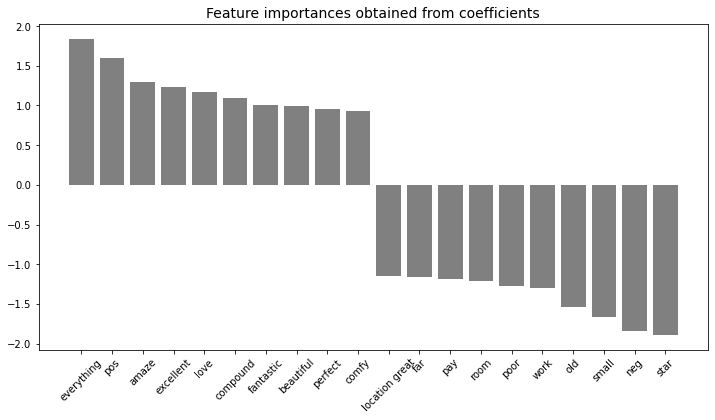

In [244]:
# get importance
fig, ax1 = plt.subplots(1, 1, figsize=(12,6))
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': best_lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances_pos = importances.head(10)
importances_neg = importances.tail(10)
importances_comb = pd.concat([importances_pos,importances_neg]) 
importances_comb

plt.bar(x=importances_comb['Attribute'], height=importances_comb['Importance'], color='grey')
plt.title('Feature importances obtained from coefficients', size=14)
plt.xticks(rotation=45)
plt.show()

## 7.5 Precision & Recall Tradeoff  <a class="anchor" id="pr_curves"></a>

CPU times: total: 31.2 ms
Wall time: 30.3 ms


Text(0.39, -0.04, '0.5 threshold')

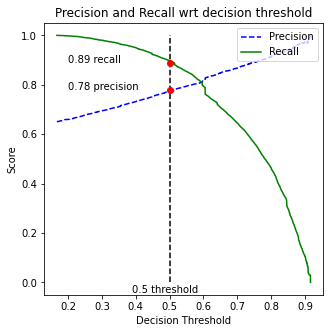

In [245]:
%%time
# from sklearn.metrics import plot_precision_recall_curve
y_pred = best_lr.predict_proba(X_test)[:,1]
p, r, threshold = precision_recall_curve(y_test, y_proba)

def plot_precision_recall_threshold(precisions, recalls, thresholds):

    plt.figure(figsize=(5, 5))
    plt.title("Precision and Recall wrt decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot([0.5, 0.5], [0, 1], 'k--')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='upper right')
    
plot_precision_recall_threshold(p, r, threshold)
# Precision score at 0.5 threshold
plt.plot(0.5, 0.78, 'or')
plt.annotate('0.78 precision', (0.2, 0.78))

# Recall score at 0.5 threshold
plt.plot(0.5, 0.89, 'or')
plt.annotate('0.89 recall', (0.2, 0.89))
plt.annotate('0.5 threshold', (0.39, -0.04))

## 7.6 Confusion Matrices & Different Thresholds  <a class="anchor" id="cm_thresholds"></a>

In [246]:
%%time
# Prediction probabilities with different thresholds
y_pred = (best_lr.predict_proba(X_test)[:,1] >= 0.5).astype(bool).astype(int)
y_pred_dt = (best_lr.predict_proba(X_test)[:,1] >= 0.1).astype(bool).astype(int)
y_pred_dt_2 = (best_lr.predict_proba(X_test)[:,1] >= 0.40).astype(bool).astype(int)
y_pred_dt_3 = (best_lr.predict_proba(X_test)[:,1] >= 0.30).astype(bool).astype(int)
y_pred_dt_4 = (best_lr.predict_proba(X_test)[:,1] >= 0.60).astype(bool).astype(int)

CPU times: total: 31.2 ms
Wall time: 34.1 ms


In [247]:
# Confusion matrices with different thresholds
cm = confusion_matrix(y_test, y_pred)           #0.50 threshold
cm_dt = confusion_matrix(y_test, y_pred_dt)     #0.10 threshold
cm_dt_2 = confusion_matrix(y_test, y_pred_dt_2) #0.40 threshold
cm_dt_3 = confusion_matrix(y_test, y_pred_dt_3) #0.30 threshold
cm_dt_4 = confusion_matrix(y_test, y_pred_dt_4) #0.60 threshold

[[2926 2393]
 [1087 8792]]
TP 8792 TN 2926 FP 2393 FN 1087


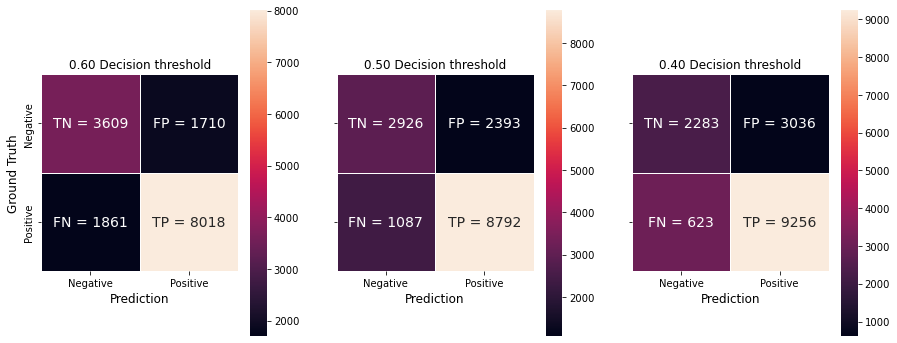

In [248]:
# Confusion Matrix    
#mat = confusion_matrix(actual, prediction)      
#sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, ax = ax[0], annot_kws={"size": 20})

# Plotting confusion matrices
fig, ax = plt.subplots(1,3,figsize=(15,6))
ax.flatten()
#fig.suptitle('Confusion matrix different thresholds', fontsize=18)
fig.subplots_adjust(wspace=0.2)

modified_cm_dt_4 = []
for index,value in enumerate(cm_dt_4):
    if index == 0:
        modified_cm_dt_4.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm_dt_4.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])    

sns.heatmap(cm_dt_4.T, square = True, annot = modified_cm_dt_4, fmt = "", cbar = 'YlGnBu', 
                annot_kws={"size": 14}, linewidths=.5, ax = ax[0])

modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])    

sns.heatmap(cm.T, square = True, annot = modified_cm, fmt = "", cbar = 'YlGnBu', 
                annot_kws={"size": 14}, linewidths=.5, ax = ax[1])

modified_cm_dt_2 = []
for index,value in enumerate(cm_dt_2):
    if index == 0:
        modified_cm_dt_2.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm_dt_2.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])    

sns.heatmap(cm_dt_2.T, square = True, annot = modified_cm_dt_2, fmt = "", cbar = 'YlGnBu', 
                annot_kws={"size": 14}, linewidths=.5, ax = ax[2])

ax[0].set_title('0.60 Decision threshold')   #0.60 threshold
ax[1].set_title('0.50 Decision threshold')   #0.50 threshold
ax[2].set_title('0.40 Decision threshold')   #0.40 threshold

labels = ['Negative', 'Positive']
for i in [0,1,2]:
    ax[i].set_xticklabels(labels, fontsize=10)
    ax[i].set_xlabel('Prediction', fontsize=12)
    ax[i].set_yticklabels(['',''])
    
ax[0].set_ylabel('Ground Truth', fontsize=12)
ax[0].set_yticklabels(labels, fontsize=10)


TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
print(cm)
print("TP", TP, "TN", TN, "FP", FP, "FN", FN)

## 7.7 Cross Validation of Tuned Models  <a class="anchor" id="cv"></a>

In [249]:
%%time
for i in tqdm_notebook(range(1)):
    # DO CROSS VALIDATION ACROSS MULTIPLE MODELS 

    from sklearn import model_selection
    for clf, label in zip([best_lr, best_nb, best_rf, best_xgb, best_lgb], 
                          ["Logistic Regression", "Naive Bayes", "Random Forest", "XGBoost Classifier", 
                           "LightGBM Classifier"]):

        scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                                  cv=5, scoring='accuracy')
        print("Accuracy of training data after CV: %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy of training data after CV: 0.77 (+/- 0.01) [Logistic Regression]
Accuracy of training data after CV: 0.72 (+/- 0.00) [Naive Bayes]
Accuracy of training data after CV: 0.76 (+/- 0.01) [Random Forest]
[21:26:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open

## 7.8 Learning Curves of Tuned Models  <a class="anchor" id="learn"></a>

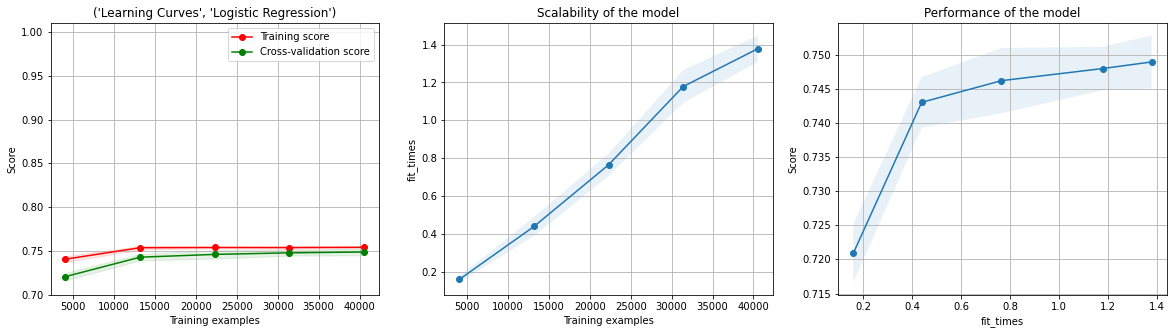

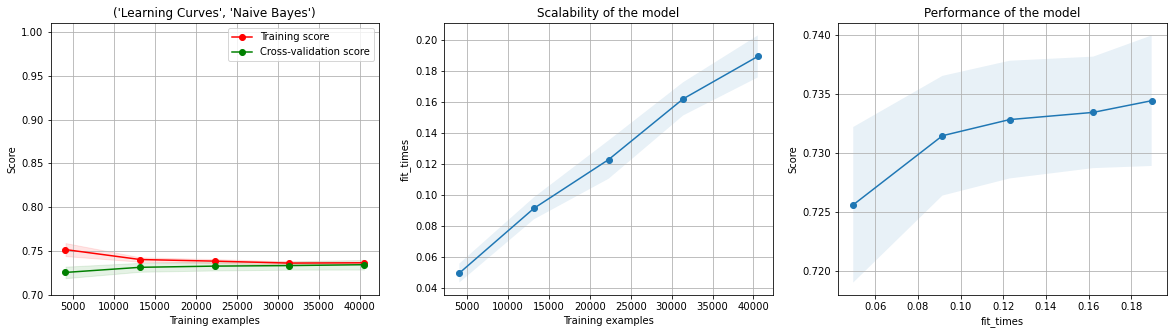

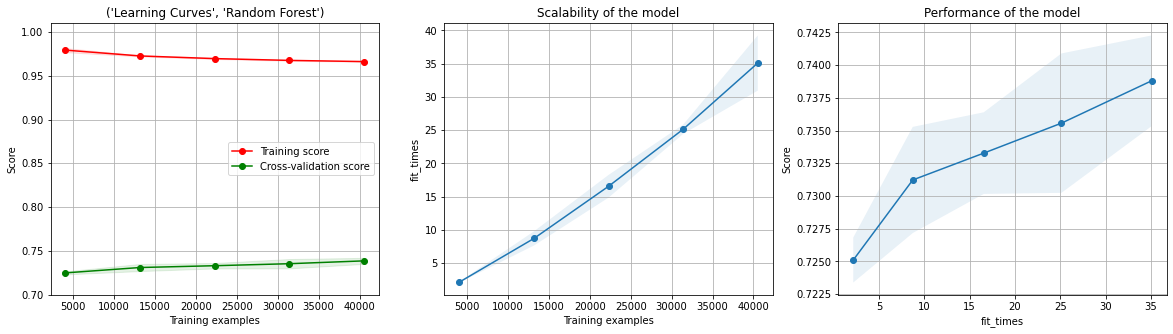

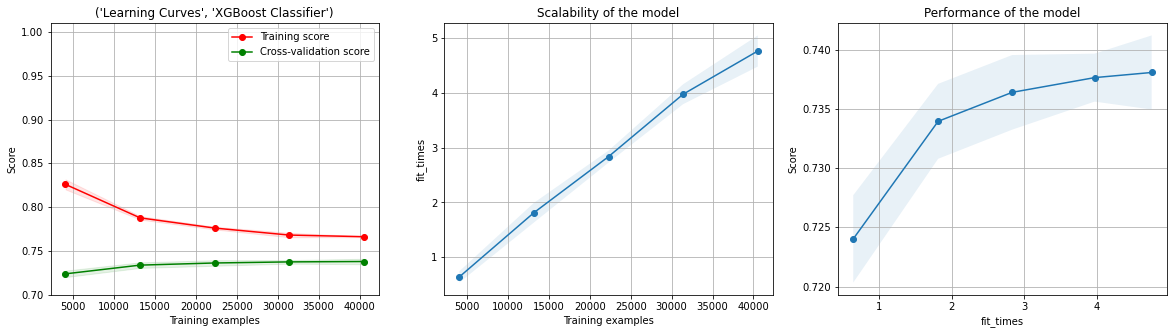

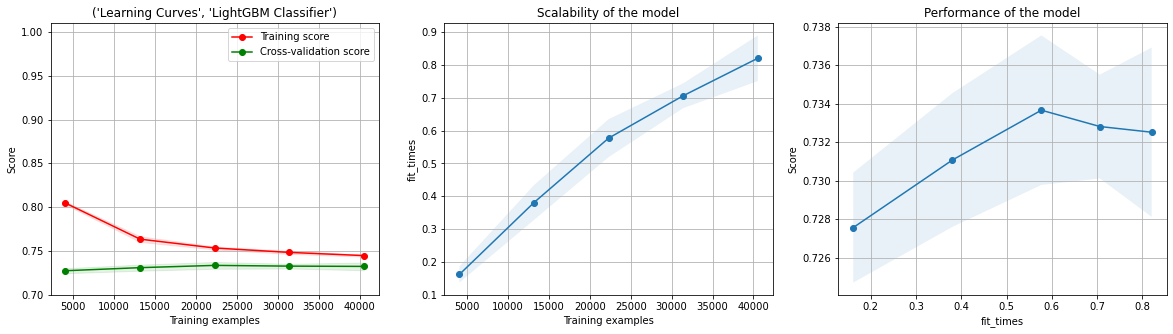

In [250]:
# %%time
# Print learning curves in a loop
for clf, label in zip([best_lr, best_nb, best_rf, best_xgb, best_lgb], 
                      ["Logistic Regression", "Naive Bayes", "Random Forest", "XGBoost Classifier",
                       "LightGBM Classifier"]):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    title = "Learning Curves", label
    
    # Cross validation with 5 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    estimator = clf # change estimator
    plot_learning_curve(estimator, title, X_tfidf_df, y, axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=2)

plt.show()

## 8. Recommendations to the Business <a class="anchor" id="recommendations"></a>

Based on our analysis, below are our recommendations:
* While the size of the hotel room cannot be easily altered, we would recommend that the hotel can be more transparent in the facts on their website by providing more precise room dimensions between furniture, 3D room layout so that guests can better visualise the room prior to booking.
* Similarly, there were concerns over the hotel locations being far from their destinations and the guests had to walk. Perhaps the hotel can look into shuttle bus service that chauffeur hotel guests to the common destinations or nearest subway stations. 
* To address quality of staff service, the client would need to invest in staff training and perhaps look into their staff retention to avoid high staff turnover to maintain the service level standards in the hotel. The hotel might also need to look into flexible staffing strategies during busy months to maintain the service level of the hotel staff.
* The guest also placed much importance on “breakfast” as evidenced in the TFIDF analysis and the model feature importance, hence the hotel has to ensure that they continue to improve the negative aspect in their breakfast offerings. 
* Last but not the least, if the client has budget to uplift or renovate, we would propose that they look into the air-conditioning system, bed condition. 


## 9. Future Works <a class="anchor" id="future"></a>

* Consider the precision recall tradeoff and finalise the decision threshold
* Apply to a larger training set to assess the consistency of the scores.
* To perform further multivariate analysis to find the connection between the text classification features and the existing features to uncover more business insights.
* Relook at the text pre processing to clean the data further.
* Relook at hyper parameter tuning to see if F1 can be improved further.
* Apply the model to a larger sample size to see if the score differs.

## 10. References <a class="anchor" id="references"></a>

Detecting bad customer reviews with NLP (Jonathan Oheix, 2018) <br>
https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e <br>
<br>
Sentiment Analysis using NLP on Hotel Review Dataset (Rishan Sanjay, 2021) <br>
https://medium.com/analytics-vidhya/sentiment-analysis-using-nlp-on-hotel-review-dataset-fa049e23de29 <br>
<br>
Text analysis basics in Python (Sophia Yang, 2020) <br>
https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5 <br>
<br>
How to solve 90% of NLP problems: a step-by-step guide (Emmanuel Ameisen, 2018) <br>
https://medium.com/insight-data/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e <br>

SENTIMENTAL ANALYSIS USING VADER (Aditya Beri, 2020) <br>
https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 <br>

Máster – Big Data & Data Science UCM - Anál. Sent. (JAIME SÁNCHEZ, 2021) <br>
https://www.kaggle.com/code/jaimesz11/m-ster-big-data-data-science-ucm-an-l-sent <br>